# Linear Inverted Pendulum with Wall, Hybrid MPC Demo

This is a demo for the Model Predictive Control (MPC) package $\texttt{mpc_tools}$.

In [1]:
%load_ext autoreload
%autoreload 2
#%pylab notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pympc.dynamical_systems as ds
import pympc.plot as mpc_plt
from pympc.control import MPCHybridController
from pympc.feasible_set_library import FeasibleSetLibrary
from pympc.geometry.polytope import Polytope

# Dynamics

We stabilize a linear inverted pendulum with mass $m$ and length $l$, subject to the gravity acceleration $g$. The pendulum is allowed to impact with an elastic wall (with stiffness $k$) placed at distance $d$ from the vertical line passing trough the hinge.

In [3]:
m = 1.
l = 1.
g = 10.
k = 1000.
d = .1
t_s = .01

We express the linearized dynamics in PieceWise Affine (PWA) form:
\begin{equation}
\dot x =
\begin{cases}
A_1 x + B_1 u + c_1, \quad \text{if} \quad (x, u) \in \mathcal D_1, \\
A_2 x + B_2 u + c_2, \quad \text{if} \quad (x, u) \in \mathcal D_2,
\end{cases}
\end{equation}

with

\begin{equation}
A_1 = 
\begin{bmatrix}
0 & 1 \\ g/l & 0
\end{bmatrix},
\quad
B_1 = 
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix},
\quad
c_1 = 
\begin{bmatrix}
0 \\ 0
\end{bmatrix},
\end{equation}

\begin{equation}
\mathcal D_1 =
\{ (x,u) \ | \ x_1 \leq d/l, \ x_{min} \leq x \leq x_{max}, \ u_{min} \leq u \leq u_{max} \},
\end{equation}

\begin{equation}
A_2 = 
\begin{bmatrix}
0 & 1 \\ g/l - k/m & 0
\end{bmatrix},
\quad
B_2 = 
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix},
\quad
c_2 = 
\begin{bmatrix}
0 \\ kd/(ml)
\end{bmatrix},
\end{equation}

\begin{equation}
\mathcal D_2 =
\{ (x,u) \ | \ x_1 > d/l, \ x_{min} \leq x \leq x_{max}, \ u_{min} \leq u \leq u_{max} \},
\end{equation}


The discrete-time PWA system can be defined from its continuous-time representation setting a sampling time $t_s$.

In [4]:
# discretization method
method = 'explicit_euler'

# dynamics n.1
A_1 = np.array([[0., 1.],[g/l, 0.]])
B_1 = np.array([[0.],[1/(m*l**2.)]])
c_1 = np.array([[0.],[0.]])
S_1 = ds.DTAffineSystem.from_continuous(A_1, B_1, c_1, t_s, method)

# dynamics n.2
A_2 = np.array([[0., 1.],[g/l-k/m, 0.]])
B_2 = B_1
c_2 = np.array([[0.],[k*d/(m*l)]])
S_2 = ds.DTAffineSystem.from_continuous(A_2, B_2, c_2, t_s, method)

# list of dynamics
S = [S_1, S_2]

print S_1.A, S_1.B, S_1.c
print S_2.A, S_2.B, S_2.c

The domains of the PWA have to be expressed as polytopes.

In [5]:
# state domain n.1
x_max_1 = np.array([[d/l], [1.]])
x_min_1 = -np.array([[d/l*1.2],[x_max_1[1,0]]])
X_1 = Polytope.from_bounds(x_min_1, x_max_1)
X_1.assemble()

# state domain n.2
x_min_2 = np.array([[x_max_1[0,0]], [x_min_1[1,0]]])
x_max_2 = -x_min_1
X_2 = Polytope.from_bounds(x_min_2, x_max_2)
X_2.assemble()

# list of state domains
X = [X_1, X_2]

# input domain
u_max = np.array([[4.]])
u_min = -u_max
U = Polytope.from_bounds(u_min, u_max)
U.assemble()
U = [U]*2

We can now define the PWA system.

In [6]:
pwa_sys = ds.DTPWASystem.from_orthogonal_domains(S, X, U)

# MPC controller

At each each step, the following optimal control is solved
\begin{align}
\min \quad &
\sum_{k=0}^{N-1} (x_k^T Q x_k + u_k^T R u_k) + x_N^T P x_N \\
\text{subject to} \quad &
x_{k+1} =
\begin{cases}
A_1 x_k + B_1 u_k + c_1, \quad \text{if} \quad (x_k, u_k) \in \mathcal D_1, \\
A_2 x_k + B_2 u_k + c_2, \quad \text{if} \quad (x_k, u_k) \in \mathcal D_2,
\end{cases}, \\
& (x_k, u_k) \in \mathcal D_1 \cup \mathcal D_2, \quad k = 1,2,\ldots,N-1, \\
& x_N \in \mathcal X_N, \\
& x_0 \ \text{given}, \\
\end{align}
and the input $u_0$ is applied to the system.

In [7]:
# controller parameters
N = 10
Q = np.eye(A_1.shape[0])
R = np.eye(B_1.shape[1])
objective_norm = 'two'

# terminal set and cost
P, K = ds.dare(S[0].A, S[0].B, Q, R)
X_N = ds.moas_closed_loop_from_orthogonal_domains(S[0].A, S[0].B, K, X[0], U[0])

# hybrid controller
gurobi_parameters = {'OutputFlag': False}
controller = MPCHybridController(pwa_sys, N, objective_norm, Q, R, P, X_N, gurobi_parameters)

Computation of Maximal Invariant Constraint-Admissible Set started.
Determinedness index: 23, Convergence index: -8.25676885114e-05, Number of facets: 120.                
Maximal Invariant Constraint-Admissible Set found.
Removing redundant facets ... minimal facets are 45.


We can now simulate the closed-loop dynamics startion from the initial state $x_0$.

In [8]:
N_sim = 100
x_0 = np.array([[.05],[.52]])
u = []
x = [x_0]
for k in range(N_sim):
    print('Time step ' + str(k) + '.\r'),
    u.append(controller.feedback(x[k]))
    x_next = pwa_sys.simulate(x[k], [u[k]])[0][1]
    x.append(x_next)

We can use the plot functions to visualize the time evolution of the system.

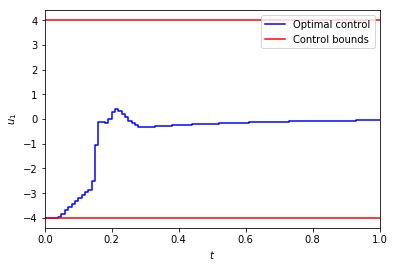

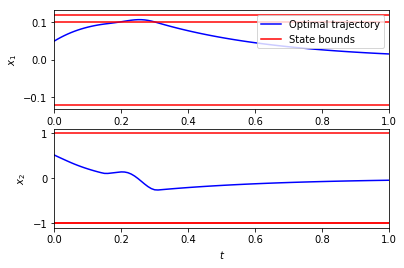

In [9]:
mpc_plt.input_sequence(u, t_s, (u_min, u_max))
plt.show()
mpc_plt.state_trajectory(x, t_s, (x_min_1, x_min_2, x_max_2))
plt.show()

# Approximate MPC controller

Construction of the library

In [10]:
terminal_mode = 0

In [11]:
n_samples = 50000
library = FeasibleSetLibrary(controller)
library.sample_policy(n_samples)
library.store_H_representations()
library.add_shifted_switching_sequences(terminal_mode)
#library.save('library_pendulum_' + str(n_samples))

Sample 0: 
solving MIQP...  time spent: 0.00844597816467 s, model status: OPTIMAL.
new switching sequence (0, 0, 0, 0, 0, 0, 0, 0, 0, 0).
condensing QP...  QP condensed in 0.00303196907043 s.
building inner approximation...  approximation built 0.100079059601 s.
Sample 1: 
solving MIQP...  time spent: 0.00357294082642 s, model status: OPTIMAL.
included.
including sample in inner approximation...  sample included in 0.0233578681946 s.
Sample 2: 
rejected.
Sample 3: 
solving MIQP...  time spent: 0.00126385688782 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4: 
solving MIQP...  time spent: 0.000656127929688 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5: 
solving MIQP...  time spent: 0.000592947006226 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6: 
solving MIQP...  time spent: 0.000691890716553 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7: 
solving MIQP...  time spent: 0.00816512107849 s, model status: OPTIMAL.
new switching sequence (1, 1, 1, 1, 1, 1, 1, 1, 1, 1).
cond

including sample in inner approximation...  sample included in 0.104673147202 s.
Sample 141: 
rejected.
Sample 142: 
solving MIQP...  time spent: 0.000593185424805 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 143: 
rejected.
Sample 144: 
rejected.
Sample 145: 
rejected.
Sample 146: 
rejected.
Sample 147: 
solving MIQP...  time spent: 0.000623941421509 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 148: 
rejected.
Sample 149: 
rejected.
Sample 150: 
rejected.
Sample 151: 
solving MIQP...  time spent: 0.00444006919861 s, model status: OPTIMAL.
new switching sequence (1, 1, 1, 0, 0, 0, 0, 0, 0, 0).
condensing QP...  QP condensed in 0.00163793563843 s.
building inner approximation...  approximation built 0.0411701202393 s.
Sample 152: 
rejected.
Sample 153: 
solving MIQP...  time spent: 0.00112581253052 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 154: 
rejected.
Sample 155: 
solving MIQP...  time spent: 0.00109195709229 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 156: 
reje

solving MIQP...  time spent: 0.000489950180054 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 350: 
rejected.
Sample 351: 
solving MIQP...  time spent: 0.00053596496582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 352: 
rejected.
Sample 353: 
rejected.
Sample 354: 
rejected.
Sample 355: 
solving MIQP...  time spent: 0.000506162643433 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 356: 
solving MIQP...  time spent: 0.00106000900269 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 357: 
rejected.
Sample 358: 
rejected.
Sample 359: 
solving MIQP...  time spent: 0.00046706199646 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 360: 
solving MIQP...  time spent: 0.000972032546997 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 361: 
rejected.
Sample 362: 
rejected.
Sample 363: 
rejected.
Sample 364: 
solving MIQP...  time spent: 0.00108504295349 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 365: 
rejected.
Sample 366: 
rejected.
Sample 367: 
solving MIQP...  time spent: 0.000541

Sample 536: 
solving MIQP...  time spent: 0.000588178634644 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 537: 
solving MIQP...  time spent: 0.000998973846436 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 538: 
rejected.
Sample 539: 
rejected.
Sample 540: 
rejected.
Sample 541: 
rejected.
Sample 542: 
rejected.
Sample 543: 
rejected.
Sample 544: 
rejected.
Sample 545: 
rejected.
Sample 546: 
rejected.
Sample 547: 
rejected.
Sample 548: 
rejected.
Sample 549: 
solving MIQP...  time spent: 0.000670194625854 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 550: 
rejected.
Sample 551: 
rejected.
Sample 552: 
solving MIQP...  time spent: 0.000586032867432 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 553: 
solving MIQP...  time spent: 0.000543832778931 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 554: 
solving MIQP...  time spent: 0.000535011291504 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 555: 
rejected.
Sample 556: 
rejected.
Sample 557: 
rejected.
Sample 558: 
rejecte

solving MIQP...  time spent: 0.00166201591492 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 713: 
solving MIQP...  time spent: 0.000557899475098 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 714: 
rejected.
Sample 715: 
rejected.
Sample 716: 
rejected.
Sample 717: 
rejected.
Sample 718: 
rejected.
Sample 719: 
rejected.
Sample 720: 
rejected.
Sample 721: 
rejected.
Sample 722: 
rejected.
Sample 723: 
rejected.
Sample 724: 
rejected.
Sample 725: 
solving MIQP...  time spent: 0.0036449432373 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 726: 
rejected.
Sample 727: 
rejected.
Sample 728: 
solving MIQP...  time spent: 0.000547885894775 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 729: 
solving MIQP...  time spent: 0.000526905059814 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 730: 
rejected.
Sample 731: 
rejected.
Sample 732: 
rejected.
Sample 733: 
rejected.
Sample 734: 
rejected.
Sample 735: 
solving MIQP...  time spent: 0.00603699684143 s, model status: INFEASIBLE OR UN

solving MIQP...  time spent: 0.000597953796387 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 911: 
rejected.
Sample 912: 
rejected.
Sample 913: 
rejected.
Sample 914: 
rejected.
Sample 915: 
rejected.
Sample 916: 
solving MIQP...  time spent: 0.000561952590942 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 917: 
solving MIQP...  time spent: 0.00107312202454 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 918: 
solving MIQP...  time spent: 0.00053882598877 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 919: 
rejected.
Sample 920: 
solving MIQP...  time spent: 0.00365686416626 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 921: 
solving MIQP...  time spent: 0.000550031661987 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 922: 
solving MIQP...  time spent: 0.000540018081665 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 923: 
rejected.
Sample 924: 
rejected.
Sample 925: 
solving MIQP...  time spent: 0.00106191635132 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 926: 
solv

solving MIQP...  time spent: 0.000582933425903 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1088: 
rejected.
Sample 1089: 
solving MIQP...  time spent: 0.00123500823975 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1090: 
rejected.
Sample 1091: 
solving MIQP...  time spent: 0.00520086288452 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1092: 
rejected.
Sample 1093: 
solving MIQP...  time spent: 0.000617027282715 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1094: 
solving MIQP...  time spent: 0.000637054443359 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1095: 
rejected.
Sample 1096: 
rejected.
Sample 1097: 
rejected.
Sample 1098: 
solving MIQP...  time spent: 0.0011157989502 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1099: 
rejected.
Sample 1100: 
rejected.
Sample 1101: 
rejected.
Sample 1102: 
rejected.
Sample 1103: 
rejected.
Sample 1104: 
rejected.
Sample 1105: 
rejected.
Sample 1106: 
rejected.
Sample 1107: 
rejected.
Sample 1108: 
solving MIQP...  time spen

rejected.
Sample 1261: 
rejected.
Sample 1262: 
rejected.
Sample 1263: 
rejected.
Sample 1264: 
rejected.
Sample 1265: 
rejected.
Sample 1266: 
solving MIQP...  time spent: 0.000548124313354 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1267: 
rejected.
Sample 1268: 
rejected.
Sample 1269: 
rejected.
Sample 1270: 
rejected.
Sample 1271: 
rejected.
Sample 1272: 
solving MIQP...  time spent: 0.00160002708435 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1273: 
rejected.
Sample 1274: 
rejected.
Sample 1275: 
rejected.
Sample 1276: 
rejected.
Sample 1277: 
solving MIQP...  time spent: 0.000484943389893 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1278: 
rejected.
Sample 1279: 
rejected.
Sample 1280: 
rejected.
Sample 1281: 
rejected.
Sample 1282: 
rejected.
Sample 1283: 
rejected.
Sample 1284: 
rejected.
Sample 1285: 
rejected.
Sample 1286: 
rejected.
Sample 1287: 
rejected.
Sample 1288: 
rejected.
Sample 1289: 
solving MIQP...  time spent: 0.00057315826416 s, model status: INFEA

solving MIQP...  time spent: 0.000959157943726 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1447: 
rejected.
Sample 1448: 
rejected.
Sample 1449: 
rejected.
Sample 1450: 
solving MIQP...  time spent: 0.000557899475098 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1451: 
rejected.
Sample 1452: 
rejected.
Sample 1453: 
rejected.
Sample 1454: 
solving MIQP...  time spent: 0.00054407119751 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1455: 
rejected.
Sample 1456: 
rejected.
Sample 1457: 
solving MIQP...  time spent: 0.00443291664124 s, model status: OPTIMAL.
included.
including sample in inner approximation...  sample included in 0.0257890224457 s.
Sample 1458: 
rejected.
Sample 1459: 
rejected.
Sample 1460: 
rejected.
Sample 1461: 
rejected.
Sample 1462: 
rejected.
Sample 1463: 
rejected.
Sample 1464: 
rejected.
Sample 1465: 
rejected.
Sample 1466: 
rejected.
Sample 1467: 
rejected.
Sample 1468: 
rejected.
Sample 1469: 
solving MIQP...  time spent: 0.000540018081665 s, model st

solving MIQP...  time spent: 0.00054407119751 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1625: 
rejected.
Sample 1626: 
rejected.
Sample 1627: 
rejected.
Sample 1628: 
rejected.
Sample 1629: 
rejected.
Sample 1630: 
rejected.
Sample 1631: 
solving MIQP...  time spent: 0.00054407119751 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1632: 
rejected.
Sample 1633: 
rejected.
Sample 1634: 
rejected.
Sample 1635: 
solving MIQP...  time spent: 0.000545978546143 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1636: 
rejected.
Sample 1637: 
solving MIQP...  time spent: 0.000528812408447 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1638: 
rejected.
Sample 1639: 
rejected.
Sample 1640: 
solving MIQP...  time spent: 0.000509023666382 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1641: 
rejected.
Sample 1642: 
rejected.
Sample 1643: 
rejected.
Sample 1644: 
solving MIQP...  time spent: 0.000466823577881 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1645: 
rejected.
Sample 1646: 


Sample 1805: 
solving MIQP...  time spent: 0.000545024871826 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1806: 
rejected.
Sample 1807: 
rejected.
Sample 1808: 
rejected.
Sample 1809: 
solving MIQP...  time spent: 0.00111699104309 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1810: 
rejected.
Sample 1811: 
rejected.
Sample 1812: 
rejected.
Sample 1813: 
solving MIQP...  time spent: 0.000541925430298 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1814: 
rejected.
Sample 1815: 
solving MIQP...  time spent: 0.000535011291504 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1816: 
rejected.
Sample 1817: 
rejected.
Sample 1818: 
rejected.
Sample 1819: 
rejected.
Sample 1820: 
rejected.
Sample 1821: 
rejected.
Sample 1822: 
solving MIQP...  time spent: 0.000482082366943 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1823: 
rejected.
Sample 1824: 
rejected.
Sample 1825: 
solving MIQP...  time spent: 0.000454187393188 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1826: 
rejected.

rejected.
Sample 2008: 
rejected.
Sample 2009: 
rejected.
Sample 2010: 
solving MIQP...  time spent: 0.000574111938477 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2011: 
rejected.
Sample 2012: 
rejected.
Sample 2013: 
rejected.
Sample 2014: 
solving MIQP...  time spent: 0.000573873519897 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2015: 
rejected.
Sample 2016: 
rejected.
Sample 2017: 
rejected.
Sample 2018: 
rejected.
Sample 2019: 
rejected.
Sample 2020: 
rejected.
Sample 2021: 
rejected.
Sample 2022: 
rejected.
Sample 2023: 
rejected.
Sample 2024: 
rejected.
Sample 2025: 
solving MIQP...  time spent: 0.000969171524048 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2026: 
rejected.
Sample 2027: 
solving MIQP...  time spent: 0.000448942184448 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2028: 
rejected.
Sample 2029: 
rejected.
Sample 2030: 
solving MIQP...  time spent: 0.000539064407349 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2031: 
rejected.
Sample 2032: 
rejec

Sample 2187: 
solving MIQP...  time spent: 0.000849008560181 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2188: 
rejected.
Sample 2189: 
rejected.
Sample 2190: 
rejected.
Sample 2191: 
rejected.
Sample 2192: 
rejected.
Sample 2193: 
rejected.
Sample 2194: 
rejected.
Sample 2195: 
rejected.
Sample 2196: 
rejected.
Sample 2197: 
solving MIQP...  time spent: 0.000513076782227 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2198: 
solving MIQP...  time spent: 0.000900983810425 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2199: 
rejected.
Sample 2200: 
rejected.
Sample 2201: 
rejected.
Sample 2202: 
rejected.
Sample 2203: 
solving MIQP...  time spent: 0.00102996826172 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2204: 
rejected.
Sample 2205: 
solving MIQP...  time spent: 0.0059769153595 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2206: 
rejected.
Sample 2207: 
solving MIQP...  time spent: 0.000498056411743 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2208: 
rejected.
S

Sample 2390: 
solving MIQP...  time spent: 0.00396800041199 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2391: 
rejected.
Sample 2392: 
rejected.
Sample 2393: 
rejected.
Sample 2394: 
solving MIQP...  time spent: 0.000595092773438 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2395: 
rejected.
Sample 2396: 
solving MIQP...  time spent: 0.000530958175659 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2397: 
rejected.
Sample 2398: 
rejected.
Sample 2399: 
rejected.
Sample 2400: 
rejected.
Sample 2401: 
rejected.
Sample 2402: 
rejected.
Sample 2403: 
rejected.
Sample 2404: 
rejected.
Sample 2405: 
rejected.
Sample 2406: 
rejected.
Sample 2407: 
rejected.
Sample 2408: 
solving MIQP...  time spent: 0.000910043716431 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2409: 
solving MIQP...  time spent: 0.00101900100708 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2410: 
rejected.
Sample 2411: 
rejected.
Sample 2412: 
rejected.
Sample 2413: 
rejected.
Sample 2414: 
rejected.
Sample 

solving MIQP...  time spent: 0.000588178634644 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2602: 
rejected.
Sample 2603: 
rejected.
Sample 2604: 
rejected.
Sample 2605: 
rejected.
Sample 2606: 
solving MIQP...  time spent: 0.000593185424805 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2607: 
rejected.
Sample 2608: 
rejected.
Sample 2609: 
rejected.
Sample 2610: 
solving MIQP...  time spent: 0.000528812408447 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2611: 
rejected.
Sample 2612: 
solving MIQP...  time spent: 0.000541925430298 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2613: 
rejected.
Sample 2614: 
solving MIQP...  time spent: 0.000540971755981 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2615: 
rejected.
Sample 2616: 
rejected.
Sample 2617: 
rejected.
Sample 2618: 
solving MIQP...  time spent: 0.000519990921021 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2619: 
rejected.
Sample 2620: 
rejected.
Sample 2621: 
solving MIQP...  time spent: 0.00534105300903 

Sample 2784: 
rejected.
Sample 2785: 
rejected.
Sample 2786: 
rejected.
Sample 2787: 
rejected.
Sample 2788: 
rejected.
Sample 2789: 
rejected.
Sample 2790: 
solving MIQP...  time spent: 0.000604152679443 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2791: 
rejected.
Sample 2792: 
rejected.
Sample 2793: 
solving MIQP...  time spent: 0.00047492980957 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2794: 
rejected.
Sample 2795: 
rejected.
Sample 2796: 
solving MIQP...  time spent: 0.000493049621582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2797: 
rejected.
Sample 2798: 
rejected.
Sample 2799: 
rejected.
Sample 2800: 
solving MIQP...  time spent: 0.000493049621582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2801: 
rejected.
Sample 2802: 
solving MIQP...  time spent: 0.000609874725342 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2803: 
solving MIQP...  time spent: 0.00491094589233 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2804: 
solving MIQP...  time spent: 0.000

rejected.
Sample 2994: 
rejected.
Sample 2995: 
solving MIQP...  time spent: 0.000638961791992 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 2996: 
rejected.
Sample 2997: 
rejected.
Sample 2998: 
rejected.
Sample 2999: 
solving MIQP...  time spent: 0.000566959381104 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3000: 
rejected.
Sample 3001: 
solving MIQP...  time spent: 0.000505924224854 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3002: 
rejected.
Sample 3003: 
rejected.
Sample 3004: 
rejected.
Sample 3005: 
rejected.
Sample 3006: 
rejected.
Sample 3007: 
solving MIQP...  time spent: 0.000540018081665 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3008: 
rejected.
Sample 3009: 
rejected.
Sample 3010: 
solving MIQP...  time spent: 0.000565052032471 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3011: 
rejected.
Sample 3012: 
rejected.
Sample 3013: 
rejected.
Sample 3014: 
rejected.
Sample 3015: 
solving MIQP...  time spent: 0.000448942184448 s, model status: INFEASIBLE OR

solving MIQP...  time spent: 0.000512838363647 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3180: 
rejected.
Sample 3181: 
solving MIQP...  time spent: 0.000545024871826 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3182: 
rejected.
Sample 3183: 
rejected.
Sample 3184: 
solving MIQP...  time spent: 0.000460863113403 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3185: 
solving MIQP...  time spent: 0.00292611122131 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3186: 
rejected.
Sample 3187: 
rejected.
Sample 3188: 
solving MIQP...  time spent: 0.000500917434692 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3189: 
solving MIQP...  time spent: 0.000499963760376 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3190: 
rejected.
Sample 3191: 
solving MIQP...  time spent: 0.000531911849976 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3192: 
rejected.
Sample 3193: 
rejected.
Sample 3194: 
solving MIQP...  time spent: 0.000462055206299 s, model status: INFEASIBLE OR UNBOUNDED.

Sample 3365: 
solving MIQP...  time spent: 0.00062108039856 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3366: 
solving MIQP...  time spent: 0.00055718421936 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3367: 
rejected.
Sample 3368: 
rejected.
Sample 3369: 
solving MIQP...  time spent: 0.00503206253052 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3370: 
rejected.
Sample 3371: 
rejected.
Sample 3372: 
solving MIQP...  time spent: 0.000566959381104 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3373: 
rejected.
Sample 3374: 
rejected.
Sample 3375: 
rejected.
Sample 3376: 
rejected.
Sample 3377: 
solving MIQP...  time spent: 0.000992059707642 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3378: 
solving MIQP...  time spent: 0.000553846359253 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3379: 
rejected.
Sample 3380: 
rejected.
Sample 3381: 
rejected.
Sample 3382: 
solving MIQP...  time spent: 0.000514984130859 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3383: 
reje

Sample 3557: 
rejected.
Sample 3558: 
solving MIQP...  time spent: 0.000967979431152 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3559: 
rejected.
Sample 3560: 
rejected.
Sample 3561: 
rejected.
Sample 3562: 
solving MIQP...  time spent: 0.00109577178955 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3563: 
rejected.
Sample 3564: 
solving MIQP...  time spent: 0.0270109176636 s, model status: OPTIMAL.
included.
including sample in inner approximation...  sample included in 0.0512797832489 s.
Sample 3565: 
rejected.
Sample 3566: 
rejected.
Sample 3567: 
rejected.
Sample 3568: 
rejected.
Sample 3569: 
rejected.
Sample 3570: 
rejected.
Sample 3571: 
solving MIQP...  time spent: 0.000590085983276 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3572: 
solving MIQP...  time spent: 0.00122809410095 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3573: 
rejected.
Sample 3574: 
solving MIQP...  time spent: 0.000479936599731 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3575: 
solving 

solving MIQP...  time spent: 0.000618934631348 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3737: 
rejected.
Sample 3738: 
rejected.
Sample 3739: 
rejected.
Sample 3740: 
solving MIQP...  time spent: 0.000593900680542 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3741: 
rejected.
Sample 3742: 
solving MIQP...  time spent: 0.000596046447754 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3743: 
solving MIQP...  time spent: 0.000606060028076 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3744: 
rejected.
Sample 3745: 
solving MIQP...  time spent: 0.000586986541748 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3746: 
rejected.
Sample 3747: 
solving MIQP...  time spent: 0.000530004501343 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3748: 
rejected.
Sample 3749: 
rejected.
Sample 3750: 
rejected.
Sample 3751: 
rejected.
Sample 3752: 
rejected.
Sample 3753: 
rejected.
Sample 3754: 
rejected.
Sample 3755: 
rejected.
Sample 3756: 
rejected.
Sample 3757: 
rejected.
Sample 3758:

Sample 3900: 
rejected.
Sample 3901: 
rejected.
Sample 3902: 
solving MIQP...  time spent: 0.000967025756836 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3903: 
solving MIQP...  time spent: 0.000492095947266 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3904: 
rejected.
Sample 3905: 
solving MIQP...  time spent: 0.00053596496582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3906: 
rejected.
Sample 3907: 
solving MIQP...  time spent: 0.000468015670776 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3908: 
rejected.
Sample 3909: 
solving MIQP...  time spent: 0.000484943389893 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3910: 
solving MIQP...  time spent: 0.000458955764771 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3911: 
rejected.
Sample 3912: 
rejected.
Sample 3913: 
rejected.
Sample 3914: 
rejected.
Sample 3915: 
rejected.
Sample 3916: 
rejected.
Sample 3917: 
rejected.
Sample 3918: 
rejected.
Sample 3919: 
rejected.
Sample 3920: 
rejected.
Sample 3921: 
rejected.

rejected.
Sample 4102: 
rejected.
Sample 4103: 
rejected.
Sample 4104: 
solving MIQP...  time spent: 0.000509023666382 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4105: 
rejected.
Sample 4106: 
rejected.
Sample 4107: 
rejected.
Sample 4108: 
solving MIQP...  time spent: 0.00101399421692 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4109: 
solving MIQP...  time spent: 0.00455808639526 s, model status: OPTIMAL.
included.
including sample in inner approximation...  sample included in 0.0492570400238 s.
Sample 4110: 
rejected.
Sample 4111: 
rejected.
Sample 4112: 
rejected.
Sample 4113: 
rejected.
Sample 4114: 
solving MIQP...  time spent: 0.000573873519897 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4115: 
rejected.
Sample 4116: 
rejected.
Sample 4117: 
rejected.
Sample 4118: 
rejected.
Sample 4119: 
rejected.
Sample 4120: 
rejected.
Sample 4121: 
rejected.
Sample 4122: 
rejected.
Sample 4123: 
solving MIQP...  time spent: 0.00059986114502 s, model status: INFEASIBLE OR UNBOU

rejected.
Sample 4292: 
rejected.
Sample 4293: 
solving MIQP...  time spent: 0.000548839569092 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4294: 
rejected.
Sample 4295: 
rejected.
Sample 4296: 
rejected.
Sample 4297: 
solving MIQP...  time spent: 0.000570058822632 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4298: 
rejected.
Sample 4299: 
rejected.
Sample 4300: 
rejected.
Sample 4301: 
rejected.
Sample 4302: 
rejected.
Sample 4303: 
rejected.
Sample 4304: 
solving MIQP...  time spent: 0.000546932220459 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4305: 
rejected.
Sample 4306: 
rejected.
Sample 4307: 
rejected.
Sample 4308: 
solving MIQP...  time spent: 0.00350308418274 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4309: 
solving MIQP...  time spent: 0.000513792037964 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4310: 
rejected.
Sample 4311: 
rejected.
Sample 4312: 
solving MIQP...  time spent: 0.000463008880615 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4313: 

solving MIQP...  time spent: 0.000534057617188 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4485: 
solving MIQP...  time spent: 0.000578165054321 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4486: 
solving MIQP...  time spent: 0.000492095947266 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4487: 
solving MIQP...  time spent: 0.000523090362549 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4488: 
rejected.
Sample 4489: 
rejected.
Sample 4490: 
rejected.
Sample 4491: 
rejected.
Sample 4492: 
rejected.
Sample 4493: 
rejected.
Sample 4494: 
solving MIQP...  time spent: 0.000509023666382 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4495: 
solving MIQP...  time spent: 0.00384998321533 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4496: 
rejected.
Sample 4497: 
solving MIQP...  time spent: 0.000516176223755 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4498: 
rejected.
Sample 4499: 
rejected.
Sample 4500: 
rejected.
Sample 4501: 
rejected.
Sample 4502: 
rejected.
Sample

solving MIQP...  time spent: 0.00105500221252 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4652: 
rejected.
Sample 4653: 
rejected.
Sample 4654: 
rejected.
Sample 4655: 
solving MIQP...  time spent: 0.000658988952637 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4656: 
rejected.
Sample 4657: 
rejected.
Sample 4658: 
rejected.
Sample 4659: 
rejected.
Sample 4660: 
solving MIQP...  time spent: 0.000627040863037 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4661: 
rejected.
Sample 4662: 
rejected.
Sample 4663: 
rejected.
Sample 4664: 
solving MIQP...  time spent: 0.00101518630981 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4665: 
rejected.
Sample 4666: 
rejected.
Sample 4667: 
solving MIQP...  time spent: 0.00107002258301 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4668: 
rejected.
Sample 4669: 
rejected.
Sample 4670: 
solving MIQP...  time spent: 0.000613927841187 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4671: 
rejected.
Sample 4672: 
solving MIQP...  time spe

solving MIQP...  time spent: 0.00624084472656 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4863: 
rejected.
Sample 4864: 
rejected.
Sample 4865: 
rejected.
Sample 4866: 
rejected.
Sample 4867: 
rejected.
Sample 4868: 
solving MIQP...  time spent: 0.00139999389648 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4869: 
rejected.
Sample 4870: 
rejected.
Sample 4871: 
solving MIQP...  time spent: 0.00103497505188 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4872: 
solving MIQP...  time spent: 0.000566005706787 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4873: 
solving MIQP...  time spent: 0.00112104415894 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4874: 
rejected.
Sample 4875: 
solving MIQP...  time spent: 0.000477075576782 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4876: 
rejected.
Sample 4877: 
solving MIQP...  time spent: 0.000557899475098 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4878: 
solving MIQP...  time spent: 0.000511169433594 s, model status: INF

solving MIQP...  time spent: 0.000684022903442 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5043: 
rejected.
Sample 5044: 
rejected.
Sample 5045: 
solving MIQP...  time spent: 0.00120711326599 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5046: 
rejected.
Sample 5047: 
rejected.
Sample 5048: 
solving MIQP...  time spent: 0.000564098358154 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5049: 
rejected.
Sample 5050: 
solving MIQP...  time spent: 0.000525951385498 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5051: 
rejected.
Sample 5052: 
rejected.
Sample 5053: 
rejected.
Sample 5054: 
rejected.
Sample 5055: 
rejected.
Sample 5056: 
rejected.
Sample 5057: 
rejected.
Sample 5058: 
rejected.
Sample 5059: 
rejected.
Sample 5060: 
rejected.
Sample 5061: 
rejected.
Sample 5062: 
rejected.
Sample 5063: 
rejected.
Sample 5064: 
rejected.
Sample 5065: 
rejected.
Sample 5066: 
rejected.
Sample 5067: 
rejected.
Sample 5068: 
rejected.
Sample 5069: 
rejected.
Sample 5070: 
rejected.
Sam

solving MIQP...  time spent: 0.00102806091309 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5245: 
rejected.
Sample 5246: 
solving MIQP...  time spent: 0.00759601593018 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5247: 
solving MIQP...  time spent: 0.00046706199646 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5248: 
rejected.
Sample 5249: 
solving MIQP...  time spent: 0.000504970550537 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5250: 
rejected.
Sample 5251: 
rejected.
Sample 5252: 
rejected.
Sample 5253: 
rejected.
Sample 5254: 
rejected.
Sample 5255: 
solving MIQP...  time spent: 0.000505924224854 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5256: 
solving MIQP...  time spent: 0.000428915023804 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5257: 
rejected.
Sample 5258: 
solving MIQP...  time spent: 0.000514030456543 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5259: 
rejected.
Sample 5260: 
rejected.
Sample 5261: 
rejected.
Sample 5262: 
rejected.
Sample 5

rejected.
Sample 5440: 
rejected.
Sample 5441: 
solving MIQP...  time spent: 0.00200200080872 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5442: 
rejected.
Sample 5443: 
rejected.
Sample 5444: 
rejected.
Sample 5445: 
solving MIQP...  time spent: 0.00077486038208 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5446: 
solving MIQP...  time spent: 0.000652074813843 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5447: 
solving MIQP...  time spent: 0.000713109970093 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5448: 
rejected.
Sample 5449: 
rejected.
Sample 5450: 
rejected.
Sample 5451: 
rejected.
Sample 5452: 
rejected.
Sample 5453: 
rejected.
Sample 5454: 
rejected.
Sample 5455: 
solving MIQP...  time spent: 0.000636100769043 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5456: 
solving MIQP...  time spent: 0.000502109527588 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5457: 
rejected.
Sample 5458: 
rejected.
Sample 5459: 
rejected.
Sample 5460: 
solving MIQP...  time sp

rejected.
Sample 5613: 
solving MIQP...  time spent: 0.000699043273926 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5614: 
rejected.
Sample 5615: 
rejected.
Sample 5616: 
rejected.
Sample 5617: 
rejected.
Sample 5618: 
rejected.
Sample 5619: 
solving MIQP...  time spent: 0.0012309551239 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5620: 
rejected.
Sample 5621: 
rejected.
Sample 5622: 
rejected.
Sample 5623: 
rejected.
Sample 5624: 
rejected.
Sample 5625: 
rejected.
Sample 5626: 
solving MIQP...  time spent: 0.00108003616333 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5627: 
rejected.
Sample 5628: 
rejected.
Sample 5629: 
rejected.
Sample 5630: 
rejected.
Sample 5631: 
rejected.
Sample 5632: 
solving MIQP...  time spent: 0.000646829605103 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5633: 
rejected.
Sample 5634: 
solving MIQP...  time spent: 0.00057315826416 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5635: 
rejected.
Sample 5636: 
rejected.
Sample 5637: 
rejected.

solving MIQP...  time spent: 0.000491857528687 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5797: 
rejected.
Sample 5798: 
rejected.
Sample 5799: 
rejected.
Sample 5800: 
rejected.
Sample 5801: 
solving MIQP...  time spent: 0.000531911849976 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5802: 
solving MIQP...  time spent: 0.000561952590942 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5803: 
solving MIQP...  time spent: 0.000532150268555 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5804: 
solving MIQP...  time spent: 0.00055193901062 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5805: 
rejected.
Sample 5806: 
solving MIQP...  time spent: 0.000494956970215 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5807: 
solving MIQP...  time spent: 0.000988960266113 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5808: 
rejected.
Sample 5809: 
solving MIQP...  time spent: 0.000452995300293 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5810: 
solving MIQP...  time spent: 0.00

solving MIQP...  time spent: 0.000618934631348 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5982: 
rejected.
Sample 5983: 
solving MIQP...  time spent: 0.000580072402954 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5984: 
rejected.
Sample 5985: 
rejected.
Sample 5986: 
rejected.
Sample 5987: 
rejected.
Sample 5988: 
rejected.
Sample 5989: 
rejected.
Sample 5990: 
rejected.
Sample 5991: 
solving MIQP...  time spent: 0.000590085983276 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5992: 
rejected.
Sample 5993: 
rejected.
Sample 5994: 
solving MIQP...  time spent: 0.000591993331909 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5995: 
solving MIQP...  time spent: 0.000534057617188 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5996: 
rejected.
Sample 5997: 
rejected.
Sample 5998: 
solving MIQP...  time spent: 0.00109815597534 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5999: 
solving MIQP...  time spent: 0.000562191009521 s, model status: INFEASIBLE OR UNBOUNDED.
Sample

rejected.
Sample 6177: 
rejected.
Sample 6178: 
rejected.
Sample 6179: 
rejected.
Sample 6180: 
solving MIQP...  time spent: 0.000603199005127 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6181: 
rejected.
Sample 6182: 
rejected.
Sample 6183: 
rejected.
Sample 6184: 
rejected.
Sample 6185: 
rejected.
Sample 6186: 
solving MIQP...  time spent: 0.000538110733032 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6187: 
solving MIQP...  time spent: 0.000464916229248 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6188: 
rejected.
Sample 6189: 
rejected.
Sample 6190: 
rejected.
Sample 6191: 
solving MIQP...  time spent: 0.000466823577881 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6192: 
rejected.
Sample 6193: 
solving MIQP...  time spent: 0.00105714797974 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6194: 
rejected.
Sample 6195: 
rejected.
Sample 6196: 
rejected.
Sample 6197: 
rejected.
Sample 6198: 
rejected.
Sample 6199: 
solving MIQP...  time spent: 0.000597953796387 s, mode

rejected.
Sample 6370: 
rejected.
Sample 6371: 
solving MIQP...  time spent: 0.000584840774536 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6372: 
rejected.
Sample 6373: 
solving MIQP...  time spent: 0.000535011291504 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6374: 
rejected.
Sample 6375: 
solving MIQP...  time spent: 0.000501155853271 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6376: 
rejected.
Sample 6377: 
rejected.
Sample 6378: 
rejected.
Sample 6379: 
solving MIQP...  time spent: 0.00054407119751 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6380: 
solving MIQP...  time spent: 0.000542879104614 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6381: 
rejected.
Sample 6382: 
rejected.
Sample 6383: 
rejected.
Sample 6384: 
rejected.
Sample 6385: 
rejected.
Sample 6386: 
rejected.
Sample 6387: 
rejected.
Sample 6388: 
solving MIQP...  time spent: 0.00108885765076 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6389: 
solving MIQP...  time spent: 0.00175499916077 s,

solving MIQP...  time spent: 0.000455141067505 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6547: 
rejected.
Sample 6548: 
rejected.
Sample 6549: 
solving MIQP...  time spent: 0.000583171844482 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6550: 
rejected.
Sample 6551: 
rejected.
Sample 6552: 
rejected.
Sample 6553: 
rejected.
Sample 6554: 
rejected.
Sample 6555: 
rejected.
Sample 6556: 
rejected.
Sample 6557: 
rejected.
Sample 6558: 
solving MIQP...  time spent: 0.000694990158081 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6559: 
rejected.
Sample 6560: 
solving MIQP...  time spent: 0.000645160675049 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6561: 
rejected.
Sample 6562: 
rejected.
Sample 6563: 
rejected.
Sample 6564: 
rejected.
Sample 6565: 
rejected.
Sample 6566: 
rejected.
Sample 6567: 
rejected.
Sample 6568: 
rejected.
Sample 6569: 
solving MIQP...  time spent: 0.000581026077271 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6570: 
rejected.
Sample 6571: 
rejec

rejected.
Sample 6749: 
rejected.
Sample 6750: 
rejected.
Sample 6751: 
solving MIQP...  time spent: 0.00419998168945 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6752: 
rejected.
Sample 6753: 
rejected.
Sample 6754: 
rejected.
Sample 6755: 
rejected.
Sample 6756: 
rejected.
Sample 6757: 
rejected.
Sample 6758: 
solving MIQP...  time spent: 0.000937938690186 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6759: 
solving MIQP...  time spent: 0.000500917434692 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6760: 
rejected.
Sample 6761: 
rejected.
Sample 6762: 
solving MIQP...  time spent: 0.00297498703003 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6763: 
rejected.
Sample 6764: 
rejected.
Sample 6765: 
rejected.
Sample 6766: 
rejected.
Sample 6767: 
rejected.
Sample 6768: 
solving MIQP...  time spent: 0.000518083572388 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6769: 
rejected.
Sample 6770: 
solving MIQP...  time spent: 0.00104904174805 s, model status: INFEASIBLE OR UN

solving MIQP...  time spent: 0.0010449886322 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6935: 
rejected.
Sample 6936: 
rejected.
Sample 6937: 
rejected.
Sample 6938: 
solving MIQP...  time spent: 0.000632047653198 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6939: 
rejected.
Sample 6940: 
rejected.
Sample 6941: 
rejected.
Sample 6942: 
rejected.
Sample 6943: 
rejected.
Sample 6944: 
solving MIQP...  time spent: 0.00059986114502 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6945: 
rejected.
Sample 6946: 
rejected.
Sample 6947: 
rejected.
Sample 6948: 
rejected.
Sample 6949: 
rejected.
Sample 6950: 
rejected.
Sample 6951: 
solving MIQP...  time spent: 0.000519990921021 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6952: 
solving MIQP...  time spent: 0.00118517875671 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 6953: 
rejected.
Sample 6954: 
rejected.
Sample 6955: 
rejected.
Sample 6956: 
rejected.
Sample 6957: 
rejected.
Sample 6958: 
solving MIQP...  time spent: 0.00

rejected.
Sample 7127: 
rejected.
Sample 7128: 
solving MIQP...  time spent: 0.000650882720947 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7129: 
rejected.
Sample 7130: 
rejected.
Sample 7131: 
solving MIQP...  time spent: 0.000546932220459 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7132: 
rejected.
Sample 7133: 
rejected.
Sample 7134: 
solving MIQP...  time spent: 0.00056791305542 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7135: 
rejected.
Sample 7136: 
rejected.
Sample 7137: 
rejected.
Sample 7138: 
rejected.
Sample 7139: 
rejected.
Sample 7140: 
rejected.
Sample 7141: 
rejected.
Sample 7142: 
rejected.
Sample 7143: 
solving MIQP...  time spent: 0.000615835189819 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7144: 
solving MIQP...  time spent: 0.000581979751587 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7145: 
rejected.
Sample 7146: 
rejected.
Sample 7147: 
solving MIQP...  time spent: 0.000903129577637 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7148: 

solving MIQP...  time spent: 0.000606060028076 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7306: 
solving MIQP...  time spent: 0.000646829605103 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7307: 
solving MIQP...  time spent: 0.000597953796387 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7308: 
rejected.
Sample 7309: 
solving MIQP...  time spent: 0.000530958175659 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7310: 
rejected.
Sample 7311: 
rejected.
Sample 7312: 
solving MIQP...  time spent: 0.000576019287109 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7313: 
rejected.
Sample 7314: 
solving MIQP...  time spent: 0.00053596496582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7315: 
rejected.
Sample 7316: 
solving MIQP...  time spent: 0.000519990921021 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7317: 
solving MIQP...  time spent: 0.000593900680542 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7318: 
rejected.
Sample 7319: 
rejected.
Sample 7320: 
rejected.

solving MIQP...  time spent: 0.00051212310791 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7484: 
rejected.
Sample 7485: 
rejected.
Sample 7486: 
rejected.
Sample 7487: 
rejected.
Sample 7488: 
rejected.
Sample 7489: 
solving MIQP...  time spent: 0.000517845153809 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7490: 
rejected.
Sample 7491: 
rejected.
Sample 7492: 
rejected.
Sample 7493: 
rejected.
Sample 7494: 
rejected.
Sample 7495: 
rejected.
Sample 7496: 
solving MIQP...  time spent: 0.000976800918579 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7497: 
rejected.
Sample 7498: 
solving MIQP...  time spent: 0.00094199180603 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7499: 
rejected.
Sample 7500: 
solving MIQP...  time spent: 0.00544905662537 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7501: 
rejected.
Sample 7502: 
rejected.
Sample 7503: 
rejected.
Sample 7504: 
rejected.
Sample 7505: 
rejected.
Sample 7506: 
rejected.
Sample 7507: 
rejected.
Sample 7508: 
rejected

solving MIQP...  time spent: 0.000951051712036 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7690: 
solving MIQP...  time spent: 0.000591993331909 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7691: 
rejected.
Sample 7692: 
rejected.
Sample 7693: 
rejected.
Sample 7694: 
rejected.
Sample 7695: 
rejected.
Sample 7696: 
rejected.
Sample 7697: 
rejected.
Sample 7698: 
rejected.
Sample 7699: 
rejected.
Sample 7700: 
rejected.
Sample 7701: 
rejected.
Sample 7702: 
solving MIQP...  time spent: 0.000515937805176 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7703: 
rejected.
Sample 7704: 
solving MIQP...  time spent: 0.000544786453247 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7705: 
solving MIQP...  time spent: 0.000471830368042 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7706: 
rejected.
Sample 7707: 
rejected.
Sample 7708: 
rejected.
Sample 7709: 
rejected.
Sample 7710: 
rejected.
Sample 7711: 
rejected.
Sample 7712: 
solving MIQP...  time spent: 0.00102782249451 s, mode

rejected.
Sample 7875: 
rejected.
Sample 7876: 
rejected.
Sample 7877: 
rejected.
Sample 7878: 
rejected.
Sample 7879: 
rejected.
Sample 7880: 
rejected.
Sample 7881: 
rejected.
Sample 7882: 
rejected.
Sample 7883: 
rejected.
Sample 7884: 
rejected.
Sample 7885: 
rejected.
Sample 7886: 
rejected.
Sample 7887: 
rejected.
Sample 7888: 
rejected.
Sample 7889: 
rejected.
Sample 7890: 
rejected.
Sample 7891: 
rejected.
Sample 7892: 
rejected.
Sample 7893: 
rejected.
Sample 7894: 
rejected.
Sample 7895: 
solving MIQP...  time spent: 0.00124502182007 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7896: 
rejected.
Sample 7897: 
rejected.
Sample 7898: 
rejected.
Sample 7899: 
rejected.
Sample 7900: 
rejected.
Sample 7901: 
rejected.
Sample 7902: 
rejected.
Sample 7903: 
rejected.
Sample 7904: 
rejected.
Sample 7905: 
rejected.
Sample 7906: 
rejected.
Sample 7907: 
rejected.
Sample 7908: 
solving MIQP...  time spent: 0.00508809089661 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 7909: 
reje

solving MIQP...  time spent: 0.00413990020752 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8086: 
rejected.
Sample 8087: 
rejected.
Sample 8088: 
solving MIQP...  time spent: 0.000571012496948 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8089: 
solving MIQP...  time spent: 0.000527858734131 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8090: 
solving MIQP...  time spent: 0.000505924224854 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8091: 
solving MIQP...  time spent: 0.00099515914917 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8092: 
solving MIQP...  time spent: 0.000591993331909 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8093: 
rejected.
Sample 8094: 
rejected.
Sample 8095: 
rejected.
Sample 8096: 
solving MIQP...  time spent: 0.000615835189819 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8097: 
rejected.
Sample 8098: 
rejected.
Sample 8099: 
solving MIQP...  time spent: 0.00050687789917 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8100: 
solving MIQ

Sample 8270: 
solving MIQP...  time spent: 0.00421500205994 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8271: 
rejected.
Sample 8272: 
rejected.
Sample 8273: 
rejected.
Sample 8274: 
rejected.
Sample 8275: 
solving MIQP...  time spent: 0.000576972961426 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8276: 
rejected.
Sample 8277: 
rejected.
Sample 8278: 
rejected.
Sample 8279: 
rejected.
Sample 8280: 
rejected.
Sample 8281: 
rejected.
Sample 8282: 
rejected.
Sample 8283: 
rejected.
Sample 8284: 
rejected.
Sample 8285: 
rejected.
Sample 8286: 
rejected.
Sample 8287: 
solving MIQP...  time spent: 0.000998020172119 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8288: 
rejected.
Sample 8289: 
rejected.
Sample 8290: 
rejected.
Sample 8291: 
solving MIQP...  time spent: 0.00109219551086 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8292: 
solving MIQP...  time spent: 0.00049614906311 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8293: 
rejected.
Sample 8294: 
rejected.
Sample 8

Sample 8474: 
solving MIQP...  time spent: 0.000566959381104 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8475: 
rejected.
Sample 8476: 
rejected.
Sample 8477: 
rejected.
Sample 8478: 
rejected.
Sample 8479: 
rejected.
Sample 8480: 
rejected.
Sample 8481: 
rejected.
Sample 8482: 
rejected.
Sample 8483: 
rejected.
Sample 8484: 
rejected.
Sample 8485: 
rejected.
Sample 8486: 
solving MIQP...  time spent: 0.00097393989563 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8487: 
rejected.
Sample 8488: 
rejected.
Sample 8489: 
rejected.
Sample 8490: 
rejected.
Sample 8491: 
solving MIQP...  time spent: 0.000501155853271 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8492: 
rejected.
Sample 8493: 
rejected.
Sample 8494: 
rejected.
Sample 8495: 
solving MIQP...  time spent: 0.000554084777832 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8496: 
rejected.
Sample 8497: 
solving MIQP...  time spent: 0.000570058822632 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8498: 
rejected.
Sample

rejected.
Sample 8659: 
solving MIQP...  time spent: 0.000954151153564 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8660: 
solving MIQP...  time spent: 0.00056791305542 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8661: 
rejected.
Sample 8662: 
rejected.
Sample 8663: 
rejected.
Sample 8664: 
rejected.
Sample 8665: 
solving MIQP...  time spent: 0.000492095947266 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8666: 
rejected.
Sample 8667: 
rejected.
Sample 8668: 
rejected.
Sample 8669: 
solving MIQP...  time spent: 0.000513076782227 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8670: 
rejected.
Sample 8671: 
rejected.
Sample 8672: 
rejected.
Sample 8673: 
solving MIQP...  time spent: 0.000457048416138 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8674: 
rejected.
Sample 8675: 
rejected.
Sample 8676: 
rejected.
Sample 8677: 
rejected.
Sample 8678: 
rejected.
Sample 8679: 
solving MIQP...  time spent: 0.000507116317749 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8680: 

rejected.
Sample 8868: 
rejected.
Sample 8869: 
rejected.
Sample 8870: 
rejected.
Sample 8871: 
rejected.
Sample 8872: 
rejected.
Sample 8873: 
rejected.
Sample 8874: 
rejected.
Sample 8875: 
rejected.
Sample 8876: 
rejected.
Sample 8877: 
rejected.
Sample 8878: 
rejected.
Sample 8879: 
rejected.
Sample 8880: 
rejected.
Sample 8881: 
rejected.
Sample 8882: 
solving MIQP...  time spent: 0.00100588798523 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8883: 
rejected.
Sample 8884: 
solving MIQP...  time spent: 0.00053596496582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8885: 
rejected.
Sample 8886: 
solving MIQP...  time spent: 0.000924825668335 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8887: 
rejected.
Sample 8888: 
rejected.
Sample 8889: 
rejected.
Sample 8890: 
solving MIQP...  time spent: 0.000569105148315 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 8891: 
rejected.
Sample 8892: 
rejected.
Sample 8893: 
rejected.
Sample 8894: 
rejected.
Sample 8895: 
rejected.
Samp

Sample 9072: 
solving MIQP...  time spent: 0.00054407119751 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9073: 
rejected.
Sample 9074: 
rejected.
Sample 9075: 
rejected.
Sample 9076: 
rejected.
Sample 9077: 
rejected.
Sample 9078: 
rejected.
Sample 9079: 
solving MIQP...  time spent: 0.000959157943726 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9080: 
solving MIQP...  time spent: 0.000540018081665 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9081: 
solving MIQP...  time spent: 0.00049901008606 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9082: 
rejected.
Sample 9083: 
rejected.
Sample 9084: 
rejected.
Sample 9085: 
rejected.
Sample 9086: 
rejected.
Sample 9087: 
rejected.
Sample 9088: 
solving MIQP...  time spent: 0.000478982925415 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9089: 
rejected.
Sample 9090: 
rejected.
Sample 9091: 
rejected.
Sample 9092: 
rejected.
Sample 9093: 
rejected.
Sample 9094: 
solving MIQP...  time spent: 0.000584125518799 s, model status: I

Sample 9269: 
rejected.
Sample 9270: 
solving MIQP...  time spent: 0.000566005706787 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9271: 
solving MIQP...  time spent: 0.000577926635742 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9272: 
solving MIQP...  time spent: 0.000519037246704 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9273: 
rejected.
Sample 9274: 
solving MIQP...  time spent: 0.00050687789917 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9275: 
rejected.
Sample 9276: 
rejected.
Sample 9277: 
rejected.
Sample 9278: 
rejected.
Sample 9279: 
rejected.
Sample 9280: 
rejected.
Sample 9281: 
rejected.
Sample 9282: 
rejected.
Sample 9283: 
rejected.
Sample 9284: 
rejected.
Sample 9285: 
rejected.
Sample 9286: 
rejected.
Sample 9287: 
rejected.
Sample 9288: 
rejected.
Sample 9289: 
solving MIQP...  time spent: 0.000711917877197 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9290: 
solving MIQP...  time spent: 0.000603914260864 s, model status: INFEASIBLE OR UNBOUNDED.

Sample 9469: 
rejected.
Sample 9470: 
rejected.
Sample 9471: 
rejected.
Sample 9472: 
solving MIQP...  time spent: 0.000594139099121 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9473: 
rejected.
Sample 9474: 
solving MIQP...  time spent: 0.000537872314453 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9475: 
rejected.
Sample 9476: 
rejected.
Sample 9477: 
solving MIQP...  time spent: 0.00052809715271 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9478: 
rejected.
Sample 9479: 
rejected.
Sample 9480: 
rejected.
Sample 9481: 
rejected.
Sample 9482: 
rejected.
Sample 9483: 
solving MIQP...  time spent: 0.000530004501343 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9484: 
rejected.
Sample 9485: 
rejected.
Sample 9486: 
rejected.
Sample 9487: 
rejected.
Sample 9488: 
solving MIQP...  time spent: 0.000546932220459 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9489: 
rejected.
Sample 9490: 
rejected.
Sample 9491: 
solving MIQP...  time spent: 0.00057315826416 s, model status: I

rejected.
Sample 9673: 
rejected.
Sample 9674: 
rejected.
Sample 9675: 
rejected.
Sample 9676: 
rejected.
Sample 9677: 
solving MIQP...  time spent: 0.00422096252441 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9678: 
rejected.
Sample 9679: 
rejected.
Sample 9680: 
rejected.
Sample 9681: 
solving MIQP...  time spent: 0.000636100769043 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9682: 
solving MIQP...  time spent: 0.00101709365845 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9683: 
solving MIQP...  time spent: 0.000609874725342 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9684: 
rejected.
Sample 9685: 
solving MIQP...  time spent: 0.00164890289307 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9686: 
rejected.
Sample 9687: 
rejected.
Sample 9688: 
rejected.
Sample 9689: 
rejected.
Sample 9690: 
rejected.
Sample 9691: 
rejected.
Sample 9692: 
solving MIQP...  time spent: 0.000938177108765 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9693: 
rejected.
Sample 9694: 
r

solving MIQP...  time spent: 0.000515937805176 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9875: 
rejected.
Sample 9876: 
solving MIQP...  time spent: 0.0012378692627 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9877: 
rejected.
Sample 9878: 
solving MIQP...  time spent: 0.000561952590942 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9879: 
rejected.
Sample 9880: 
solving MIQP...  time spent: 0.000467777252197 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9881: 
rejected.
Sample 9882: 
rejected.
Sample 9883: 
rejected.
Sample 9884: 
rejected.
Sample 9885: 
solving MIQP...  time spent: 0.00043797492981 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9886: 
rejected.
Sample 9887: 
rejected.
Sample 9888: 
rejected.
Sample 9889: 
rejected.
Sample 9890: 
rejected.
Sample 9891: 
rejected.
Sample 9892: 
solving MIQP...  time spent: 0.00643086433411 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 9893: 
rejected.
Sample 9894: 
rejected.
Sample 9895: 
rejected.
Sample 9896: 
re

Sample 10084: 
rejected.
Sample 10085: 
rejected.
Sample 10086: 
rejected.
Sample 10087: 
rejected.
Sample 10088: 
solving MIQP...  time spent: 0.000561952590942 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10089: 
rejected.
Sample 10090: 
rejected.
Sample 10091: 
rejected.
Sample 10092: 
rejected.
Sample 10093: 
solving MIQP...  time spent: 0.000508069992065 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10094: 
rejected.
Sample 10095: 
rejected.
Sample 10096: 
rejected.
Sample 10097: 
rejected.
Sample 10098: 
solving MIQP...  time spent: 0.000971794128418 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10099: 
rejected.
Sample 10100: 
rejected.
Sample 10101: 
solving MIQP...  time spent: 0.000492095947266 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10102: 
rejected.
Sample 10103: 
rejected.
Sample 10104: 
rejected.
Sample 10105: 
solving MIQP...  time spent: 0.000569105148315 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10106: 
rejected.
Sample 10107: 
rejected.
Sampl

Sample 10264: 
rejected.
Sample 10265: 
rejected.
Sample 10266: 
rejected.
Sample 10267: 
rejected.
Sample 10268: 
rejected.
Sample 10269: 
solving MIQP...  time spent: 0.00111699104309 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10270: 
rejected.
Sample 10271: 
rejected.
Sample 10272: 
rejected.
Sample 10273: 
rejected.
Sample 10274: 
rejected.
Sample 10275: 
solving MIQP...  time spent: 0.000635862350464 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10276: 
solving MIQP...  time spent: 0.00124311447144 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10277: 
solving MIQP...  time spent: 0.00111103057861 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10278: 
rejected.
Sample 10279: 
rejected.
Sample 10280: 
rejected.
Sample 10281: 
rejected.
Sample 10282: 
solving MIQP...  time spent: 0.000586986541748 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10283: 
rejected.
Sample 10284: 
rejected.
Sample 10285: 
rejected.
Sample 10286: 
rejected.
Sample 10287: 
rejected.
Sample 1

solving MIQP...  time spent: 0.000554084777832 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10473: 
solving MIQP...  time spent: 0.000532865524292 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10474: 
rejected.
Sample 10475: 
solving MIQP...  time spent: 0.000939130783081 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10476: 
solving MIQP...  time spent: 0.000984907150269 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10477: 
rejected.
Sample 10478: 
rejected.
Sample 10479: 
rejected.
Sample 10480: 
rejected.
Sample 10481: 
solving MIQP...  time spent: 0.000532865524292 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10482: 
rejected.
Sample 10483: 
rejected.
Sample 10484: 
solving MIQP...  time spent: 0.00052285194397 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10485: 
rejected.
Sample 10486: 
rejected.
Sample 10487: 
rejected.
Sample 10488: 
rejected.
Sample 10489: 
rejected.
Sample 10490: 
rejected.
Sample 10491: 
rejected.
Sample 10492: 
solving MIQP...  time spent

rejected.
Sample 10677: 
rejected.
Sample 10678: 
solving MIQP...  time spent: 0.000550031661987 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10679: 
solving MIQP...  time spent: 0.00053882598877 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10680: 
rejected.
Sample 10681: 
rejected.
Sample 10682: 
solving MIQP...  time spent: 0.00055193901062 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10683: 
rejected.
Sample 10684: 
rejected.
Sample 10685: 
rejected.
Sample 10686: 
rejected.
Sample 10687: 
rejected.
Sample 10688: 
rejected.
Sample 10689: 
rejected.
Sample 10690: 
rejected.
Sample 10691: 
rejected.
Sample 10692: 
rejected.
Sample 10693: 
rejected.
Sample 10694: 
rejected.
Sample 10695: 
solving MIQP...  time spent: 0.000543832778931 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10696: 
solving MIQP...  time spent: 0.000974178314209 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10697: 
rejected.
Sample 10698: 
rejected.
Sample 10699: 
solving MIQP...  time spent: 0.0

solving MIQP...  time spent: 0.000446081161499 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10870: 
rejected.
Sample 10871: 
rejected.
Sample 10872: 
solving MIQP...  time spent: 0.000540018081665 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10873: 
rejected.
Sample 10874: 
rejected.
Sample 10875: 
rejected.
Sample 10876: 
rejected.
Sample 10877: 
solving MIQP...  time spent: 0.00356793403625 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10878: 
rejected.
Sample 10879: 
rejected.
Sample 10880: 
rejected.
Sample 10881: 
rejected.
Sample 10882: 
rejected.
Sample 10883: 
rejected.
Sample 10884: 
rejected.
Sample 10885: 
rejected.
Sample 10886: 
rejected.
Sample 10887: 
solving MIQP...  time spent: 0.00720191001892 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 10888: 
rejected.
Sample 10889: 
rejected.
Sample 10890: 
rejected.
Sample 10891: 
rejected.
Sample 10892: 
rejected.
Sample 10893: 
rejected.
Sample 10894: 
rejected.
Sample 10895: 
rejected.
Sample 10896: 
rejected.
S

solving MIQP...  time spent: 0.00119185447693 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11047: 
rejected.
Sample 11048: 
rejected.
Sample 11049: 
rejected.
Sample 11050: 
solving MIQP...  time spent: 0.000524997711182 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11051: 
solving MIQP...  time spent: 0.000483989715576 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11052: 
solving MIQP...  time spent: 0.000489950180054 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11053: 
solving MIQP...  time spent: 0.00056791305542 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11054: 
solving MIQP...  time spent: 0.000999927520752 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11055: 
solving MIQP...  time spent: 0.000503063201904 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11056: 
solving MIQP...  time spent: 0.000977993011475 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11057: 
solving MIQP...  time spent: 0.00046706199646 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 

solving MIQP...  time spent: 0.000521898269653 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11222: 
rejected.
Sample 11223: 
rejected.
Sample 11224: 
rejected.
Sample 11225: 
rejected.
Sample 11226: 
solving MIQP...  time spent: 0.000542163848877 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11227: 
rejected.
Sample 11228: 
rejected.
Sample 11229: 
rejected.
Sample 11230: 
rejected.
Sample 11231: 
rejected.
Sample 11232: 
solving MIQP...  time spent: 0.000510931015015 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11233: 
rejected.
Sample 11234: 
solving MIQP...  time spent: 0.000513792037964 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11235: 
rejected.
Sample 11236: 
rejected.
Sample 11237: 
rejected.
Sample 11238: 
rejected.
Sample 11239: 
rejected.
Sample 11240: 
rejected.
Sample 11241: 
rejected.
Sample 11242: 
rejected.
Sample 11243: 
rejected.
Sample 11244: 
solving MIQP...  time spent: 0.000993013381958 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11245: 
rejec

rejected.
Sample 11417: 
rejected.
Sample 11418: 
rejected.
Sample 11419: 
rejected.
Sample 11420: 
rejected.
Sample 11421: 
solving MIQP...  time spent: 0.000654935836792 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11422: 
rejected.
Sample 11423: 
rejected.
Sample 11424: 
solving MIQP...  time spent: 0.000540018081665 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11425: 
rejected.
Sample 11426: 
solving MIQP...  time spent: 0.000535011291504 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11427: 
solving MIQP...  time spent: 0.000899076461792 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11428: 
rejected.
Sample 11429: 
rejected.
Sample 11430: 
solving MIQP...  time spent: 0.000531911849976 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11431: 
rejected.
Sample 11432: 
rejected.
Sample 11433: 
rejected.
Sample 11434: 
solving MIQP...  time spent: 0.000484943389893 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11435: 
rejected.
Sample 11436: 
rejected.
Sample 11437: 
r

rejected.
Sample 11614: 
rejected.
Sample 11615: 
solving MIQP...  time spent: 0.00100588798523 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11616: 
rejected.
Sample 11617: 
rejected.
Sample 11618: 
solving MIQP...  time spent: 0.000527858734131 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11619: 
rejected.
Sample 11620: 
rejected.
Sample 11621: 
rejected.
Sample 11622: 
rejected.
Sample 11623: 
solving MIQP...  time spent: 0.000535011291504 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11624: 
rejected.
Sample 11625: 
solving MIQP...  time spent: 0.000550985336304 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11626: 
rejected.
Sample 11627: 
rejected.
Sample 11628: 
rejected.
Sample 11629: 
rejected.
Sample 11630: 
solving MIQP...  time spent: 0.000454902648926 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11631: 
rejected.
Sample 11632: 
rejected.
Sample 11633: 
rejected.
Sample 11634: 
rejected.
Sample 11635: 
rejected.
Sample 11636: 
rejected.
Sample 11637: 
reject

rejected.
Sample 11786: 
rejected.
Sample 11787: 
rejected.
Sample 11788: 
rejected.
Sample 11789: 
rejected.
Sample 11790: 
rejected.
Sample 11791: 
solving MIQP...  time spent: 0.000577926635742 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11792: 
rejected.
Sample 11793: 
rejected.
Sample 11794: 
rejected.
Sample 11795: 
rejected.
Sample 11796: 
rejected.
Sample 11797: 
solving MIQP...  time spent: 0.000446796417236 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11798: 
rejected.
Sample 11799: 
solving MIQP...  time spent: 0.000503063201904 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11800: 
rejected.
Sample 11801: 
rejected.
Sample 11802: 
rejected.
Sample 11803: 
solving MIQP...  time spent: 0.000530004501343 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11804: 
solving MIQP...  time spent: 0.00047492980957 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11805: 
rejected.
Sample 11806: 
rejected.
Sample 11807: 
rejected.
Sample 11808: 
rejected.
Sample 11809: 
reject

rejected.
Sample 11985: 
solving MIQP...  time spent: 0.00048303604126 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11986: 
rejected.
Sample 11987: 
rejected.
Sample 11988: 
rejected.
Sample 11989: 
rejected.
Sample 11990: 
rejected.
Sample 11991: 
rejected.
Sample 11992: 
rejected.
Sample 11993: 
rejected.
Sample 11994: 
rejected.
Sample 11995: 
rejected.
Sample 11996: 
rejected.
Sample 11997: 
solving MIQP...  time spent: 0.000639915466309 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 11998: 
rejected.
Sample 11999: 
rejected.
Sample 12000: 
rejected.
Sample 12001: 
rejected.
Sample 12002: 
rejected.
Sample 12003: 
rejected.
Sample 12004: 
rejected.
Sample 12005: 
rejected.
Sample 12006: 
solving MIQP...  time spent: 0.000565052032471 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12007: 
rejected.
Sample 12008: 
rejected.
Sample 12009: 
rejected.
Sample 12010: 
solving MIQP...  time spent: 0.000625848770142 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12011: 
rejected.


rejected.
Sample 12164: 
rejected.
Sample 12165: 
rejected.
Sample 12166: 
solving MIQP...  time spent: 0.000603914260864 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12167: 
rejected.
Sample 12168: 
rejected.
Sample 12169: 
rejected.
Sample 12170: 
solving MIQP...  time spent: 0.000627040863037 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12171: 
rejected.
Sample 12172: 
rejected.
Sample 12173: 
solving MIQP...  time spent: 0.00599193572998 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12174: 
rejected.
Sample 12175: 
solving MIQP...  time spent: 0.000591993331909 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12176: 
rejected.
Sample 12177: 
solving MIQP...  time spent: 0.00052285194397 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12178: 
rejected.
Sample 12179: 
rejected.
Sample 12180: 
rejected.
Sample 12181: 
solving MIQP...  time spent: 0.000631093978882 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12182: 
rejected.
Sample 12183: 
solving MIQP...  time spent:

solving MIQP...  time spent: 0.00045919418335 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12370: 
solving MIQP...  time spent: 0.00492191314697 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12371: 
rejected.
Sample 12372: 
solving MIQP...  time spent: 0.000526905059814 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12373: 
rejected.
Sample 12374: 
rejected.
Sample 12375: 
solving MIQP...  time spent: 0.00372385978699 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12376: 
rejected.
Sample 12377: 
rejected.
Sample 12378: 
rejected.
Sample 12379: 
rejected.
Sample 12380: 
rejected.
Sample 12381: 
solving MIQP...  time spent: 0.00047492980957 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12382: 
rejected.
Sample 12383: 
rejected.
Sample 12384: 
rejected.
Sample 12385: 
rejected.
Sample 12386: 
rejected.
Sample 12387: 
rejected.
Sample 12388: 
rejected.
Sample 12389: 
rejected.
Sample 12390: 
solving MIQP...  time spent: 0.000571012496948 s, model status: INFEASIBLE OR UNBOUN

solving MIQP...  time spent: 0.000580072402954 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12557: 
rejected.
Sample 12558: 
rejected.
Sample 12559: 
solving MIQP...  time spent: 0.000572919845581 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12560: 
rejected.
Sample 12561: 
rejected.
Sample 12562: 
solving MIQP...  time spent: 0.000691890716553 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12563: 
rejected.
Sample 12564: 
solving MIQP...  time spent: 0.000615835189819 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12565: 
rejected.
Sample 12566: 
rejected.
Sample 12567: 
rejected.
Sample 12568: 
solving MIQP...  time spent: 0.000526905059814 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12569: 
rejected.
Sample 12570: 
rejected.
Sample 12571: 
rejected.
Sample 12572: 
solving MIQP...  time spent: 0.000519037246704 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12573: 
rejected.
Sample 12574: 
rejected.
Sample 12575: 
solving MIQP...  time spent: 0.00105500221252 s, mo

rejected.
Sample 12732: 
solving MIQP...  time spent: 0.000473022460938 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12733: 
solving MIQP...  time spent: 0.000591993331909 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12734: 
rejected.
Sample 12735: 
solving MIQP...  time spent: 0.000483989715576 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12736: 
solving MIQP...  time spent: 0.000538110733032 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12737: 
rejected.
Sample 12738: 
rejected.
Sample 12739: 
rejected.
Sample 12740: 
rejected.
Sample 12741: 
solving MIQP...  time spent: 0.000536918640137 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12742: 
solving MIQP...  time spent: 0.000982046127319 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12743: 
rejected.
Sample 12744: 
rejected.
Sample 12745: 
rejected.
Sample 12746: 
rejected.
Sample 12747: 
solving MIQP...  time spent: 0.000499963760376 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12748: 
rejected.
Sample 12749

solving MIQP...  time spent: 0.000466823577881 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12915: 
solving MIQP...  time spent: 0.00047492980957 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12916: 
rejected.
Sample 12917: 
rejected.
Sample 12918: 
rejected.
Sample 12919: 
solving MIQP...  time spent: 0.000564098358154 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12920: 
rejected.
Sample 12921: 
solving MIQP...  time spent: 0.000574111938477 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12922: 
rejected.
Sample 12923: 
solving MIQP...  time spent: 0.000488042831421 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12924: 
solving MIQP...  time spent: 0.000519037246704 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12925: 
rejected.
Sample 12926: 
rejected.
Sample 12927: 
solving MIQP...  time spent: 0.00103902816772 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 12928: 
rejected.
Sample 12929: 
rejected.
Sample 12930: 
solving MIQP...  time spent: 0.000561952590942 s,

rejected.
Sample 13091: 
rejected.
Sample 13092: 
rejected.
Sample 13093: 
rejected.
Sample 13094: 
rejected.
Sample 13095: 
solving MIQP...  time spent: 0.000618934631348 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13096: 
rejected.
Sample 13097: 
rejected.
Sample 13098: 
rejected.
Sample 13099: 
rejected.
Sample 13100: 
rejected.
Sample 13101: 
rejected.
Sample 13102: 
rejected.
Sample 13103: 
rejected.
Sample 13104: 
rejected.
Sample 13105: 
rejected.
Sample 13106: 
rejected.
Sample 13107: 
rejected.
Sample 13108: 
rejected.
Sample 13109: 
rejected.
Sample 13110: 
rejected.
Sample 13111: 
rejected.
Sample 13112: 
rejected.
Sample 13113: 
rejected.
Sample 13114: 
solving MIQP...  time spent: 0.000485181808472 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13115: 
rejected.
Sample 13116: 
rejected.
Sample 13117: 
rejected.
Sample 13118: 
rejected.
Sample 13119: 
rejected.
Sample 13120: 
rejected.
Sample 13121: 
rejected.
Sample 13122: 
rejected.
Sample 13123: 
rejected.
Sample 

rejected.
Sample 13287: 
rejected.
Sample 13288: 
rejected.
Sample 13289: 
rejected.
Sample 13290: 
rejected.
Sample 13291: 
rejected.
Sample 13292: 
rejected.
Sample 13293: 
rejected.
Sample 13294: 
solving MIQP...  time spent: 0.00345396995544 s, model status: OPTIMAL.
included.
including sample in inner approximation...  sample included in 0.029226064682 s.
Sample 13295: 
rejected.
Sample 13296: 
solving MIQP...  time spent: 0.000571012496948 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13297: 
rejected.
Sample 13298: 
solving MIQP...  time spent: 0.0040500164032 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13299: 
rejected.
Sample 13300: 
rejected.
Sample 13301: 
rejected.
Sample 13302: 
rejected.
Sample 13303: 
solving MIQP...  time spent: 0.000600099563599 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13304: 
solving MIQP...  time spent: 0.000564098358154 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13305: 
rejected.
Sample 13306: 
solving MIQP...  time spent: 0.00

Sample 13454: 
rejected.
Sample 13455: 
rejected.
Sample 13456: 
solving MIQP...  time spent: 0.000993967056274 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13457: 
solving MIQP...  time spent: 0.000956058502197 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13458: 
rejected.
Sample 13459: 
rejected.
Sample 13460: 
rejected.
Sample 13461: 
rejected.
Sample 13462: 
rejected.
Sample 13463: 
rejected.
Sample 13464: 
rejected.
Sample 13465: 
rejected.
Sample 13466: 
rejected.
Sample 13467: 
solving MIQP...  time spent: 0.000883102416992 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13468: 
rejected.
Sample 13469: 
rejected.
Sample 13470: 
rejected.
Sample 13471: 
rejected.
Sample 13472: 
solving MIQP...  time spent: 0.000613927841187 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13473: 
rejected.
Sample 13474: 
solving MIQP...  time spent: 0.000612020492554 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13475: 
rejected.
Sample 13476: 
solving MIQP...  time spent: 0.000588893

rejected.
Sample 13645: 
rejected.
Sample 13646: 
rejected.
Sample 13647: 
rejected.
Sample 13648: 
rejected.
Sample 13649: 
rejected.
Sample 13650: 
rejected.
Sample 13651: 
rejected.
Sample 13652: 
solving MIQP...  time spent: 0.000555038452148 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13653: 
rejected.
Sample 13654: 
solving MIQP...  time spent: 0.00255990028381 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13655: 
rejected.
Sample 13656: 
rejected.
Sample 13657: 
rejected.
Sample 13658: 
rejected.
Sample 13659: 
solving MIQP...  time spent: 0.00106692314148 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13660: 
rejected.
Sample 13661: 
rejected.
Sample 13662: 
rejected.
Sample 13663: 
rejected.
Sample 13664: 
rejected.
Sample 13665: 
solving MIQP...  time spent: 0.000609874725342 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13666: 
rejected.
Sample 13667: 
rejected.
Sample 13668: 
rejected.
Sample 13669: 
rejected.
Sample 13670: 
solving MIQP...  time spent: 0.00098

solving MIQP...  time spent: 0.00106406211853 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13844: 
solving MIQP...  time spent: 0.000981092453003 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13845: 
rejected.
Sample 13846: 
solving MIQP...  time spent: 0.00136113166809 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13847: 
solving MIQP...  time spent: 0.000542879104614 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13848: 
rejected.
Sample 13849: 
rejected.
Sample 13850: 
solving MIQP...  time spent: 0.000521898269653 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13851: 
rejected.
Sample 13852: 
rejected.
Sample 13853: 
rejected.
Sample 13854: 
rejected.
Sample 13855: 
solving MIQP...  time spent: 0.000930070877075 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13856: 
solving MIQP...  time spent: 0.000936031341553 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 13857: 
rejected.
Sample 13858: 
rejected.
Sample 13859: 
solving MIQP...  time spent: 0.000524044036865 s,

rejected.
Sample 14017: 
rejected.
Sample 14018: 
rejected.
Sample 14019: 
rejected.
Sample 14020: 
solving MIQP...  time spent: 0.000481128692627 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14021: 
rejected.
Sample 14022: 
rejected.
Sample 14023: 
solving MIQP...  time spent: 0.00100302696228 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14024: 
rejected.
Sample 14025: 
rejected.
Sample 14026: 
solving MIQP...  time spent: 0.000519990921021 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14027: 
rejected.
Sample 14028: 
rejected.
Sample 14029: 
rejected.
Sample 14030: 
rejected.
Sample 14031: 
rejected.
Sample 14032: 
solving MIQP...  time spent: 0.000545024871826 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14033: 
rejected.
Sample 14034: 
rejected.
Sample 14035: 
rejected.
Sample 14036: 
solving MIQP...  time spent: 0.000550985336304 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14037: 
rejected.
Sample 14038: 
rejected.
Sample 14039: 
rejected.
Sample 14040: 
reject

rejected.
Sample 14197: 
rejected.
Sample 14198: 
rejected.
Sample 14199: 
rejected.
Sample 14200: 
rejected.
Sample 14201: 
rejected.
Sample 14202: 
solving MIQP...  time spent: 0.000593900680542 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14203: 
rejected.
Sample 14204: 
rejected.
Sample 14205: 
rejected.
Sample 14206: 
rejected.
Sample 14207: 
solving MIQP...  time spent: 0.000532150268555 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14208: 
rejected.
Sample 14209: 
rejected.
Sample 14210: 
solving MIQP...  time spent: 0.00054407119751 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14211: 
rejected.
Sample 14212: 
rejected.
Sample 14213: 
solving MIQP...  time spent: 0.000996828079224 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14214: 
rejected.
Sample 14215: 
rejected.
Sample 14216: 
rejected.
Sample 14217: 
rejected.
Sample 14218: 
solving MIQP...  time spent: 0.00111508369446 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14219: 
rejected.
Sample 14220: 
rejecte

rejected.
Sample 14369: 
rejected.
Sample 14370: 
rejected.
Sample 14371: 
rejected.
Sample 14372: 
solving MIQP...  time spent: 0.000566005706787 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14373: 
solving MIQP...  time spent: 0.000552892684937 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14374: 
rejected.
Sample 14375: 
solving MIQP...  time spent: 0.000536203384399 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14376: 
rejected.
Sample 14377: 
rejected.
Sample 14378: 
solving MIQP...  time spent: 0.00049090385437 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14379: 
rejected.
Sample 14380: 
rejected.
Sample 14381: 
rejected.
Sample 14382: 
rejected.
Sample 14383: 
rejected.
Sample 14384: 
rejected.
Sample 14385: 
rejected.
Sample 14386: 
rejected.
Sample 14387: 
rejected.
Sample 14388: 
rejected.
Sample 14389: 
rejected.
Sample 14390: 
rejected.
Sample 14391: 
rejected.
Sample 14392: 
rejected.
Sample 14393: 
solving MIQP...  time spent: 0.000566959381104 s, model stat

rejected.
Sample 14569: 
solving MIQP...  time spent: 0.000496864318848 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14570: 
solving MIQP...  time spent: 0.000540018081665 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14571: 
solving MIQP...  time spent: 0.000527143478394 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14572: 
solving MIQP...  time spent: 0.000521898269653 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14573: 
rejected.
Sample 14574: 
rejected.
Sample 14575: 
rejected.
Sample 14576: 
rejected.
Sample 14577: 
solving MIQP...  time spent: 0.0010290145874 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14578: 
rejected.
Sample 14579: 
rejected.
Sample 14580: 
rejected.
Sample 14581: 
solving MIQP...  time spent: 0.000579118728638 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14582: 
rejected.
Sample 14583: 
rejected.
Sample 14584: 
rejected.
Sample 14585: 
rejected.
Sample 14586: 
rejected.
Sample 14587: 
rejected.
Sample 14588: 
solving MIQP...  time spent:

rejected.
Sample 14762: 
rejected.
Sample 14763: 
solving MIQP...  time spent: 0.00056004524231 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14764: 
solving MIQP...  time spent: 0.000469923019409 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14765: 
solving MIQP...  time spent: 0.000513076782227 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14766: 
rejected.
Sample 14767: 
rejected.
Sample 14768: 
rejected.
Sample 14769: 
rejected.
Sample 14770: 
rejected.
Sample 14771: 
rejected.
Sample 14772: 
solving MIQP...  time spent: 0.00544285774231 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14773: 
rejected.
Sample 14774: 
rejected.
Sample 14775: 
rejected.
Sample 14776: 
rejected.
Sample 14777: 
solving MIQP...  time spent: 0.000548839569092 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14778: 
rejected.
Sample 14779: 
rejected.
Sample 14780: 
solving MIQP...  time spent: 0.00113606452942 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14781: 
solving MIQP...  time spent: 

rejected.
Sample 14938: 
solving MIQP...  time spent: 0.000592947006226 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14939: 
rejected.
Sample 14940: 
rejected.
Sample 14941: 
rejected.
Sample 14942: 
rejected.
Sample 14943: 
rejected.
Sample 14944: 
solving MIQP...  time spent: 0.00296998023987 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14945: 
solving MIQP...  time spent: 0.000540018081665 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14946: 
solving MIQP...  time spent: 0.000534057617188 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14947: 
rejected.
Sample 14948: 
rejected.
Sample 14949: 
rejected.
Sample 14950: 
rejected.
Sample 14951: 
rejected.
Sample 14952: 
rejected.
Sample 14953: 
rejected.
Sample 14954: 
solving MIQP...  time spent: 0.000679016113281 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 14955: 
rejected.
Sample 14956: 
rejected.
Sample 14957: 
rejected.
Sample 14958: 
rejected.
Sample 14959: 
rejected.
Sample 14960: 
rejected.
Sample 14961: 
reject

solving MIQP...  time spent: 0.000554084777832 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15119: 
solving MIQP...  time spent: 0.00047492980957 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15120: 
solving MIQP...  time spent: 0.000613212585449 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15121: 
solving MIQP...  time spent: 0.000576019287109 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15122: 
rejected.
Sample 15123: 
rejected.
Sample 15124: 
solving MIQP...  time spent: 0.000507831573486 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15125: 
rejected.
Sample 15126: 
solving MIQP...  time spent: 0.000537157058716 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15127: 
rejected.
Sample 15128: 
rejected.
Sample 15129: 
rejected.
Sample 15130: 
rejected.
Sample 15131: 
rejected.
Sample 15132: 
solving MIQP...  time spent: 0.000540018081665 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15133: 
rejected.
Sample 15134: 
rejected.
Sample 15135: 
solving MIQP...  time s

rejected.
Sample 15287: 
solving MIQP...  time spent: 0.000519990921021 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15288: 
rejected.
Sample 15289: 
rejected.
Sample 15290: 
rejected.
Sample 15291: 
rejected.
Sample 15292: 
solving MIQP...  time spent: 0.0010130405426 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15293: 
rejected.
Sample 15294: 
rejected.
Sample 15295: 
rejected.
Sample 15296: 
rejected.
Sample 15297: 
solving MIQP...  time spent: 0.00428199768066 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15298: 
solving MIQP...  time spent: 0.000555038452148 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15299: 
rejected.
Sample 15300: 
rejected.
Sample 15301: 
rejected.
Sample 15302: 
rejected.
Sample 15303: 
rejected.
Sample 15304: 
solving MIQP...  time spent: 0.000500917434692 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15305: 
rejected.
Sample 15306: 
rejected.
Sample 15307: 
solving MIQP...  time spent: 0.000516891479492 s, model status: INFEASIBLE OR UNBOU

solving MIQP...  time spent: 0.00117897987366 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15455: 
rejected.
Sample 15456: 
rejected.
Sample 15457: 
solving MIQP...  time spent: 0.000562906265259 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15458: 
solving MIQP...  time spent: 0.000599145889282 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15459: 
rejected.
Sample 15460: 
solving MIQP...  time spent: 0.000519990921021 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15461: 
rejected.
Sample 15462: 
solving MIQP...  time spent: 0.000545024871826 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15463: 
rejected.
Sample 15464: 
solving MIQP...  time spent: 0.000525951385498 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15465: 
rejected.
Sample 15466: 
rejected.
Sample 15467: 
rejected.
Sample 15468: 
rejected.
Sample 15469: 
solving MIQP...  time spent: 0.000672101974487 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15470: 
rejected.
Sample 15471: 
rejected.
Sample 15472:

solving MIQP...  time spent: 0.000547170639038 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15641: 
solving MIQP...  time spent: 0.000872135162354 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15642: 
rejected.
Sample 15643: 
rejected.
Sample 15644: 
rejected.
Sample 15645: 
rejected.
Sample 15646: 
solving MIQP...  time spent: 0.000611782073975 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15647: 
rejected.
Sample 15648: 
rejected.
Sample 15649: 
rejected.
Sample 15650: 
rejected.
Sample 15651: 
rejected.
Sample 15652: 
rejected.
Sample 15653: 
rejected.
Sample 15654: 
solving MIQP...  time spent: 0.00622391700745 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15655: 
rejected.
Sample 15656: 
rejected.
Sample 15657: 
rejected.
Sample 15658: 
rejected.
Sample 15659: 
rejected.
Sample 15660: 
solving MIQP...  time spent: 0.00106477737427 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15661: 
solving MIQP...  time spent: 0.000602960586548 s, model status: INFEASIBLE OR UNBO

rejected.
Sample 15815: 
rejected.
Sample 15816: 
solving MIQP...  time spent: 0.000539064407349 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15817: 
solving MIQP...  time spent: 0.000537157058716 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15818: 
solving MIQP...  time spent: 0.00100207328796 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15819: 
rejected.
Sample 15820: 
solving MIQP...  time spent: 0.000536918640137 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15821: 
solving MIQP...  time spent: 0.000562906265259 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15822: 
solving MIQP...  time spent: 0.000446081161499 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 15823: 
rejected.
Sample 15824: 
rejected.
Sample 15825: 
rejected.
Sample 15826: 
rejected.
Sample 15827: 
rejected.
Sample 15828: 
rejected.
Sample 15829: 
rejected.
Sample 15830: 
rejected.
Sample 15831: 
rejected.
Sample 15832: 
rejected.
Sample 15833: 
rejected.
Sample 15834: 
rejected.
Sample 15835: 
re

rejected.
Sample 16005: 
rejected.
Sample 16006: 
rejected.
Sample 16007: 
rejected.
Sample 16008: 
rejected.
Sample 16009: 
rejected.
Sample 16010: 
rejected.
Sample 16011: 
solving MIQP...  time spent: 0.0010998249054 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16012: 
rejected.
Sample 16013: 
rejected.
Sample 16014: 
solving MIQP...  time spent: 0.000454187393188 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16015: 
rejected.
Sample 16016: 
solving MIQP...  time spent: 0.000585079193115 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16017: 
rejected.
Sample 16018: 
rejected.
Sample 16019: 
rejected.
Sample 16020: 
rejected.
Sample 16021: 
rejected.
Sample 16022: 
rejected.
Sample 16023: 
rejected.
Sample 16024: 
rejected.
Sample 16025: 
rejected.
Sample 16026: 
rejected.
Sample 16027: 
rejected.
Sample 16028: 
rejected.
Sample 16029: 
rejected.
Sample 16030: 
rejected.
Sample 16031: 
rejected.
Sample 16032: 
solving MIQP...  time spent: 0.00057315826416 s, model status: IN

Sample 16189: 
rejected.
Sample 16190: 
solving MIQP...  time spent: 0.000610828399658 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16191: 
rejected.
Sample 16192: 
rejected.
Sample 16193: 
rejected.
Sample 16194: 
rejected.
Sample 16195: 
rejected.
Sample 16196: 
solving MIQP...  time spent: 0.000555038452148 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16197: 
rejected.
Sample 16198: 
rejected.
Sample 16199: 
rejected.
Sample 16200: 
rejected.
Sample 16201: 
rejected.
Sample 16202: 
rejected.
Sample 16203: 
rejected.
Sample 16204: 
rejected.
Sample 16205: 
rejected.
Sample 16206: 
solving MIQP...  time spent: 0.000521898269653 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16207: 
rejected.
Sample 16208: 
rejected.
Sample 16209: 
rejected.
Sample 16210: 
solving MIQP...  time spent: 0.00263595581055 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16211: 
rejected.
Sample 16212: 
rejected.
Sample 16213: 
rejected.
Sample 16214: 
rejected.
Sample 16215: 
rejected.
Sample 162

rejected.
Sample 16395: 
rejected.
Sample 16396: 
rejected.
Sample 16397: 
rejected.
Sample 16398: 
rejected.
Sample 16399: 
rejected.
Sample 16400: 
rejected.
Sample 16401: 
rejected.
Sample 16402: 
rejected.
Sample 16403: 
rejected.
Sample 16404: 
rejected.
Sample 16405: 
rejected.
Sample 16406: 
solving MIQP...  time spent: 0.00458407402039 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16407: 
rejected.
Sample 16408: 
rejected.
Sample 16409: 
rejected.
Sample 16410: 
rejected.
Sample 16411: 
rejected.
Sample 16412: 
rejected.
Sample 16413: 
rejected.
Sample 16414: 
rejected.
Sample 16415: 
rejected.
Sample 16416: 
rejected.
Sample 16417: 
rejected.
Sample 16418: 
rejected.
Sample 16419: 
solving MIQP...  time spent: 0.000741004943848 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16420: 
rejected.
Sample 16421: 
rejected.
Sample 16422: 
solving MIQP...  time spent: 0.00059986114502 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16423: 
rejected.
Sample 16424: 
solving MIQP...

rejected.
Sample 16597: 
rejected.
Sample 16598: 
rejected.
Sample 16599: 
rejected.
Sample 16600: 
rejected.
Sample 16601: 
solving MIQP...  time spent: 0.001060962677 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16602: 
solving MIQP...  time spent: 0.000555992126465 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16603: 
rejected.
Sample 16604: 
rejected.
Sample 16605: 
solving MIQP...  time spent: 0.000543117523193 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16606: 
rejected.
Sample 16607: 
solving MIQP...  time spent: 0.000448942184448 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16608: 
rejected.
Sample 16609: 
rejected.
Sample 16610: 
rejected.
Sample 16611: 
rejected.
Sample 16612: 
rejected.
Sample 16613: 
rejected.
Sample 16614: 
rejected.
Sample 16615: 
solving MIQP...  time spent: 0.000525951385498 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16616: 
rejected.
Sample 16617: 
rejected.
Sample 16618: 
solving MIQP...  time spent: 0.000568866729736 s, model st

solving MIQP...  time spent: 0.000571012496948 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16784: 
solving MIQP...  time spent: 0.000571966171265 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16785: 
rejected.
Sample 16786: 
rejected.
Sample 16787: 
rejected.
Sample 16788: 
rejected.
Sample 16789: 
rejected.
Sample 16790: 
rejected.
Sample 16791: 
rejected.
Sample 16792: 
rejected.
Sample 16793: 
solving MIQP...  time spent: 0.000499963760376 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16794: 
rejected.
Sample 16795: 
rejected.
Sample 16796: 
rejected.
Sample 16797: 
rejected.
Sample 16798: 
solving MIQP...  time spent: 0.000905990600586 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16799: 
rejected.
Sample 16800: 
rejected.
Sample 16801: 
rejected.
Sample 16802: 
rejected.
Sample 16803: 
solving MIQP...  time spent: 0.000556945800781 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16804: 
rejected.
Sample 16805: 
solving MIQP...  time spent: 0.000529050827026 s, model

solving MIQP...  time spent: 0.00294899940491 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16973: 
solving MIQP...  time spent: 0.000534057617188 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16974: 
rejected.
Sample 16975: 
rejected.
Sample 16976: 
rejected.
Sample 16977: 
rejected.
Sample 16978: 
rejected.
Sample 16979: 
rejected.
Sample 16980: 
rejected.
Sample 16981: 
solving MIQP...  time spent: 0.000555038452148 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16982: 
rejected.
Sample 16983: 
rejected.
Sample 16984: 
rejected.
Sample 16985: 
solving MIQP...  time spent: 0.000537872314453 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16986: 
rejected.
Sample 16987: 
rejected.
Sample 16988: 
solving MIQP...  time spent: 0.000501155853271 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16989: 
rejected.
Sample 16990: 
solving MIQP...  time spent: 0.000554084777832 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16991: 
solving MIQP...  time spent: 0.00104904174805 s, mod

solving MIQP...  time spent: 0.00056791305542 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17165: 
rejected.
Sample 17166: 
rejected.
Sample 17167: 
rejected.
Sample 17168: 
solving MIQP...  time spent: 0.00106596946716 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17169: 
rejected.
Sample 17170: 
rejected.
Sample 17171: 
rejected.
Sample 17172: 
rejected.
Sample 17173: 
rejected.
Sample 17174: 
rejected.
Sample 17175: 
rejected.
Sample 17176: 
rejected.
Sample 17177: 
rejected.
Sample 17178: 
rejected.
Sample 17179: 
rejected.
Sample 17180: 
rejected.
Sample 17181: 
rejected.
Sample 17182: 
rejected.
Sample 17183: 
rejected.
Sample 17184: 
rejected.
Sample 17185: 
solving MIQP...  time spent: 0.000453948974609 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17186: 
rejected.
Sample 17187: 
rejected.
Sample 17188: 
rejected.
Sample 17189: 
rejected.
Sample 17190: 
solving MIQP...  time spent: 0.000980138778687 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17191: 
rejected.
S

rejected.
Sample 17359: 
rejected.
Sample 17360: 
rejected.
Sample 17361: 
rejected.
Sample 17362: 
rejected.
Sample 17363: 
rejected.
Sample 17364: 
rejected.
Sample 17365: 
rejected.
Sample 17366: 
rejected.
Sample 17367: 
solving MIQP...  time spent: 0.000555992126465 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17368: 
rejected.
Sample 17369: 
rejected.
Sample 17370: 
rejected.
Sample 17371: 
rejected.
Sample 17372: 
rejected.
Sample 17373: 
rejected.
Sample 17374: 
rejected.
Sample 17375: 
rejected.
Sample 17376: 
solving MIQP...  time spent: 0.00100183486938 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17377: 
rejected.
Sample 17378: 
rejected.
Sample 17379: 
solving MIQP...  time spent: 0.000998020172119 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17380: 
rejected.
Sample 17381: 
rejected.
Sample 17382: 
rejected.
Sample 17383: 
solving MIQP...  time spent: 0.000555992126465 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17384: 
rejected.
Sample 17385: 
rejected.


rejected.
Sample 17562: 
rejected.
Sample 17563: 
rejected.
Sample 17564: 
rejected.
Sample 17565: 
rejected.
Sample 17566: 
rejected.
Sample 17567: 
rejected.
Sample 17568: 
rejected.
Sample 17569: 
rejected.
Sample 17570: 
solving MIQP...  time spent: 0.000576019287109 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17571: 
solving MIQP...  time spent: 0.00119996070862 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17572: 
rejected.
Sample 17573: 
rejected.
Sample 17574: 
rejected.
Sample 17575: 
rejected.
Sample 17576: 
rejected.
Sample 17577: 
rejected.
Sample 17578: 
rejected.
Sample 17579: 
rejected.
Sample 17580: 
rejected.
Sample 17581: 
solving MIQP...  time spent: 0.000892162322998 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17582: 
solving MIQP...  time spent: 0.000531911849976 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17583: 
solving MIQP...  time spent: 0.000613927841187 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17584: 
rejected.
Sample 17585: 
reject

rejected.
Sample 17758: 
rejected.
Sample 17759: 
rejected.
Sample 17760: 
rejected.
Sample 17761: 
rejected.
Sample 17762: 
solving MIQP...  time spent: 0.00107097625732 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17763: 
rejected.
Sample 17764: 
solving MIQP...  time spent: 0.000583171844482 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17765: 
solving MIQP...  time spent: 0.0015230178833 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17766: 
rejected.
Sample 17767: 
rejected.
Sample 17768: 
rejected.
Sample 17769: 
rejected.
Sample 17770: 
rejected.
Sample 17771: 
solving MIQP...  time spent: 0.00412392616272 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17772: 
rejected.
Sample 17773: 
rejected.
Sample 17774: 
rejected.
Sample 17775: 
rejected.
Sample 17776: 
rejected.
Sample 17777: 
rejected.
Sample 17778: 
rejected.
Sample 17779: 
rejected.
Sample 17780: 
rejected.
Sample 17781: 
rejected.
Sample 17782: 
rejected.
Sample 17783: 
rejected.
Sample 17784: 
rejected.
Sam

rejected.
Sample 17957: 
rejected.
Sample 17958: 
solving MIQP...  time spent: 0.000540971755981 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17959: 
rejected.
Sample 17960: 
rejected.
Sample 17961: 
rejected.
Sample 17962: 
solving MIQP...  time spent: 0.000583171844482 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17963: 
rejected.
Sample 17964: 
rejected.
Sample 17965: 
solving MIQP...  time spent: 0.000427961349487 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17966: 
solving MIQP...  time spent: 0.000520944595337 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17967: 
rejected.
Sample 17968: 
rejected.
Sample 17969: 
solving MIQP...  time spent: 0.000542163848877 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17970: 
solving MIQP...  time spent: 0.000520944595337 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17971: 
solving MIQP...  time spent: 0.00055980682373 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 17972: 
solving MIQP...  time spent: 0.000526189804077 s

solving MIQP...  time spent: 0.000765085220337 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18144: 
rejected.
Sample 18145: 
rejected.
Sample 18146: 
rejected.
Sample 18147: 
solving MIQP...  time spent: 0.000524997711182 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18148: 
rejected.
Sample 18149: 
rejected.
Sample 18150: 
solving MIQP...  time spent: 0.000453948974609 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18151: 
rejected.
Sample 18152: 
rejected.
Sample 18153: 
solving MIQP...  time spent: 0.000514030456543 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18154: 
solving MIQP...  time spent: 0.000535011291504 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18155: 
rejected.
Sample 18156: 
solving MIQP...  time spent: 0.00049090385437 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18157: 
rejected.
Sample 18158: 
solving MIQP...  time spent: 0.000497102737427 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18159: 
rejected.
Sample 18160: 
rejected.
Sample 18161:

Sample 18335: 
rejected.
Sample 18336: 
rejected.
Sample 18337: 
rejected.
Sample 18338: 
rejected.
Sample 18339: 
solving MIQP...  time spent: 0.000588178634644 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18340: 
rejected.
Sample 18341: 
rejected.
Sample 18342: 
solving MIQP...  time spent: 0.00053596496582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18343: 
rejected.
Sample 18344: 
rejected.
Sample 18345: 
rejected.
Sample 18346: 
solving MIQP...  time spent: 0.000503063201904 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18347: 
rejected.
Sample 18348: 
rejected.
Sample 18349: 
rejected.
Sample 18350: 
solving MIQP...  time spent: 0.000478982925415 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18351: 
solving MIQP...  time spent: 0.00429606437683 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18352: 
rejected.
Sample 18353: 
solving MIQP...  time spent: 0.00284385681152 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18354: 
rejected.
Sample 18355: 
solving MIQP..

Sample 18523: 
rejected.
Sample 18524: 
rejected.
Sample 18525: 
rejected.
Sample 18526: 
rejected.
Sample 18527: 
solving MIQP...  time spent: 0.000571012496948 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18528: 
rejected.
Sample 18529: 
rejected.
Sample 18530: 
rejected.
Sample 18531: 
solving MIQP...  time spent: 0.000483989715576 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18532: 
rejected.
Sample 18533: 
solving MIQP...  time spent: 0.000514984130859 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18534: 
rejected.
Sample 18535: 
rejected.
Sample 18536: 
rejected.
Sample 18537: 
rejected.
Sample 18538: 
rejected.
Sample 18539: 
solving MIQP...  time spent: 0.000536918640137 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18540: 
solving MIQP...  time spent: 0.000493049621582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18541: 
solving MIQP...  time spent: 0.000508785247803 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18542: 
rejected.
Sample 18543: 
solving MIQ

Sample 18705: 
solving MIQP...  time spent: 0.000454187393188 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18706: 
solving MIQP...  time spent: 0.000457048416138 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18707: 
solving MIQP...  time spent: 0.00103878974915 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18708: 
rejected.
Sample 18709: 
rejected.
Sample 18710: 
rejected.
Sample 18711: 
rejected.
Sample 18712: 
rejected.
Sample 18713: 
rejected.
Sample 18714: 
rejected.
Sample 18715: 
rejected.
Sample 18716: 
solving MIQP...  time spent: 0.000497102737427 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18717: 
rejected.
Sample 18718: 
rejected.
Sample 18719: 
solving MIQP...  time spent: 0.00101494789124 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18720: 
solving MIQP...  time spent: 0.000570058822632 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18721: 
rejected.
Sample 18722: 
solving MIQP...  time spent: 0.000891208648682 s, model status: INFEASIBLE OR UNBOUNDED.

Sample 18880: 
rejected.
Sample 18881: 
rejected.
Sample 18882: 
rejected.
Sample 18883: 
rejected.
Sample 18884: 
rejected.
Sample 18885: 
solving MIQP...  time spent: 0.00061297416687 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18886: 
rejected.
Sample 18887: 
rejected.
Sample 18888: 
rejected.
Sample 18889: 
rejected.
Sample 18890: 
rejected.
Sample 18891: 
rejected.
Sample 18892: 
solving MIQP...  time spent: 0.000527858734131 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18893: 
solving MIQP...  time spent: 0.000530958175659 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18894: 
rejected.
Sample 18895: 
solving MIQP...  time spent: 0.0074450969696 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18896: 
solving MIQP...  time spent: 0.000607013702393 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18897: 
solving MIQP...  time spent: 0.000447988510132 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 18898: 
rejected.
Sample 18899: 
rejected.
Sample 18900: 
rejected.
Samp

solving MIQP...  time spent: 0.000486850738525 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19074: 
rejected.
Sample 19075: 
rejected.
Sample 19076: 
rejected.
Sample 19077: 
rejected.
Sample 19078: 
rejected.
Sample 19079: 
rejected.
Sample 19080: 
solving MIQP...  time spent: 0.000591039657593 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19081: 
rejected.
Sample 19082: 
rejected.
Sample 19083: 
rejected.
Sample 19084: 
rejected.
Sample 19085: 
rejected.
Sample 19086: 
rejected.
Sample 19087: 
solving MIQP...  time spent: 0.00046181678772 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19088: 
rejected.
Sample 19089: 
rejected.
Sample 19090: 
solving MIQP...  time spent: 0.000457048416138 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19091: 
rejected.
Sample 19092: 
rejected.
Sample 19093: 
rejected.
Sample 19094: 
rejected.
Sample 19095: 
rejected.
Sample 19096: 
rejected.
Sample 19097: 
rejected.
Sample 19098: 
rejected.
Sample 19099: 
rejected.
Sample 19100: 
rejected.


Sample 19263: 
rejected.
Sample 19264: 
rejected.
Sample 19265: 
rejected.
Sample 19266: 
rejected.
Sample 19267: 
rejected.
Sample 19268: 
rejected.
Sample 19269: 
solving MIQP...  time spent: 0.00706195831299 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19270: 
rejected.
Sample 19271: 
rejected.
Sample 19272: 
rejected.
Sample 19273: 
rejected.
Sample 19274: 
rejected.
Sample 19275: 
rejected.
Sample 19276: 
solving MIQP...  time spent: 0.000562906265259 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19277: 
rejected.
Sample 19278: 
rejected.
Sample 19279: 
rejected.
Sample 19280: 
rejected.
Sample 19281: 
solving MIQP...  time spent: 0.00101113319397 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19282: 
rejected.
Sample 19283: 
solving MIQP...  time spent: 0.000485897064209 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19284: 
rejected.
Sample 19285: 
rejected.
Sample 19286: 
rejected.
Sample 19287: 
rejected.
Sample 19288: 
solving MIQP...  time spent: 0.000508785247803

solving MIQP...  time spent: 0.00122714042664 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19448: 
solving MIQP...  time spent: 0.000540018081665 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19449: 
rejected.
Sample 19450: 
rejected.
Sample 19451: 
rejected.
Sample 19452: 
rejected.
Sample 19453: 
rejected.
Sample 19454: 
solving MIQP...  time spent: 0.000540971755981 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19455: 
rejected.
Sample 19456: 
rejected.
Sample 19457: 
rejected.
Sample 19458: 
rejected.
Sample 19459: 
rejected.
Sample 19460: 
rejected.
Sample 19461: 
rejected.
Sample 19462: 
rejected.
Sample 19463: 
rejected.
Sample 19464: 
solving MIQP...  time spent: 0.00565004348755 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19465: 
rejected.
Sample 19466: 
rejected.
Sample 19467: 
rejected.
Sample 19468: 
rejected.
Sample 19469: 
rejected.
Sample 19470: 
solving MIQP...  time spent: 0.000625848770142 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19471: 
solving

rejected.
Sample 19631: 
rejected.
Sample 19632: 
rejected.
Sample 19633: 
rejected.
Sample 19634: 
rejected.
Sample 19635: 
rejected.
Sample 19636: 
rejected.
Sample 19637: 
rejected.
Sample 19638: 
rejected.
Sample 19639: 
solving MIQP...  time spent: 0.000563144683838 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19640: 
rejected.
Sample 19641: 
solving MIQP...  time spent: 0.000522136688232 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19642: 
rejected.
Sample 19643: 
solving MIQP...  time spent: 0.000510215759277 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19644: 
rejected.
Sample 19645: 
rejected.
Sample 19646: 
solving MIQP...  time spent: 0.000986099243164 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19647: 
rejected.
Sample 19648: 
rejected.
Sample 19649: 
rejected.
Sample 19650: 
rejected.
Sample 19651: 
rejected.
Sample 19652: 
rejected.
Sample 19653: 
solving MIQP...  time spent: 0.000553846359253 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19654: 
solvi

rejected.
Sample 19830: 
rejected.
Sample 19831: 
solving MIQP...  time spent: 0.00101900100708 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19832: 
solving MIQP...  time spent: 0.000560998916626 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19833: 
rejected.
Sample 19834: 
rejected.
Sample 19835: 
solving MIQP...  time spent: 0.000501155853271 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19836: 
solving MIQP...  time spent: 0.000493049621582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19837: 
solving MIQP...  time spent: 0.000703811645508 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19838: 
solving MIQP...  time spent: 0.000531911849976 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19839: 
rejected.
Sample 19840: 
rejected.
Sample 19841: 
rejected.
Sample 19842: 
rejected.
Sample 19843: 
solving MIQP...  time spent: 0.000508069992065 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 19844: 
rejected.
Sample 19845: 
solving MIQP...  time spent: 0.000638008117676 s

Sample 20010: 
solving MIQP...  time spent: 0.00120997428894 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20011: 
rejected.
Sample 20012: 
solving MIQP...  time spent: 0.0011100769043 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20013: 
solving MIQP...  time spent: 0.000648975372314 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20014: 
rejected.
Sample 20015: 
solving MIQP...  time spent: 0.000494003295898 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20016: 
rejected.
Sample 20017: 
rejected.
Sample 20018: 
solving MIQP...  time spent: 0.000462055206299 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20019: 
rejected.
Sample 20020: 
rejected.
Sample 20021: 
rejected.
Sample 20022: 
rejected.
Sample 20023: 
solving MIQP...  time spent: 0.000482082366943 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20024: 
solving MIQP...  time spent: 0.000541210174561 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20025: 
solving MIQP...  time spent: 0.000530004501343 s, model stat

rejected.
Sample 20200: 
rejected.
Sample 20201: 
rejected.
Sample 20202: 
rejected.
Sample 20203: 
rejected.
Sample 20204: 
solving MIQP...  time spent: 0.000661134719849 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20205: 
rejected.
Sample 20206: 
rejected.
Sample 20207: 
rejected.
Sample 20208: 
solving MIQP...  time spent: 0.00116395950317 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20209: 
rejected.
Sample 20210: 
rejected.
Sample 20211: 
solving MIQP...  time spent: 0.000591993331909 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20212: 
rejected.
Sample 20213: 
solving MIQP...  time spent: 0.000632047653198 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20214: 
solving MIQP...  time spent: 0.000517845153809 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20215: 
rejected.
Sample 20216: 
rejected.
Sample 20217: 
rejected.
Sample 20218: 
solving MIQP...  time spent: 0.000641107559204 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20219: 
rejected.
Sample 20220: 
re

Sample 20392: 
rejected.
Sample 20393: 
rejected.
Sample 20394: 
rejected.
Sample 20395: 
rejected.
Sample 20396: 
rejected.
Sample 20397: 
rejected.
Sample 20398: 
rejected.
Sample 20399: 
rejected.
Sample 20400: 
solving MIQP...  time spent: 0.000576019287109 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20401: 
rejected.
Sample 20402: 
solving MIQP...  time spent: 0.000495910644531 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20403: 
rejected.
Sample 20404: 
rejected.
Sample 20405: 
rejected.
Sample 20406: 
solving MIQP...  time spent: 0.000452041625977 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20407: 
solving MIQP...  time spent: 0.000485181808472 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20408: 
rejected.
Sample 20409: 
rejected.
Sample 20410: 
rejected.
Sample 20411: 
rejected.
Sample 20412: 
solving MIQP...  time spent: 0.000562906265259 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20413: 
rejected.
Sample 20414: 
rejected.
Sample 20415: 
rejected.
Sampl

rejected.
Sample 20580: 
rejected.
Sample 20581: 
rejected.
Sample 20582: 
rejected.
Sample 20583: 
solving MIQP...  time spent: 0.000610113143921 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20584: 
rejected.
Sample 20585: 
rejected.
Sample 20586: 
solving MIQP...  time spent: 0.000524044036865 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20587: 
solving MIQP...  time spent: 0.00654411315918 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20588: 
solving MIQP...  time spent: 0.000478982925415 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20589: 
rejected.
Sample 20590: 
rejected.
Sample 20591: 
rejected.
Sample 20592: 
rejected.
Sample 20593: 
solving MIQP...  time spent: 0.000539064407349 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20594: 
rejected.
Sample 20595: 
rejected.
Sample 20596: 
rejected.
Sample 20597: 
solving MIQP...  time spent: 0.000494003295898 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20598: 
rejected.
Sample 20599: 
rejected.
Sample 20600: 
re

rejected.
Sample 20764: 
rejected.
Sample 20765: 
rejected.
Sample 20766: 
solving MIQP...  time spent: 0.00101804733276 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20767: 
rejected.
Sample 20768: 
rejected.
Sample 20769: 
rejected.
Sample 20770: 
rejected.
Sample 20771: 
rejected.
Sample 20772: 
solving MIQP...  time spent: 0.00057315826416 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20773: 
rejected.
Sample 20774: 
solving MIQP...  time spent: 0.000917911529541 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20775: 
rejected.
Sample 20776: 
solving MIQP...  time spent: 0.00518989562988 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20777: 
solving MIQP...  time spent: 0.00157499313354 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20778: 
rejected.
Sample 20779: 
rejected.
Sample 20780: 
rejected.
Sample 20781: 
solving MIQP...  time spent: 0.000617980957031 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20782: 
solving MIQP...  time spent: 0.000528812408447 s, model

rejected.
Sample 20946: 
rejected.
Sample 20947: 
rejected.
Sample 20948: 
solving MIQP...  time spent: 0.000547885894775 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20949: 
rejected.
Sample 20950: 
rejected.
Sample 20951: 
rejected.
Sample 20952: 
rejected.
Sample 20953: 
solving MIQP...  time spent: 0.000946998596191 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20954: 
solving MIQP...  time spent: 0.000491142272949 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20955: 
solving MIQP...  time spent: 0.000479936599731 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20956: 
rejected.
Sample 20957: 
solving MIQP...  time spent: 0.000562906265259 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20958: 
rejected.
Sample 20959: 
rejected.
Sample 20960: 
solving MIQP...  time spent: 0.000545978546143 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 20961: 
rejected.
Sample 20962: 
rejected.
Sample 20963: 
rejected.
Sample 20964: 
rejected.
Sample 20965: 
rejected.
Sample 20966: 
r

solving MIQP...  time spent: 0.000507831573486 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21127: 
solving MIQP...  time spent: 0.000543117523193 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21128: 
rejected.
Sample 21129: 
rejected.
Sample 21130: 
rejected.
Sample 21131: 
solving MIQP...  time spent: 0.00109004974365 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21132: 
rejected.
Sample 21133: 
solving MIQP...  time spent: 0.000555992126465 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21134: 
rejected.
Sample 21135: 
rejected.
Sample 21136: 
rejected.
Sample 21137: 
rejected.
Sample 21138: 
solving MIQP...  time spent: 0.000592947006226 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21139: 
rejected.
Sample 21140: 
rejected.
Sample 21141: 
rejected.
Sample 21142: 
rejected.
Sample 21143: 
solving MIQP...  time spent: 0.000608921051025 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21144: 
solving MIQP...  time spent: 0.000577926635742 s, model status: INFEASIBLE OR

rejected.
Sample 21310: 
rejected.
Sample 21311: 
rejected.
Sample 21312: 
solving MIQP...  time spent: 0.00054407119751 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21313: 
rejected.
Sample 21314: 
rejected.
Sample 21315: 
rejected.
Sample 21316: 
rejected.
Sample 21317: 
rejected.
Sample 21318: 
solving MIQP...  time spent: 0.000525951385498 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21319: 
rejected.
Sample 21320: 
solving MIQP...  time spent: 0.000535011291504 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21321: 
rejected.
Sample 21322: 
rejected.
Sample 21323: 
rejected.
Sample 21324: 
solving MIQP...  time spent: 0.000566959381104 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21325: 
rejected.
Sample 21326: 
rejected.
Sample 21327: 
rejected.
Sample 21328: 
rejected.
Sample 21329: 
rejected.
Sample 21330: 
rejected.
Sample 21331: 
rejected.
Sample 21332: 
solving MIQP...  time spent: 0.00106191635132 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21333: 
rejecte

solving MIQP...  time spent: 0.00049901008606 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21500: 
rejected.
Sample 21501: 
rejected.
Sample 21502: 
solving MIQP...  time spent: 0.000518083572388 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21503: 
rejected.
Sample 21504: 
rejected.
Sample 21505: 
rejected.
Sample 21506: 
rejected.
Sample 21507: 
rejected.
Sample 21508: 
solving MIQP...  time spent: 0.000960111618042 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21509: 
rejected.
Sample 21510: 
rejected.
Sample 21511: 
solving MIQP...  time spent: 0.000548839569092 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21512: 
solving MIQP...  time spent: 0.000501155853271 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21513: 
rejected.
Sample 21514: 
solving MIQP...  time spent: 0.00102305412292 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21515: 
rejected.
Sample 21516: 
rejected.
Sample 21517: 
solving MIQP...  time spent: 0.000572919845581 s, model status: INFEASIBLE OR 

solving MIQP...  time spent: 0.000566959381104 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21692: 
rejected.
Sample 21693: 
rejected.
Sample 21694: 
solving MIQP...  time spent: 0.00113487243652 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21695: 
rejected.
Sample 21696: 
rejected.
Sample 21697: 
rejected.
Sample 21698: 
rejected.
Sample 21699: 
rejected.
Sample 21700: 
rejected.
Sample 21701: 
rejected.
Sample 21702: 
rejected.
Sample 21703: 
rejected.
Sample 21704: 
rejected.
Sample 21705: 
rejected.
Sample 21706: 
rejected.
Sample 21707: 
solving MIQP...  time spent: 0.00055718421936 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21708: 
rejected.
Sample 21709: 
solving MIQP...  time spent: 0.000622034072876 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21710: 
rejected.
Sample 21711: 
rejected.
Sample 21712: 
rejected.
Sample 21713: 
solving MIQP...  time spent: 0.00516200065613 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21714: 
solving MIQP...  time spent: 0.00

Sample 21884: 
rejected.
Sample 21885: 
rejected.
Sample 21886: 
rejected.
Sample 21887: 
rejected.
Sample 21888: 
solving MIQP...  time spent: 0.000673055648804 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21889: 
rejected.
Sample 21890: 
rejected.
Sample 21891: 
rejected.
Sample 21892: 
rejected.
Sample 21893: 
rejected.
Sample 21894: 
solving MIQP...  time spent: 0.000564098358154 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21895: 
solving MIQP...  time spent: 0.000570058822632 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21896: 
rejected.
Sample 21897: 
solving MIQP...  time spent: 0.000593185424805 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21898: 
solving MIQP...  time spent: 0.000592947006226 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21899: 
rejected.
Sample 21900: 
solving MIQP...  time spent: 0.000573873519897 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 21901: 
rejected.
Sample 21902: 
solving MIQP...  time spent: 0.000584125518799 s, model statu

Sample 22051: 
solving MIQP...  time spent: 0.00354599952698 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22052: 
solving MIQP...  time spent: 0.000531911849976 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22053: 
solving MIQP...  time spent: 0.000581979751587 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22054: 
rejected.
Sample 22055: 
solving MIQP...  time spent: 0.00089693069458 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22056: 
rejected.
Sample 22057: 
rejected.
Sample 22058: 
rejected.
Sample 22059: 
rejected.
Sample 22060: 
solving MIQP...  time spent: 0.000520944595337 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22061: 
rejected.
Sample 22062: 
solving MIQP...  time spent: 0.000534772872925 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22063: 
rejected.
Sample 22064: 
solving MIQP...  time spent: 0.000463962554932 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22065: 
rejected.
Sample 22066: 
rejected.
Sample 22067: 
rejected.
Sample 22068: 
rejected.

Sample 22226: 
rejected.
Sample 22227: 
rejected.
Sample 22228: 
rejected.
Sample 22229: 
rejected.
Sample 22230: 
solving MIQP...  time spent: 0.000607013702393 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22231: 
rejected.
Sample 22232: 
rejected.
Sample 22233: 
solving MIQP...  time spent: 0.000498056411743 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22234: 
rejected.
Sample 22235: 
solving MIQP...  time spent: 0.000519990921021 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22236: 
solving MIQP...  time spent: 0.000537872314453 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22237: 
solving MIQP...  time spent: 0.00054407119751 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22238: 
rejected.
Sample 22239: 
rejected.
Sample 22240: 
solving MIQP...  time spent: 0.000960111618042 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22241: 
solving MIQP...  time spent: 0.000527143478394 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22242: 
rejected.
Sample 22243: 
solving 

solving MIQP...  time spent: 0.000523090362549 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22405: 
rejected.
Sample 22406: 
solving MIQP...  time spent: 0.00054407119751 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22407: 
solving MIQP...  time spent: 0.000586986541748 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22408: 
solving MIQP...  time spent: 0.000497102737427 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22409: 
rejected.
Sample 22410: 
solving MIQP...  time spent: 0.00100517272949 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22411: 
rejected.
Sample 22412: 
solving MIQP...  time spent: 0.000509977340698 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22413: 
solving MIQP...  time spent: 0.000488996505737 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22414: 
rejected.
Sample 22415: 
rejected.
Sample 22416: 
solving MIQP...  time spent: 0.000531911849976 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22417: 
solving MIQP...  time spent: 0.00057005882263

solving MIQP...  time spent: 0.000492095947266 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22590: 
rejected.
Sample 22591: 
rejected.
Sample 22592: 
rejected.
Sample 22593: 
solving MIQP...  time spent: 0.000577211380005 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22594: 
rejected.
Sample 22595: 
solving MIQP...  time spent: 0.000454902648926 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22596: 
rejected.
Sample 22597: 
rejected.
Sample 22598: 
rejected.
Sample 22599: 
rejected.
Sample 22600: 
rejected.
Sample 22601: 
rejected.
Sample 22602: 
rejected.
Sample 22603: 
rejected.
Sample 22604: 
rejected.
Sample 22605: 
rejected.
Sample 22606: 
rejected.
Sample 22607: 
rejected.
Sample 22608: 
rejected.
Sample 22609: 
solving MIQP...  time spent: 0.000484943389893 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22610: 
rejected.
Sample 22611: 
rejected.
Sample 22612: 
rejected.
Sample 22613: 
rejected.
Sample 22614: 
rejected.
Sample 22615: 
rejected.
Sample 22616: 
rejected.

Sample 22786: 
solving MIQP...  time spent: 0.00152707099915 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22787: 
rejected.
Sample 22788: 
rejected.
Sample 22789: 
rejected.
Sample 22790: 
solving MIQP...  time spent: 0.000703096389771 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22791: 
solving MIQP...  time spent: 0.000667810440063 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22792: 
solving MIQP...  time spent: 0.00056004524231 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22793: 
solving MIQP...  time spent: 0.000513076782227 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22794: 
rejected.
Sample 22795: 
rejected.
Sample 22796: 
solving MIQP...  time spent: 0.000586032867432 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22797: 
solving MIQP...  time spent: 0.000555992126465 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22798: 
solving MIQP...  time spent: 0.00108003616333 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22799: 
rejected.
Sample 22800: 
reject

rejected.
Sample 22971: 
rejected.
Sample 22972: 
solving MIQP...  time spent: 0.000520944595337 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22973: 
solving MIQP...  time spent: 0.000498056411743 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22974: 
rejected.
Sample 22975: 
rejected.
Sample 22976: 
rejected.
Sample 22977: 
solving MIQP...  time spent: 0.000515222549438 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22978: 
rejected.
Sample 22979: 
rejected.
Sample 22980: 
rejected.
Sample 22981: 
rejected.
Sample 22982: 
rejected.
Sample 22983: 
rejected.
Sample 22984: 
rejected.
Sample 22985: 
rejected.
Sample 22986: 
solving MIQP...  time spent: 0.000476837158203 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22987: 
rejected.
Sample 22988: 
solving MIQP...  time spent: 0.000612020492554 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22989: 
solving MIQP...  time spent: 0.000548124313354 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 22990: 
rejected.
Sample 22991: 
r

rejected.
Sample 23159: 
rejected.
Sample 23160: 
rejected.
Sample 23161: 
solving MIQP...  time spent: 0.000600814819336 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23162: 
rejected.
Sample 23163: 
rejected.
Sample 23164: 
rejected.
Sample 23165: 
rejected.
Sample 23166: 
solving MIQP...  time spent: 0.00102496147156 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23167: 
solving MIQP...  time spent: 0.000653982162476 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23168: 
rejected.
Sample 23169: 
solving MIQP...  time spent: 0.00563406944275 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23170: 
rejected.
Sample 23171: 
rejected.
Sample 23172: 
rejected.
Sample 23173: 
solving MIQP...  time spent: 0.000568151473999 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23174: 
solving MIQP...  time spent: 0.000952959060669 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23175: 
rejected.
Sample 23176: 
solving MIQP...  time spent: 0.000550031661987 s, model status: INFEASIBLE OR 

rejected.
Sample 23330: 
rejected.
Sample 23331: 
solving MIQP...  time spent: 0.000514030456543 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23332: 
rejected.
Sample 23333: 
rejected.
Sample 23334: 
rejected.
Sample 23335: 
solving MIQP...  time spent: 0.000981092453003 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23336: 
rejected.
Sample 23337: 
rejected.
Sample 23338: 
rejected.
Sample 23339: 
rejected.
Sample 23340: 
rejected.
Sample 23341: 
rejected.
Sample 23342: 
rejected.
Sample 23343: 
rejected.
Sample 23344: 
solving MIQP...  time spent: 0.000480890274048 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23345: 
solving MIQP...  time spent: 0.000525951385498 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23346: 
rejected.
Sample 23347: 
solving MIQP...  time spent: 0.000510931015015 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23348: 
rejected.
Sample 23349: 
solving MIQP...  time spent: 0.000979900360107 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23350: 
r

solving MIQP...  time spent: 0.000988960266113 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23523: 
rejected.
Sample 23524: 
solving MIQP...  time spent: 0.000594854354858 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23525: 
rejected.
Sample 23526: 
rejected.
Sample 23527: 
rejected.
Sample 23528: 
rejected.
Sample 23529: 
solving MIQP...  time spent: 0.00046706199646 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23530: 
rejected.
Sample 23531: 
rejected.
Sample 23532: 
rejected.
Sample 23533: 
rejected.
Sample 23534: 
rejected.
Sample 23535: 
rejected.
Sample 23536: 
solving MIQP...  time spent: 0.000492095947266 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23537: 
rejected.
Sample 23538: 
rejected.
Sample 23539: 
solving MIQP...  time spent: 0.000520944595337 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23540: 
rejected.
Sample 23541: 
rejected.
Sample 23542: 
solving MIQP...  time spent: 0.000568866729736 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23543: 
re

solving MIQP...  time spent: 0.000509977340698 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23720: 
solving MIQP...  time spent: 0.000578165054321 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23721: 
rejected.
Sample 23722: 
rejected.
Sample 23723: 
solving MIQP...  time spent: 0.00049090385437 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23724: 
rejected.
Sample 23725: 
solving MIQP...  time spent: 0.000539064407349 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23726: 
solving MIQP...  time spent: 0.000940084457397 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23727: 
rejected.
Sample 23728: 
solving MIQP...  time spent: 0.00392699241638 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23729: 
rejected.
Sample 23730: 
rejected.
Sample 23731: 
solving MIQP...  time spent: 0.000588893890381 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23732: 
rejected.
Sample 23733: 
rejected.
Sample 23734: 
rejected.
Sample 23735: 
rejected.
Sample 23736: 
rejected.
Sample 23737: 

rejected.
Sample 23909: 
solving MIQP...  time spent: 0.00056004524231 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23910: 
solving MIQP...  time spent: 0.000612020492554 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23911: 
rejected.
Sample 23912: 
solving MIQP...  time spent: 0.000530958175659 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23913: 
rejected.
Sample 23914: 
rejected.
Sample 23915: 
rejected.
Sample 23916: 
rejected.
Sample 23917: 
rejected.
Sample 23918: 
rejected.
Sample 23919: 
rejected.
Sample 23920: 
rejected.
Sample 23921: 
rejected.
Sample 23922: 
rejected.
Sample 23923: 
rejected.
Sample 23924: 
solving MIQP...  time spent: 0.000561952590942 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23925: 
rejected.
Sample 23926: 
rejected.
Sample 23927: 
rejected.
Sample 23928: 
solving MIQP...  time spent: 0.000504970550537 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 23929: 
rejected.
Sample 23930: 
solving MIQP...  time spent: 0.000530958175659 s, model 

rejected.
Sample 24089: 
rejected.
Sample 24090: 
rejected.
Sample 24091: 
rejected.
Sample 24092: 
rejected.
Sample 24093: 
solving MIQP...  time spent: 0.000620126724243 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24094: 
rejected.
Sample 24095: 
solving MIQP...  time spent: 0.00100898742676 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24096: 
rejected.
Sample 24097: 
rejected.
Sample 24098: 
solving MIQP...  time spent: 0.000630855560303 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24099: 
rejected.
Sample 24100: 
rejected.
Sample 24101: 
rejected.
Sample 24102: 
rejected.
Sample 24103: 
solving MIQP...  time spent: 0.000550985336304 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24104: 
rejected.
Sample 24105: 
rejected.
Sample 24106: 
rejected.
Sample 24107: 
rejected.
Sample 24108: 
rejected.
Sample 24109: 
rejected.
Sample 24110: 
rejected.
Sample 24111: 
rejected.
Sample 24112: 
rejected.
Sample 24113: 
rejected.
Sample 24114: 
rejected.
Sample 24115: 
solving MI

solving MIQP...  time spent: 0.00109314918518 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24288: 
rejected.
Sample 24289: 
solving MIQP...  time spent: 0.000602006912231 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24290: 
solving MIQP...  time spent: 0.00420093536377 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24291: 
rejected.
Sample 24292: 
rejected.
Sample 24293: 
rejected.
Sample 24294: 
rejected.
Sample 24295: 
solving MIQP...  time spent: 0.000488996505737 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24296: 
rejected.
Sample 24297: 
solving MIQP...  time spent: 0.000498056411743 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24298: 
solving MIQP...  time spent: 0.000524044036865 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24299: 
rejected.
Sample 24300: 
rejected.
Sample 24301: 
rejected.
Sample 24302: 
rejected.
Sample 24303: 
solving MIQP...  time spent: 0.00112295150757 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24304: 
rejected.
Sample 24305: 


solving MIQP...  time spent: 0.000508069992065 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24483: 
rejected.
Sample 24484: 
solving MIQP...  time spent: 0.000524997711182 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24485: 
rejected.
Sample 24486: 
solving MIQP...  time spent: 0.00110816955566 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24487: 
rejected.
Sample 24488: 
rejected.
Sample 24489: 
rejected.
Sample 24490: 
rejected.
Sample 24491: 
solving MIQP...  time spent: 0.000534057617188 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24492: 
rejected.
Sample 24493: 
solving MIQP...  time spent: 0.000988960266113 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24494: 
solving MIQP...  time spent: 0.00052809715271 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24495: 
rejected.
Sample 24496: 
solving MIQP...  time spent: 0.00102996826172 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24497: 
rejected.
Sample 24498: 
rejected.
Sample 24499: 
solving MIQP...  time spe

Sample 24671: 
rejected.
Sample 24672: 
rejected.
Sample 24673: 
rejected.
Sample 24674: 
rejected.
Sample 24675: 
solving MIQP...  time spent: 0.00159215927124 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24676: 
rejected.
Sample 24677: 
rejected.
Sample 24678: 
solving MIQP...  time spent: 0.00132703781128 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24679: 
rejected.
Sample 24680: 
rejected.
Sample 24681: 
rejected.
Sample 24682: 
rejected.
Sample 24683: 
solving MIQP...  time spent: 0.00114798545837 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24684: 
rejected.
Sample 24685: 
rejected.
Sample 24686: 
rejected.
Sample 24687: 
rejected.
Sample 24688: 
rejected.
Sample 24689: 
rejected.
Sample 24690: 
rejected.
Sample 24691: 
rejected.
Sample 24692: 
rejected.
Sample 24693: 
rejected.
Sample 24694: 
solving MIQP...  time spent: 0.000497102737427 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24695: 
solving MIQP...  time spent: 0.00105309486389 s, model status: INFEASIBL

solving MIQP...  time spent: 0.000524997711182 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24871: 
solving MIQP...  time spent: 0.000561952590942 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24872: 
solving MIQP...  time spent: 0.000643014907837 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24873: 
rejected.
Sample 24874: 
rejected.
Sample 24875: 
rejected.
Sample 24876: 
solving MIQP...  time spent: 0.000519037246704 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24877: 
rejected.
Sample 24878: 
rejected.
Sample 24879: 
rejected.
Sample 24880: 
solving MIQP...  time spent: 0.000536918640137 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 24881: 
rejected.
Sample 24882: 
rejected.
Sample 24883: 
rejected.
Sample 24884: 
rejected.
Sample 24885: 
rejected.
Sample 24886: 
rejected.
Sample 24887: 
rejected.
Sample 24888: 
rejected.
Sample 24889: 
rejected.
Sample 24890: 
rejected.
Sample 24891: 
solving MIQP...  time spent: 0.000530004501343 s, model status: INFEASIBLE OR UN

rejected.
Sample 25062: 
rejected.
Sample 25063: 
rejected.
Sample 25064: 
rejected.
Sample 25065: 
rejected.
Sample 25066: 
rejected.
Sample 25067: 
rejected.
Sample 25068: 
rejected.
Sample 25069: 
rejected.
Sample 25070: 
rejected.
Sample 25071: 
solving MIQP...  time spent: 0.00054407119751 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25072: 
rejected.
Sample 25073: 
rejected.
Sample 25074: 
solving MIQP...  time spent: 0.000515937805176 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25075: 
rejected.
Sample 25076: 
rejected.
Sample 25077: 
rejected.
Sample 25078: 
solving MIQP...  time spent: 0.000538110733032 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25079: 
rejected.
Sample 25080: 
solving MIQP...  time spent: 0.000513792037964 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25081: 
rejected.
Sample 25082: 
solving MIQP...  time spent: 0.00056004524231 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25083: 
rejected.
Sample 25084: 
rejected.
Sample 25085: 
rejecte

solving MIQP...  time spent: 0.000463962554932 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25254: 
rejected.
Sample 25255: 
solving MIQP...  time spent: 0.00495195388794 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25256: 
rejected.
Sample 25257: 
rejected.
Sample 25258: 
rejected.
Sample 25259: 
rejected.
Sample 25260: 
rejected.
Sample 25261: 
solving MIQP...  time spent: 0.000571012496948 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25262: 
rejected.
Sample 25263: 
solving MIQP...  time spent: 0.00106191635132 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25264: 
rejected.
Sample 25265: 
rejected.
Sample 25266: 
solving MIQP...  time spent: 0.000473976135254 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25267: 
rejected.
Sample 25268: 
rejected.
Sample 25269: 
solving MIQP...  time spent: 0.000594139099121 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25270: 
rejected.
Sample 25271: 
rejected.
Sample 25272: 
rejected.
Sample 25273: 
rejected.
Sample 25274: 
rej

rejected.
Sample 25441: 
rejected.
Sample 25442: 
rejected.
Sample 25443: 
rejected.
Sample 25444: 
rejected.
Sample 25445: 
solving MIQP...  time spent: 0.000612020492554 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25446: 
rejected.
Sample 25447: 
rejected.
Sample 25448: 
rejected.
Sample 25449: 
rejected.
Sample 25450: 
rejected.
Sample 25451: 
solving MIQP...  time spent: 0.000953912734985 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25452: 
solving MIQP...  time spent: 0.000890970230103 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25453: 
rejected.
Sample 25454: 
solving MIQP...  time spent: 0.000885963439941 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25455: 
rejected.
Sample 25456: 
rejected.
Sample 25457: 
rejected.
Sample 25458: 
rejected.
Sample 25459: 
rejected.
Sample 25460: 
rejected.
Sample 25461: 
rejected.
Sample 25462: 
rejected.
Sample 25463: 
rejected.
Sample 25464: 
rejected.
Sample 25465: 
rejected.
Sample 25466: 
rejected.
Sample 25467: 
rejected.

solving MIQP...  time spent: 0.000538110733032 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25625: 
rejected.
Sample 25626: 
rejected.
Sample 25627: 
rejected.
Sample 25628: 
solving MIQP...  time spent: 0.00119996070862 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25629: 
rejected.
Sample 25630: 
rejected.
Sample 25631: 
solving MIQP...  time spent: 0.000571966171265 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25632: 
rejected.
Sample 25633: 
rejected.
Sample 25634: 
rejected.
Sample 25635: 
rejected.
Sample 25636: 
rejected.
Sample 25637: 
rejected.
Sample 25638: 
rejected.
Sample 25639: 
solving MIQP...  time spent: 0.0042359828949 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25640: 
rejected.
Sample 25641: 
rejected.
Sample 25642: 
rejected.
Sample 25643: 
rejected.
Sample 25644: 
rejected.
Sample 25645: 
rejected.
Sample 25646: 
solving MIQP...  time spent: 0.00105309486389 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25647: 
rejected.
Sample 25648: 
solving M

solving MIQP...  time spent: 0.000656127929688 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25818: 
rejected.
Sample 25819: 
solving MIQP...  time spent: 0.00108313560486 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25820: 
rejected.
Sample 25821: 
rejected.
Sample 25822: 
rejected.
Sample 25823: 
rejected.
Sample 25824: 
solving MIQP...  time spent: 0.000995874404907 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25825: 
rejected.
Sample 25826: 
solving MIQP...  time spent: 0.000532150268555 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25827: 
rejected.
Sample 25828: 
rejected.
Sample 25829: 
rejected.
Sample 25830: 
rejected.
Sample 25831: 
rejected.
Sample 25832: 
rejected.
Sample 25833: 
rejected.
Sample 25834: 
rejected.
Sample 25835: 
solving MIQP...  time spent: 0.0011670589447 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 25836: 
rejected.
Sample 25837: 
rejected.
Sample 25838: 
solving MIQP...  time spent: 0.00078296661377 s, model status: INFEASIBLE OR UNBOUN

Sample 26008: 
rejected.
Sample 26009: 
solving MIQP...  time spent: 0.00089693069458 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26010: 
rejected.
Sample 26011: 
solving MIQP...  time spent: 0.000519037246704 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26012: 
rejected.
Sample 26013: 
solving MIQP...  time spent: 0.000586032867432 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26014: 
rejected.
Sample 26015: 
rejected.
Sample 26016: 
rejected.
Sample 26017: 
rejected.
Sample 26018: 
solving MIQP...  time spent: 0.000475883483887 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26019: 
solving MIQP...  time spent: 0.000541210174561 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26020: 
rejected.
Sample 26021: 
rejected.
Sample 26022: 
rejected.
Sample 26023: 
rejected.
Sample 26024: 
rejected.
Sample 26025: 
solving MIQP...  time spent: 0.000555992126465 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26026: 
rejected.
Sample 26027: 
rejected.
Sample 26028: 
rejected.
Sa

solving MIQP...  time spent: 0.000490188598633 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26193: 
rejected.
Sample 26194: 
rejected.
Sample 26195: 
solving MIQP...  time spent: 0.000741958618164 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26196: 
rejected.
Sample 26197: 
rejected.
Sample 26198: 
solving MIQP...  time spent: 0.000564813613892 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26199: 
rejected.
Sample 26200: 
solving MIQP...  time spent: 0.000494003295898 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26201: 
rejected.
Sample 26202: 
rejected.
Sample 26203: 
solving MIQP...  time spent: 0.000686883926392 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26204: 
rejected.
Sample 26205: 
solving MIQP...  time spent: 0.000602006912231 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26206: 
solving MIQP...  time spent: 0.000532150268555 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26207: 
rejected.
Sample 26208: 
rejected.
Sample 26209: 
rejected.
Sample 26210

rejected.
Sample 26376: 
solving MIQP...  time spent: 0.00056004524231 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26377: 
rejected.
Sample 26378: 
rejected.
Sample 26379: 
solving MIQP...  time spent: 0.000537872314453 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26380: 
rejected.
Sample 26381: 
rejected.
Sample 26382: 
solving MIQP...  time spent: 0.000561952590942 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26383: 
rejected.
Sample 26384: 
rejected.
Sample 26385: 
solving MIQP...  time spent: 0.00399303436279 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26386: 
rejected.
Sample 26387: 
rejected.
Sample 26388: 
rejected.
Sample 26389: 
solving MIQP...  time spent: 0.000570058822632 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26390: 
solving MIQP...  time spent: 0.00048303604126 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26391: 
rejected.
Sample 26392: 
rejected.
Sample 26393: 
rejected.
Sample 26394: 
rejected.
Sample 26395: 
rejected.
Sample 26396: 
reje

solving MIQP...  time spent: 0.00541591644287 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26570: 
rejected.
Sample 26571: 
rejected.
Sample 26572: 
solving MIQP...  time spent: 0.00062084197998 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26573: 
solving MIQP...  time spent: 0.00053596496582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26574: 
solving MIQP...  time spent: 0.000537872314453 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26575: 
rejected.
Sample 26576: 
rejected.
Sample 26577: 
rejected.
Sample 26578: 
rejected.
Sample 26579: 
rejected.
Sample 26580: 
solving MIQP...  time spent: 0.000537872314453 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26581: 
solving MIQP...  time spent: 0.000963926315308 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26582: 
rejected.
Sample 26583: 
rejected.
Sample 26584: 
rejected.
Sample 26585: 
rejected.
Sample 26586: 
rejected.
Sample 26587: 
rejected.
Sample 26588: 
solving MIQP...  time spent: 0.000617980957031 s, mode

solving MIQP...  time spent: 0.00106406211853 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26746: 
solving MIQP...  time spent: 0.000482797622681 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26747: 
rejected.
Sample 26748: 
rejected.
Sample 26749: 
rejected.
Sample 26750: 
rejected.
Sample 26751: 
solving MIQP...  time spent: 0.000592947006226 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26752: 
rejected.
Sample 26753: 
solving MIQP...  time spent: 0.000539064407349 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26754: 
rejected.
Sample 26755: 
rejected.
Sample 26756: 
rejected.
Sample 26757: 
solving MIQP...  time spent: 0.0315248966217 s, model status: OPTIMAL.
new switching sequence (0, 0, 0, 0, 0, 0, 0, 0, 0, 1).
condensing QP...  QP condensed in 0.00991296768188 s.
building inner approximation...  approximation built 0.0878798961639 s.
Sample 26758: 
rejected.
Sample 26759: 
rejected.
Sample 26760: 
rejected.
Sample 26761: 
rejected.
Sample 26762: 
rejected.
Sample 2

solving MIQP...  time spent: 0.000536203384399 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26921: 
rejected.
Sample 26922: 
rejected.
Sample 26923: 
rejected.
Sample 26924: 
rejected.
Sample 26925: 
rejected.
Sample 26926: 
rejected.
Sample 26927: 
rejected.
Sample 26928: 
rejected.
Sample 26929: 
rejected.
Sample 26930: 
rejected.
Sample 26931: 
solving MIQP...  time spent: 0.000546932220459 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26932: 
solving MIQP...  time spent: 0.000524997711182 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26933: 
rejected.
Sample 26934: 
rejected.
Sample 26935: 
solving MIQP...  time spent: 0.00049901008606 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26936: 
rejected.
Sample 26937: 
rejected.
Sample 26938: 
rejected.
Sample 26939: 
solving MIQP...  time spent: 0.000609159469604 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 26940: 
rejected.
Sample 26941: 
rejected.
Sample 26942: 
rejected.
Sample 26943: 
rejected.
Sample 26944: 
reject

rejected.
Sample 27109: 
rejected.
Sample 27110: 
rejected.
Sample 27111: 
solving MIQP...  time spent: 0.00130605697632 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27112: 
rejected.
Sample 27113: 
rejected.
Sample 27114: 
rejected.
Sample 27115: 
rejected.
Sample 27116: 
solving MIQP...  time spent: 0.000684022903442 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27117: 
rejected.
Sample 27118: 
rejected.
Sample 27119: 
solving MIQP...  time spent: 0.00594806671143 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27120: 
rejected.
Sample 27121: 
rejected.
Sample 27122: 
solving MIQP...  time spent: 0.00055980682373 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27123: 
rejected.
Sample 27124: 
rejected.
Sample 27125: 
rejected.
Sample 27126: 
solving MIQP...  time spent: 0.000663042068481 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27127: 
rejected.
Sample 27128: 
rejected.
Sample 27129: 
rejected.
Sample 27130: 
rejected.
Sample 27131: 
rejected.
Sample 27132: 
rejected

solving MIQP...  time spent: 0.000576972961426 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27295: 
rejected.
Sample 27296: 
rejected.
Sample 27297: 
rejected.
Sample 27298: 
solving MIQP...  time spent: 0.000633001327515 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27299: 
rejected.
Sample 27300: 
rejected.
Sample 27301: 
solving MIQP...  time spent: 0.000561952590942 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27302: 
solving MIQP...  time spent: 0.000507831573486 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27303: 
rejected.
Sample 27304: 
rejected.
Sample 27305: 
solving MIQP...  time spent: 0.00100588798523 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27306: 
rejected.
Sample 27307: 
rejected.
Sample 27308: 
rejected.
Sample 27309: 
rejected.
Sample 27310: 
solving MIQP...  time spent: 0.000562906265259 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27311: 
solving MIQP...  time spent: 0.000529050827026 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27312:

solving MIQP...  time spent: 0.000486850738525 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27493: 
rejected.
Sample 27494: 
rejected.
Sample 27495: 
rejected.
Sample 27496: 
rejected.
Sample 27497: 
solving MIQP...  time spent: 0.000531911849976 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27498: 
solving MIQP...  time spent: 0.00105690956116 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27499: 
solving MIQP...  time spent: 0.000439167022705 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27500: 
rejected.
Sample 27501: 
rejected.
Sample 27502: 
rejected.
Sample 27503: 
rejected.
Sample 27504: 
solving MIQP...  time spent: 0.000995874404907 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27505: 
rejected.
Sample 27506: 
rejected.
Sample 27507: 
solving MIQP...  time spent: 0.000602006912231 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27508: 
rejected.
Sample 27509: 
rejected.
Sample 27510: 
rejected.
Sample 27511: 
solving MIQP...  time spent: 0.00054407119751 s, mod

solving MIQP...  time spent: 0.000531911849976 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27678: 
solving MIQP...  time spent: 0.000463008880615 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27679: 
solving MIQP...  time spent: 0.00447297096252 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27680: 
rejected.
Sample 27681: 
solving MIQP...  time spent: 0.000560998916626 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27682: 
rejected.
Sample 27683: 
rejected.
Sample 27684: 
rejected.
Sample 27685: 
rejected.
Sample 27686: 
rejected.
Sample 27687: 
rejected.
Sample 27688: 
rejected.
Sample 27689: 
solving MIQP...  time spent: 0.000552892684937 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27690: 
rejected.
Sample 27691: 
rejected.
Sample 27692: 
solving MIQP...  time spent: 0.000488996505737 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27693: 
solving MIQP...  time spent: 0.000509023666382 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27694: 
rejected.
Sample 27695:

rejected.
Sample 27850: 
solving MIQP...  time spent: 0.00161910057068 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27851: 
rejected.
Sample 27852: 
rejected.
Sample 27853: 
rejected.
Sample 27854: 
rejected.
Sample 27855: 
rejected.
Sample 27856: 
solving MIQP...  time spent: 0.000558137893677 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27857: 
rejected.
Sample 27858: 
rejected.
Sample 27859: 
rejected.
Sample 27860: 
rejected.
Sample 27861: 
rejected.
Sample 27862: 
solving MIQP...  time spent: 0.00088906288147 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27863: 
rejected.
Sample 27864: 
rejected.
Sample 27865: 
rejected.
Sample 27866: 
solving MIQP...  time spent: 0.00102806091309 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27867: 
solving MIQP...  time spent: 0.000509023666382 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 27868: 
rejected.
Sample 27869: 
rejected.
Sample 27870: 
rejected.
Sample 27871: 
rejected.
Sample 27872: 
rejected.
Sample 27873: 
rejected

rejected.
Sample 28039: 
rejected.
Sample 28040: 
rejected.
Sample 28041: 
solving MIQP...  time spent: 0.000622987747192 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28042: 
rejected.
Sample 28043: 
rejected.
Sample 28044: 
solving MIQP...  time spent: 0.000551223754883 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28045: 
rejected.
Sample 28046: 
rejected.
Sample 28047: 
rejected.
Sample 28048: 
solving MIQP...  time spent: 0.000536918640137 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28049: 
rejected.
Sample 28050: 
rejected.
Sample 28051: 
rejected.
Sample 28052: 
rejected.
Sample 28053: 
rejected.
Sample 28054: 
rejected.
Sample 28055: 
rejected.
Sample 28056: 
rejected.
Sample 28057: 
rejected.
Sample 28058: 
rejected.
Sample 28059: 
rejected.
Sample 28060: 
rejected.
Sample 28061: 
solving MIQP...  time spent: 0.000553846359253 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28062: 
solving MIQP...  time spent: 0.000509023666382 s, model status: INFEASIBLE OR UNBOUN

rejected.
Sample 28241: 
rejected.
Sample 28242: 
rejected.
Sample 28243: 
rejected.
Sample 28244: 
rejected.
Sample 28245: 
solving MIQP...  time spent: 0.000625848770142 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28246: 
rejected.
Sample 28247: 
rejected.
Sample 28248: 
rejected.
Sample 28249: 
rejected.
Sample 28250: 
solving MIQP...  time spent: 0.00100898742676 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28251: 
rejected.
Sample 28252: 
rejected.
Sample 28253: 
rejected.
Sample 28254: 
solving MIQP...  time spent: 0.000505208969116 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28255: 
rejected.
Sample 28256: 
rejected.
Sample 28257: 
rejected.
Sample 28258: 
rejected.
Sample 28259: 
rejected.
Sample 28260: 
rejected.
Sample 28261: 
rejected.
Sample 28262: 
rejected.
Sample 28263: 
rejected.
Sample 28264: 
rejected.
Sample 28265: 
rejected.
Sample 28266: 
solving MIQP...  time spent: 0.000550985336304 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28267: 
rejected.


Sample 28425: 
rejected.
Sample 28426: 
solving MIQP...  time spent: 0.000447988510132 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28427: 
rejected.
Sample 28428: 
rejected.
Sample 28429: 
rejected.
Sample 28430: 
rejected.
Sample 28431: 
rejected.
Sample 28432: 
rejected.
Sample 28433: 
rejected.
Sample 28434: 
rejected.
Sample 28435: 
solving MIQP...  time spent: 0.000586986541748 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28436: 
rejected.
Sample 28437: 
rejected.
Sample 28438: 
rejected.
Sample 28439: 
rejected.
Sample 28440: 
solving MIQP...  time spent: 0.000524997711182 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28441: 
rejected.
Sample 28442: 
rejected.
Sample 28443: 
solving MIQP...  time spent: 0.000571012496948 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28444: 
rejected.
Sample 28445: 
rejected.
Sample 28446: 
solving MIQP...  time spent: 0.000600099563599 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28447: 
solving MIQP...  time spent: 0.000516891

solving MIQP...  time spent: 0.000972986221313 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28619: 
rejected.
Sample 28620: 
rejected.
Sample 28621: 
solving MIQP...  time spent: 0.000581026077271 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28622: 
rejected.
Sample 28623: 
solving MIQP...  time spent: 0.000582933425903 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28624: 
solving MIQP...  time spent: 0.00054407119751 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28625: 
rejected.
Sample 28626: 
solving MIQP...  time spent: 0.000571966171265 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28627: 
rejected.
Sample 28628: 
solving MIQP...  time spent: 0.00104379653931 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28629: 
solving MIQP...  time spent: 0.000831842422485 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28630: 
rejected.
Sample 28631: 
solving MIQP...  time spent: 0.00108885765076 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28632: 
rejected.
Sample 2863

rejected.
Sample 28778: 
solving MIQP...  time spent: 0.000539064407349 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28779: 
rejected.
Sample 28780: 
rejected.
Sample 28781: 
rejected.
Sample 28782: 
solving MIQP...  time spent: 0.00114393234253 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28783: 
rejected.
Sample 28784: 
rejected.
Sample 28785: 
rejected.
Sample 28786: 
rejected.
Sample 28787: 
rejected.
Sample 28788: 
solving MIQP...  time spent: 0.000540018081665 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28789: 
rejected.
Sample 28790: 
rejected.
Sample 28791: 
rejected.
Sample 28792: 
rejected.
Sample 28793: 
solving MIQP...  time spent: 0.00599098205566 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28794: 
rejected.
Sample 28795: 
solving MIQP...  time spent: 0.000571966171265 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28796: 
rejected.
Sample 28797: 
rejected.
Sample 28798: 
solving MIQP...  time spent: 0.00053596496582 s, model status: INFEASIBLE OR UNBOU

solving MIQP...  time spent: 0.00046706199646 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28963: 
rejected.
Sample 28964: 
solving MIQP...  time spent: 0.00046706199646 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28965: 
rejected.
Sample 28966: 
solving MIQP...  time spent: 0.000597953796387 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28967: 
solving MIQP...  time spent: 0.000504016876221 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28968: 
rejected.
Sample 28969: 
rejected.
Sample 28970: 
solving MIQP...  time spent: 0.00626397132874 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28971: 
rejected.
Sample 28972: 
solving MIQP...  time spent: 0.000504016876221 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28973: 
rejected.
Sample 28974: 
rejected.
Sample 28975: 
rejected.
Sample 28976: 
rejected.
Sample 28977: 
rejected.
Sample 28978: 
solving MIQP...  time spent: 0.00103402137756 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 28979: 
rejected.
Sample 28980: 
s

solving MIQP...  time spent: 0.000452995300293 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29128: 
solving MIQP...  time spent: 0.000978946685791 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29129: 
solving MIQP...  time spent: 0.000612020492554 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29130: 
solving MIQP...  time spent: 0.00049901008606 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29131: 
rejected.
Sample 29132: 
rejected.
Sample 29133: 
rejected.
Sample 29134: 
rejected.
Sample 29135: 
solving MIQP...  time spent: 0.00413799285889 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29136: 
rejected.
Sample 29137: 
rejected.
Sample 29138: 
rejected.
Sample 29139: 
rejected.
Sample 29140: 
rejected.
Sample 29141: 
rejected.
Sample 29142: 
rejected.
Sample 29143: 
solving MIQP...  time spent: 0.000576972961426 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29144: 
rejected.
Sample 29145: 
rejected.
Sample 29146: 
rejected.
Sample 29147: 
solving MIQP...  time spent:

rejected.
Sample 29297: 
solving MIQP...  time spent: 0.000449180603027 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29298: 
solving MIQP...  time spent: 0.000586032867432 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29299: 
rejected.
Sample 29300: 
rejected.
Sample 29301: 
rejected.
Sample 29302: 
rejected.
Sample 29303: 
rejected.
Sample 29304: 
rejected.
Sample 29305: 
rejected.
Sample 29306: 
rejected.
Sample 29307: 
rejected.
Sample 29308: 
rejected.
Sample 29309: 
solving MIQP...  time spent: 0.000542879104614 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29310: 
solving MIQP...  time spent: 0.000564098358154 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29311: 
rejected.
Sample 29312: 
rejected.
Sample 29313: 
rejected.
Sample 29314: 
solving MIQP...  time spent: 0.000539064407349 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29315: 
rejected.
Sample 29316: 
rejected.
Sample 29317: 
rejected.
Sample 29318: 
rejected.
Sample 29319: 
rejected.
Sample 29320: 
solvi

rejected.
Sample 29503: 
solving MIQP...  time spent: 0.000469923019409 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29504: 
rejected.
Sample 29505: 
rejected.
Sample 29506: 
solving MIQP...  time spent: 0.000605821609497 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29507: 
rejected.
Sample 29508: 
rejected.
Sample 29509: 
rejected.
Sample 29510: 
rejected.
Sample 29511: 
rejected.
Sample 29512: 
rejected.
Sample 29513: 
solving MIQP...  time spent: 0.000519037246704 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29514: 
rejected.
Sample 29515: 
rejected.
Sample 29516: 
rejected.
Sample 29517: 
rejected.
Sample 29518: 
rejected.
Sample 29519: 
rejected.
Sample 29520: 
solving MIQP...  time spent: 0.00106000900269 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29521: 
solving MIQP...  time spent: 0.00139307975769 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29522: 
rejected.
Sample 29523: 
rejected.
Sample 29524: 
rejected.
Sample 29525: 
rejected.
Sample 29526: 
rejecte

rejected.
Sample 29691: 
rejected.
Sample 29692: 
rejected.
Sample 29693: 
solving MIQP...  time spent: 0.000591993331909 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29694: 
rejected.
Sample 29695: 
rejected.
Sample 29696: 
rejected.
Sample 29697: 
solving MIQP...  time spent: 0.000463008880615 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29698: 
rejected.
Sample 29699: 
rejected.
Sample 29700: 
rejected.
Sample 29701: 
rejected.
Sample 29702: 
rejected.
Sample 29703: 
rejected.
Sample 29704: 
rejected.
Sample 29705: 
rejected.
Sample 29706: 
rejected.
Sample 29707: 
rejected.
Sample 29708: 
rejected.
Sample 29709: 
rejected.
Sample 29710: 
rejected.
Sample 29711: 
rejected.
Sample 29712: 
rejected.
Sample 29713: 
rejected.
Sample 29714: 
rejected.
Sample 29715: 
rejected.
Sample 29716: 
solving MIQP...  time spent: 0.000541925430298 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29717: 
rejected.
Sample 29718: 
solving MIQP...  time spent: 0.000905990600586 s, model status:

solving MIQP...  time spent: 0.000576019287109 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29887: 
rejected.
Sample 29888: 
solving MIQP...  time spent: 0.000582933425903 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29889: 
rejected.
Sample 29890: 
rejected.
Sample 29891: 
rejected.
Sample 29892: 
solving MIQP...  time spent: 0.00119495391846 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29893: 
rejected.
Sample 29894: 
rejected.
Sample 29895: 
rejected.
Sample 29896: 
rejected.
Sample 29897: 
rejected.
Sample 29898: 
rejected.
Sample 29899: 
rejected.
Sample 29900: 
solving MIQP...  time spent: 0.0071439743042 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29901: 
rejected.
Sample 29902: 
rejected.
Sample 29903: 
rejected.
Sample 29904: 
rejected.
Sample 29905: 
rejected.
Sample 29906: 
rejected.
Sample 29907: 
rejected.
Sample 29908: 
solving MIQP...  time spent: 0.0012149810791 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 29909: 
rejected.
Sample 29910: 
solving MI

solving MIQP...  time spent: 0.000553131103516 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30079: 
rejected.
Sample 30080: 
solving MIQP...  time spent: 0.000677108764648 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30081: 
rejected.
Sample 30082: 
rejected.
Sample 30083: 
solving MIQP...  time spent: 0.00104713439941 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30084: 
rejected.
Sample 30085: 
rejected.
Sample 30086: 
rejected.
Sample 30087: 
solving MIQP...  time spent: 0.00061297416687 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30088: 
rejected.
Sample 30089: 
solving MIQP...  time spent: 0.000546932220459 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30090: 
rejected.
Sample 30091: 
rejected.
Sample 30092: 
rejected.
Sample 30093: 
rejected.
Sample 30094: 
rejected.
Sample 30095: 
rejected.
Sample 30096: 
solving MIQP...  time spent: 0.000599145889282 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30097: 
rejected.
Sample 30098: 
solving MIQP...  time spent:

Sample 30269: 
rejected.
Sample 30270: 
rejected.
Sample 30271: 
solving MIQP...  time spent: 0.000530004501343 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30272: 
solving MIQP...  time spent: 0.00059986114502 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30273: 
rejected.
Sample 30274: 
rejected.
Sample 30275: 
rejected.
Sample 30276: 
rejected.
Sample 30277: 
rejected.
Sample 30278: 
rejected.
Sample 30279: 
rejected.
Sample 30280: 
rejected.
Sample 30281: 
rejected.
Sample 30282: 
solving MIQP...  time spent: 0.000547885894775 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30283: 
rejected.
Sample 30284: 
rejected.
Sample 30285: 
rejected.
Sample 30286: 
rejected.
Sample 30287: 
rejected.
Sample 30288: 
rejected.
Sample 30289: 
rejected.
Sample 30290: 
rejected.
Sample 30291: 
solving MIQP...  time spent: 0.00116801261902 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30292: 
rejected.
Sample 30293: 
rejected.
Sample 30294: 
solving MIQP...  time spent: 0.000541925430298

Sample 30462: 
rejected.
Sample 30463: 
rejected.
Sample 30464: 
rejected.
Sample 30465: 
rejected.
Sample 30466: 
rejected.
Sample 30467: 
rejected.
Sample 30468: 
rejected.
Sample 30469: 
solving MIQP...  time spent: 0.000627994537354 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30470: 
solving MIQP...  time spent: 0.00055193901062 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30471: 
rejected.
Sample 30472: 
rejected.
Sample 30473: 
rejected.
Sample 30474: 
rejected.
Sample 30475: 
rejected.
Sample 30476: 
rejected.
Sample 30477: 
solving MIQP...  time spent: 0.000501871109009 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30478: 
rejected.
Sample 30479: 
solving MIQP...  time spent: 0.000458002090454 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30480: 
solving MIQP...  time spent: 0.000553846359253 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30481: 
solving MIQP...  time spent: 0.000532150268555 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30482: 
rejected.
Sa

solving MIQP...  time spent: 0.000604152679443 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30657: 
rejected.
Sample 30658: 
solving MIQP...  time spent: 0.00119686126709 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30659: 
solving MIQP...  time spent: 0.00455594062805 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30660: 
rejected.
Sample 30661: 
rejected.
Sample 30662: 
rejected.
Sample 30663: 
solving MIQP...  time spent: 0.000627994537354 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30664: 
rejected.
Sample 30665: 
rejected.
Sample 30666: 
rejected.
Sample 30667: 
solving MIQP...  time spent: 0.00412201881409 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30668: 
rejected.
Sample 30669: 
rejected.
Sample 30670: 
rejected.
Sample 30671: 
solving MIQP...  time spent: 0.000607967376709 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30672: 
rejected.
Sample 30673: 
rejected.
Sample 30674: 
rejected.
Sample 30675: 
rejected.
Sample 30676: 
solving MIQP...  time spent: 

solving MIQP...  time spent: 0.000598907470703 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30842: 
solving MIQP...  time spent: 0.00434803962708 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30843: 
solving MIQP...  time spent: 0.000561952590942 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30844: 
solving MIQP...  time spent: 0.000566959381104 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30845: 
rejected.
Sample 30846: 
rejected.
Sample 30847: 
rejected.
Sample 30848: 
rejected.
Sample 30849: 
solving MIQP...  time spent: 0.00100898742676 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30850: 
solving MIQP...  time spent: 0.00056004524231 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30851: 
rejected.
Sample 30852: 
rejected.
Sample 30853: 
rejected.
Sample 30854: 
rejected.
Sample 30855: 
rejected.
Sample 30856: 
solving MIQP...  time spent: 0.000638008117676 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 30857: 
rejected.
Sample 30858: 
rejected.
Sample 30859: 


rejected.
Sample 31032: 
rejected.
Sample 31033: 
rejected.
Sample 31034: 
rejected.
Sample 31035: 
rejected.
Sample 31036: 
rejected.
Sample 31037: 
rejected.
Sample 31038: 
rejected.
Sample 31039: 
rejected.
Sample 31040: 
rejected.
Sample 31041: 
solving MIQP...  time spent: 0.000646114349365 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31042: 
rejected.
Sample 31043: 
rejected.
Sample 31044: 
rejected.
Sample 31045: 
solving MIQP...  time spent: 0.000990152359009 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31046: 
rejected.
Sample 31047: 
rejected.
Sample 31048: 
rejected.
Sample 31049: 
rejected.
Sample 31050: 
solving MIQP...  time spent: 0.000564813613892 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31051: 
rejected.
Sample 31052: 
rejected.
Sample 31053: 
solving MIQP...  time spent: 0.000547885894775 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31054: 
rejected.
Sample 31055: 
rejected.
Sample 31056: 
solving MIQP...  time spent: 0.000540971755981 s, model sta

solving MIQP...  time spent: 0.000504016876221 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31226: 
rejected.
Sample 31227: 
rejected.
Sample 31228: 
rejected.
Sample 31229: 
rejected.
Sample 31230: 
rejected.
Sample 31231: 
solving MIQP...  time spent: 0.000569105148315 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31232: 
rejected.
Sample 31233: 
rejected.
Sample 31234: 
rejected.
Sample 31235: 
rejected.
Sample 31236: 
solving MIQP...  time spent: 0.00468707084656 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31237: 
rejected.
Sample 31238: 
rejected.
Sample 31239: 
rejected.
Sample 31240: 
rejected.
Sample 31241: 
rejected.
Sample 31242: 
rejected.
Sample 31243: 
rejected.
Sample 31244: 
rejected.
Sample 31245: 
rejected.
Sample 31246: 
rejected.
Sample 31247: 
rejected.
Sample 31248: 
rejected.
Sample 31249: 
solving MIQP...  time spent: 0.000687122344971 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31250: 
rejected.
Sample 31251: 
rejected.
Sample 31252: 
rejected.


rejected.
Sample 31412: 
rejected.
Sample 31413: 
rejected.
Sample 31414: 
rejected.
Sample 31415: 
solving MIQP...  time spent: 0.000615119934082 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31416: 
solving MIQP...  time spent: 0.000476121902466 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31417: 
rejected.
Sample 31418: 
rejected.
Sample 31419: 
rejected.
Sample 31420: 
solving MIQP...  time spent: 0.000537157058716 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31421: 
rejected.
Sample 31422: 
rejected.
Sample 31423: 
solving MIQP...  time spent: 0.000537872314453 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31424: 
rejected.
Sample 31425: 
solving MIQP...  time spent: 0.000528812408447 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31426: 
rejected.
Sample 31427: 
rejected.
Sample 31428: 
rejected.
Sample 31429: 
solving MIQP...  time spent: 0.000603914260864 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31430: 
rejected.
Sample 31431: 
rejected.
Sample 31432: 
r

Sample 31589: 
solving MIQP...  time spent: 0.00119495391846 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31590: 
rejected.
Sample 31591: 
solving MIQP...  time spent: 0.000666856765747 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31592: 
solving MIQP...  time spent: 0.000536918640137 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31593: 
solving MIQP...  time spent: 0.000529050827026 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31594: 
rejected.
Sample 31595: 
solving MIQP...  time spent: 0.000500917434692 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31596: 
solving MIQP...  time spent: 0.000600814819336 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31597: 
rejected.
Sample 31598: 
rejected.
Sample 31599: 
solving MIQP...  time spent: 0.000519990921021 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31600: 
solving MIQP...  time spent: 0.000590801239014 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31601: 
solving MIQP...  time spent: 0.000653028488159 s, mode

Sample 31761: 
rejected.
Sample 31762: 
rejected.
Sample 31763: 
solving MIQP...  time spent: 0.00056004524231 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31764: 
solving MIQP...  time spent: 0.00110101699829 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31765: 
rejected.
Sample 31766: 
rejected.
Sample 31767: 
rejected.
Sample 31768: 
rejected.
Sample 31769: 
solving MIQP...  time spent: 0.00632500648499 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31770: 
rejected.
Sample 31771: 
rejected.
Sample 31772: 
solving MIQP...  time spent: 0.000902891159058 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31773: 
rejected.
Sample 31774: 
solving MIQP...  time spent: 0.000509977340698 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31775: 
solving MIQP...  time spent: 0.000531911849976 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31776: 
rejected.
Sample 31777: 
rejected.
Sample 31778: 
solving MIQP...  time spent: 0.000529050827026 s, model status: INFEASIBLE OR UNBOUNDED.


rejected.
Sample 31948: 
rejected.
Sample 31949: 
solving MIQP...  time spent: 0.000516176223755 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31950: 
solving MIQP...  time spent: 0.000580072402954 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31951: 
rejected.
Sample 31952: 
rejected.
Sample 31953: 
rejected.
Sample 31954: 
rejected.
Sample 31955: 
solving MIQP...  time spent: 0.000554800033569 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31956: 
solving MIQP...  time spent: 0.000617980957031 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31957: 
rejected.
Sample 31958: 
rejected.
Sample 31959: 
rejected.
Sample 31960: 
solving MIQP...  time spent: 0.000536918640137 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 31961: 
rejected.
Sample 31962: 
rejected.
Sample 31963: 
rejected.
Sample 31964: 
rejected.
Sample 31965: 
rejected.
Sample 31966: 
rejected.
Sample 31967: 
rejected.
Sample 31968: 
rejected.
Sample 31969: 
rejected.
Sample 31970: 
rejected.
Sample 31971: 
rejec

rejected.
Sample 32146: 
rejected.
Sample 32147: 
rejected.
Sample 32148: 
rejected.
Sample 32149: 
rejected.
Sample 32150: 
solving MIQP...  time spent: 0.000563144683838 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32151: 
rejected.
Sample 32152: 
rejected.
Sample 32153: 
rejected.
Sample 32154: 
solving MIQP...  time spent: 0.000545024871826 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32155: 
rejected.
Sample 32156: 
rejected.
Sample 32157: 
rejected.
Sample 32158: 
rejected.
Sample 32159: 
rejected.
Sample 32160: 
rejected.
Sample 32161: 
rejected.
Sample 32162: 
solving MIQP...  time spent: 0.000478982925415 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32163: 
rejected.
Sample 32164: 
rejected.
Sample 32165: 
rejected.
Sample 32166: 
rejected.
Sample 32167: 
rejected.
Sample 32168: 
rejected.
Sample 32169: 
rejected.
Sample 32170: 
rejected.
Sample 32171: 
rejected.
Sample 32172: 
rejected.
Sample 32173: 
rejected.
Sample 32174: 
rejected.
Sample 32175: 
rejected.
Sam

rejected.
Sample 32363: 
solving MIQP...  time spent: 0.000519990921021 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32364: 
rejected.
Sample 32365: 
rejected.
Sample 32366: 
rejected.
Sample 32367: 
rejected.
Sample 32368: 
rejected.
Sample 32369: 
rejected.
Sample 32370: 
solving MIQP...  time spent: 0.000618934631348 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32371: 
rejected.
Sample 32372: 
rejected.
Sample 32373: 
rejected.
Sample 32374: 
solving MIQP...  time spent: 0.000493049621582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32375: 
rejected.
Sample 32376: 
rejected.
Sample 32377: 
solving MIQP...  time spent: 0.000548839569092 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32378: 
solving MIQP...  time spent: 0.000522136688232 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32379: 
rejected.
Sample 32380: 
rejected.
Sample 32381: 
rejected.
Sample 32382: 
rejected.
Sample 32383: 
solving MIQP...  time spent: 0.000619888305664 s, model status: INFEASIBLE OR UN

solving MIQP...  time spent: 0.000542163848877 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32547: 
rejected.
Sample 32548: 
rejected.
Sample 32549: 
rejected.
Sample 32550: 
rejected.
Sample 32551: 
rejected.
Sample 32552: 
rejected.
Sample 32553: 
rejected.
Sample 32554: 
rejected.
Sample 32555: 
rejected.
Sample 32556: 
rejected.
Sample 32557: 
rejected.
Sample 32558: 
solving MIQP...  time spent: 0.000555992126465 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32559: 
rejected.
Sample 32560: 
solving MIQP...  time spent: 0.000940084457397 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32561: 
solving MIQP...  time spent: 0.000468015670776 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32562: 
rejected.
Sample 32563: 
rejected.
Sample 32564: 
rejected.
Sample 32565: 
rejected.
Sample 32566: 
rejected.
Sample 32567: 
rejected.
Sample 32568: 
rejected.
Sample 32569: 
rejected.
Sample 32570: 
rejected.
Sample 32571: 
rejected.
Sample 32572: 
rejected.
Sample 32573: 
rejected.

rejected.
Sample 32732: 
rejected.
Sample 32733: 
rejected.
Sample 32734: 
rejected.
Sample 32735: 
rejected.
Sample 32736: 
solving MIQP...  time spent: 0.00428009033203 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32737: 
solving MIQP...  time spent: 0.000596046447754 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32738: 
rejected.
Sample 32739: 
rejected.
Sample 32740: 
solving MIQP...  time spent: 0.000926971435547 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32741: 
rejected.
Sample 32742: 
solving MIQP...  time spent: 0.00050687789917 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32743: 
rejected.
Sample 32744: 
rejected.
Sample 32745: 
solving MIQP...  time spent: 0.000985860824585 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32746: 
rejected.
Sample 32747: 
rejected.
Sample 32748: 
rejected.
Sample 32749: 
solving MIQP...  time spent: 0.000585079193115 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32750: 
rejected.
Sample 32751: 
rejected.
Sample 32752: 
rej

rejected.
Sample 32914: 
rejected.
Sample 32915: 
rejected.
Sample 32916: 
rejected.
Sample 32917: 
solving MIQP...  time spent: 0.00056004524231 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32918: 
rejected.
Sample 32919: 
rejected.
Sample 32920: 
rejected.
Sample 32921: 
rejected.
Sample 32922: 
rejected.
Sample 32923: 
rejected.
Sample 32924: 
rejected.
Sample 32925: 
rejected.
Sample 32926: 
rejected.
Sample 32927: 
rejected.
Sample 32928: 
rejected.
Sample 32929: 
solving MIQP...  time spent: 0.000607967376709 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32930: 
rejected.
Sample 32931: 
rejected.
Sample 32932: 
rejected.
Sample 32933: 
rejected.
Sample 32934: 
rejected.
Sample 32935: 
rejected.
Sample 32936: 
rejected.
Sample 32937: 
solving MIQP...  time spent: 0.00738501548767 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32938: 
solving MIQP...  time spent: 0.00049901008606 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 32939: 
rejected.
Sample 32940: 
solving MIQP

solving MIQP...  time spent: 0.000531196594238 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33091: 
rejected.
Sample 33092: 
rejected.
Sample 33093: 
solving MIQP...  time spent: 0.000546932220459 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33094: 
rejected.
Sample 33095: 
solving MIQP...  time spent: 0.000540971755981 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33096: 
rejected.
Sample 33097: 
rejected.
Sample 33098: 
rejected.
Sample 33099: 
rejected.
Sample 33100: 
rejected.
Sample 33101: 
rejected.
Sample 33102: 
solving MIQP...  time spent: 0.000468015670776 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33103: 
solving MIQP...  time spent: 0.000466108322144 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33104: 
solving MIQP...  time spent: 0.00104594230652 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33105: 
rejected.
Sample 33106: 
rejected.
Sample 33107: 
rejected.
Sample 33108: 
rejected.
Sample 33109: 
rejected.
Sample 33110: 
rejected.
Sample 33111: 
re

rejected.
Sample 33261: 
rejected.
Sample 33262: 
solving MIQP...  time spent: 0.000515937805176 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33263: 
solving MIQP...  time spent: 0.000552177429199 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33264: 
solving MIQP...  time spent: 0.000530004501343 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33265: 
rejected.
Sample 33266: 
rejected.
Sample 33267: 
rejected.
Sample 33268: 
rejected.
Sample 33269: 
solving MIQP...  time spent: 0.000533819198608 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33270: 
rejected.
Sample 33271: 
solving MIQP...  time spent: 0.000530004501343 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33272: 
rejected.
Sample 33273: 
rejected.
Sample 33274: 
rejected.
Sample 33275: 
rejected.
Sample 33276: 
solving MIQP...  time spent: 0.00421595573425 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33277: 
rejected.
Sample 33278: 
rejected.
Sample 33279: 
rejected.
Sample 33280: 
solving MIQP...  time spent

rejected.
Sample 33458: 
rejected.
Sample 33459: 
rejected.
Sample 33460: 
rejected.
Sample 33461: 
solving MIQP...  time spent: 0.000540018081665 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33462: 
solving MIQP...  time spent: 0.000566959381104 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33463: 
solving MIQP...  time spent: 0.000520944595337 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33464: 
rejected.
Sample 33465: 
rejected.
Sample 33466: 
rejected.
Sample 33467: 
solving MIQP...  time spent: 0.000504016876221 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33468: 
solving MIQP...  time spent: 0.000527858734131 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33469: 
rejected.
Sample 33470: 
rejected.
Sample 33471: 
rejected.
Sample 33472: 
rejected.
Sample 33473: 
rejected.
Sample 33474: 
rejected.
Sample 33475: 
rejected.
Sample 33476: 
rejected.
Sample 33477: 
solving MIQP...  time spent: 0.00059700012207 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33478: 
so

Sample 33641: 
rejected.
Sample 33642: 
rejected.
Sample 33643: 
solving MIQP...  time spent: 0.000607967376709 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33644: 
rejected.
Sample 33645: 
rejected.
Sample 33646: 
rejected.
Sample 33647: 
rejected.
Sample 33648: 
rejected.
Sample 33649: 
solving MIQP...  time spent: 0.000540018081665 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33650: 
rejected.
Sample 33651: 
rejected.
Sample 33652: 
solving MIQP...  time spent: 0.00096321105957 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33653: 
rejected.
Sample 33654: 
rejected.
Sample 33655: 
solving MIQP...  time spent: 0.000455856323242 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33656: 
rejected.
Sample 33657: 
rejected.
Sample 33658: 
solving MIQP...  time spent: 0.000541925430298 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33659: 
rejected.
Sample 33660: 
rejected.
Sample 33661: 
rejected.
Sample 33662: 
rejected.
Sample 33663: 
solving MIQP...  time spent: 0.0005857944

solving MIQP...  time spent: 0.000480890274048 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33829: 
rejected.
Sample 33830: 
rejected.
Sample 33831: 
solving MIQP...  time spent: 0.00059700012207 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33832: 
rejected.
Sample 33833: 
rejected.
Sample 33834: 
rejected.
Sample 33835: 
rejected.
Sample 33836: 
rejected.
Sample 33837: 
rejected.
Sample 33838: 
rejected.
Sample 33839: 
rejected.
Sample 33840: 
rejected.
Sample 33841: 
solving MIQP...  time spent: 0.000555992126465 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33842: 
solving MIQP...  time spent: 0.000509023666382 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33843: 
solving MIQP...  time spent: 0.000514984130859 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33844: 
rejected.
Sample 33845: 
rejected.
Sample 33846: 
solving MIQP...  time spent: 0.000604152679443 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 33847: 
rejected.
Sample 33848: 
solving MIQP...  time spent

Sample 34016: 
rejected.
Sample 34017: 
rejected.
Sample 34018: 
rejected.
Sample 34019: 
rejected.
Sample 34020: 
rejected.
Sample 34021: 
rejected.
Sample 34022: 
solving MIQP...  time spent: 0.0304410457611 s, model status: OPTIMAL.
new switching sequence (0, 0, 0, 0, 0, 1, 1, 1, 1, 1).
condensing QP...  QP condensed in 0.00285577774048 s.
building inner approximation...  approximation built 0.0870699882507 s.
Sample 34023: 
rejected.
Sample 34024: 
rejected.
Sample 34025: 
rejected.
Sample 34026: 
rejected.
Sample 34027: 
rejected.
Sample 34028: 
solving MIQP...  time spent: 0.000694990158081 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34029: 
rejected.
Sample 34030: 
rejected.
Sample 34031: 
rejected.
Sample 34032: 
rejected.
Sample 34033: 
rejected.
Sample 34034: 
solving MIQP...  time spent: 0.00053596496582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34035: 
solving MIQP...  time spent: 0.000566005706787 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34036: 
rejecte

rejected.
Sample 34190: 
rejected.
Sample 34191: 
solving MIQP...  time spent: 0.000491142272949 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34192: 
rejected.
Sample 34193: 
solving MIQP...  time spent: 0.000573873519897 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34194: 
rejected.
Sample 34195: 
rejected.
Sample 34196: 
rejected.
Sample 34197: 
rejected.
Sample 34198: 
rejected.
Sample 34199: 
rejected.
Sample 34200: 
solving MIQP...  time spent: 0.000452995300293 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34201: 
rejected.
Sample 34202: 
rejected.
Sample 34203: 
rejected.
Sample 34204: 
rejected.
Sample 34205: 
rejected.
Sample 34206: 
rejected.
Sample 34207: 
solving MIQP...  time spent: 0.000528812408447 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34208: 
rejected.
Sample 34209: 
rejected.
Sample 34210: 
rejected.
Sample 34211: 
solving MIQP...  time spent: 0.00061297416687 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34212: 
solving MIQP...  time spent: 0.

solving MIQP...  time spent: 0.000480890274048 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34385: 
rejected.
Sample 34386: 
rejected.
Sample 34387: 
rejected.
Sample 34388: 
solving MIQP...  time spent: 0.000619888305664 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34389: 
rejected.
Sample 34390: 
solving MIQP...  time spent: 0.000526189804077 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34391: 
solving MIQP...  time spent: 0.00100302696228 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34392: 
rejected.
Sample 34393: 
rejected.
Sample 34394: 
rejected.
Sample 34395: 
rejected.
Sample 34396: 
rejected.
Sample 34397: 
rejected.
Sample 34398: 
rejected.
Sample 34399: 
rejected.
Sample 34400: 
rejected.
Sample 34401: 
rejected.
Sample 34402: 
rejected.
Sample 34403: 
solving MIQP...  time spent: 0.000619888305664 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34404: 
solving MIQP...  time spent: 0.000526905059814 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34405: 
re

rejected.
Sample 34572: 
rejected.
Sample 34573: 
solving MIQP...  time spent: 0.00059986114502 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34574: 
rejected.
Sample 34575: 
solving MIQP...  time spent: 0.000513076782227 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34576: 
rejected.
Sample 34577: 
rejected.
Sample 34578: 
rejected.
Sample 34579: 
rejected.
Sample 34580: 
solving MIQP...  time spent: 0.000504016876221 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34581: 
solving MIQP...  time spent: 0.000550985336304 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34582: 
rejected.
Sample 34583: 
rejected.
Sample 34584: 
rejected.
Sample 34585: 
rejected.
Sample 34586: 
rejected.
Sample 34587: 
solving MIQP...  time spent: 0.00455689430237 s, model status: OPTIMAL.
included.
including sample in inner approximation...  sample included in 0.037437915802 s.
Sample 34588: 
rejected.
Sample 34589: 
rejected.
Sample 34590: 
rejected.
Sample 34591: 
rejected.
Sample 34592: 
rejecte

rejected.
Sample 34736: 
rejected.
Sample 34737: 
solving MIQP...  time spent: 0.000994920730591 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34738: 
rejected.
Sample 34739: 
rejected.
Sample 34740: 
rejected.
Sample 34741: 
rejected.
Sample 34742: 
rejected.
Sample 34743: 
rejected.
Sample 34744: 
rejected.
Sample 34745: 
solving MIQP...  time spent: 0.000519037246704 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34746: 
rejected.
Sample 34747: 
rejected.
Sample 34748: 
rejected.
Sample 34749: 
solving MIQP...  time spent: 0.000476121902466 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34750: 
rejected.
Sample 34751: 
rejected.
Sample 34752: 
rejected.
Sample 34753: 
rejected.
Sample 34754: 
rejected.
Sample 34755: 
rejected.
Sample 34756: 
solving MIQP...  time spent: 0.000586986541748 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34757: 
rejected.
Sample 34758: 
rejected.
Sample 34759: 
rejected.
Sample 34760: 
rejected.
Sample 34761: 
rejected.
Sample 34762: 
solving M

solving MIQP...  time spent: 0.000536918640137 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34927: 
rejected.
Sample 34928: 
rejected.
Sample 34929: 
solving MIQP...  time spent: 0.000633955001831 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34930: 
solving MIQP...  time spent: 0.00056791305542 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34931: 
rejected.
Sample 34932: 
rejected.
Sample 34933: 
rejected.
Sample 34934: 
rejected.
Sample 34935: 
rejected.
Sample 34936: 
rejected.
Sample 34937: 
solving MIQP...  time spent: 0.000976085662842 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34938: 
rejected.
Sample 34939: 
rejected.
Sample 34940: 
rejected.
Sample 34941: 
rejected.
Sample 34942: 
rejected.
Sample 34943: 
rejected.
Sample 34944: 
rejected.
Sample 34945: 
rejected.
Sample 34946: 
rejected.
Sample 34947: 
solving MIQP...  time spent: 0.000606060028076 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 34948: 
rejected.
Sample 34949: 
solving MIQP...  time spent: 0.

rejected.
Sample 35091: 
rejected.
Sample 35092: 
rejected.
Sample 35093: 
rejected.
Sample 35094: 
rejected.
Sample 35095: 
solving MIQP...  time spent: 0.000607013702393 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35096: 
rejected.
Sample 35097: 
rejected.
Sample 35098: 
rejected.
Sample 35099: 
rejected.
Sample 35100: 
rejected.
Sample 35101: 
rejected.
Sample 35102: 
rejected.
Sample 35103: 
solving MIQP...  time spent: 0.000561952590942 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35104: 
rejected.
Sample 35105: 
rejected.
Sample 35106: 
rejected.
Sample 35107: 
rejected.
Sample 35108: 
solving MIQP...  time spent: 0.000624895095825 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35109: 
rejected.
Sample 35110: 
rejected.
Sample 35111: 
solving MIQP...  time spent: 0.00101590156555 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35112: 
rejected.
Sample 35113: 
rejected.
Sample 35114: 
rejected.
Sample 35115: 
solving MIQP...  time spent: 0.00049090385437 s, model statu

solving MIQP...  time spent: 0.000579833984375 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35280: 
rejected.
Sample 35281: 
rejected.
Sample 35282: 
rejected.
Sample 35283: 
rejected.
Sample 35284: 
rejected.
Sample 35285: 
rejected.
Sample 35286: 
rejected.
Sample 35287: 
solving MIQP...  time spent: 0.000604152679443 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35288: 
rejected.
Sample 35289: 
rejected.
Sample 35290: 
rejected.
Sample 35291: 
solving MIQP...  time spent: 0.000542879104614 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35292: 
rejected.
Sample 35293: 
rejected.
Sample 35294: 
rejected.
Sample 35295: 
rejected.
Sample 35296: 
rejected.
Sample 35297: 
rejected.
Sample 35298: 
rejected.
Sample 35299: 
solving MIQP...  time spent: 0.00103616714478 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35300: 
rejected.
Sample 35301: 
rejected.
Sample 35302: 
rejected.
Sample 35303: 
rejected.
Sample 35304: 
rejected.
Sample 35305: 
solving MIQP...  time spent: 0.0004

rejected.
Sample 35466: 
rejected.
Sample 35467: 
rejected.
Sample 35468: 
solving MIQP...  time spent: 0.000699996948242 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35469: 
rejected.
Sample 35470: 
rejected.
Sample 35471: 
solving MIQP...  time spent: 0.000561952590942 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35472: 
solving MIQP...  time spent: 0.00101184844971 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35473: 
rejected.
Sample 35474: 
rejected.
Sample 35475: 
rejected.
Sample 35476: 
rejected.
Sample 35477: 
rejected.
Sample 35478: 
rejected.
Sample 35479: 
rejected.
Sample 35480: 
rejected.
Sample 35481: 
rejected.
Sample 35482: 
rejected.
Sample 35483: 
rejected.
Sample 35484: 
rejected.
Sample 35485: 
rejected.
Sample 35486: 
rejected.
Sample 35487: 
rejected.
Sample 35488: 
rejected.
Sample 35489: 
solving MIQP...  time spent: 0.00105595588684 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35490: 
rejected.
Sample 35491: 
rejected.
Sample 35492: 
rejected.
S

rejected.
Sample 35655: 
rejected.
Sample 35656: 
rejected.
Sample 35657: 
rejected.
Sample 35658: 
rejected.
Sample 35659: 
rejected.
Sample 35660: 
rejected.
Sample 35661: 
solving MIQP...  time spent: 0.00119781494141 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35662: 
solving MIQP...  time spent: 0.000643014907837 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35663: 
rejected.
Sample 35664: 
rejected.
Sample 35665: 
rejected.
Sample 35666: 
rejected.
Sample 35667: 
rejected.
Sample 35668: 
rejected.
Sample 35669: 
rejected.
Sample 35670: 
rejected.
Sample 35671: 
rejected.
Sample 35672: 
rejected.
Sample 35673: 
rejected.
Sample 35674: 
rejected.
Sample 35675: 
solving MIQP...  time spent: 0.000692129135132 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35676: 
solving MIQP...  time spent: 0.00436210632324 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35677: 
solving MIQP...  time spent: 0.000642061233521 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35678: 
solving

solving MIQP...  time spent: 0.00720000267029 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35853: 
rejected.
Sample 35854: 
rejected.
Sample 35855: 
rejected.
Sample 35856: 
rejected.
Sample 35857: 
solving MIQP...  time spent: 0.000599145889282 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35858: 
rejected.
Sample 35859: 
rejected.
Sample 35860: 
rejected.
Sample 35861: 
rejected.
Sample 35862: 
rejected.
Sample 35863: 
solving MIQP...  time spent: 0.000485181808472 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35864: 
solving MIQP...  time spent: 0.00121092796326 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35865: 
rejected.
Sample 35866: 
rejected.
Sample 35867: 
rejected.
Sample 35868: 
rejected.
Sample 35869: 
rejected.
Sample 35870: 
rejected.
Sample 35871: 
rejected.
Sample 35872: 
rejected.
Sample 35873: 
rejected.
Sample 35874: 
rejected.
Sample 35875: 
solving MIQP...  time spent: 0.000539064407349 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 35876: 
rejecte

rejected.
Sample 36042: 
solving MIQP...  time spent: 0.000530004501343 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36043: 
rejected.
Sample 36044: 
solving MIQP...  time spent: 0.000559091567993 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36045: 
rejected.
Sample 36046: 
rejected.
Sample 36047: 
rejected.
Sample 36048: 
rejected.
Sample 36049: 
rejected.
Sample 36050: 
solving MIQP...  time spent: 0.000580072402954 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36051: 
rejected.
Sample 36052: 
rejected.
Sample 36053: 
solving MIQP...  time spent: 0.000545978546143 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36054: 
rejected.
Sample 36055: 
rejected.
Sample 36056: 
solving MIQP...  time spent: 0.000536203384399 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36057: 
rejected.
Sample 36058: 
rejected.
Sample 36059: 
rejected.
Sample 36060: 
rejected.
Sample 36061: 
solving MIQP...  time spent: 0.000586986541748 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36062: 
s

Sample 36226: 
rejected.
Sample 36227: 
solving MIQP...  time spent: 0.000493049621582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36228: 
solving MIQP...  time spent: 0.000493049621582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36229: 
rejected.
Sample 36230: 
rejected.
Sample 36231: 
solving MIQP...  time spent: 0.000530004501343 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36232: 
rejected.
Sample 36233: 
rejected.
Sample 36234: 
rejected.
Sample 36235: 
solving MIQP...  time spent: 0.000536918640137 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36236: 
rejected.
Sample 36237: 
rejected.
Sample 36238: 
solving MIQP...  time spent: 0.000541925430298 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36239: 
rejected.
Sample 36240: 
rejected.
Sample 36241: 
rejected.
Sample 36242: 
rejected.
Sample 36243: 
solving MIQP...  time spent: 0.000563144683838 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36244: 
rejected.
Sample 36245: 
solving MIQP...  time spent: 0.00100

solving MIQP...  time spent: 0.000554084777832 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36409: 
solving MIQP...  time spent: 0.000674962997437 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36410: 
rejected.
Sample 36411: 
rejected.
Sample 36412: 
solving MIQP...  time spent: 0.000611782073975 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36413: 
rejected.
Sample 36414: 
rejected.
Sample 36415: 
solving MIQP...  time spent: 0.000972032546997 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36416: 
rejected.
Sample 36417: 
rejected.
Sample 36418: 
rejected.
Sample 36419: 
rejected.
Sample 36420: 
rejected.
Sample 36421: 
rejected.
Sample 36422: 
rejected.
Sample 36423: 
rejected.
Sample 36424: 
rejected.
Sample 36425: 
rejected.
Sample 36426: 
rejected.
Sample 36427: 
rejected.
Sample 36428: 
rejected.
Sample 36429: 
rejected.
Sample 36430: 
rejected.
Sample 36431: 
rejected.
Sample 36432: 
rejected.
Sample 36433: 
rejected.
Sample 36434: 
rejected.
Sample 36435: 
solving M

Sample 36607: 
rejected.
Sample 36608: 
rejected.
Sample 36609: 
rejected.
Sample 36610: 
rejected.
Sample 36611: 
solving MIQP...  time spent: 0.000652074813843 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36612: 
rejected.
Sample 36613: 
solving MIQP...  time spent: 0.000446081161499 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36614: 
solving MIQP...  time spent: 0.000539064407349 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36615: 
rejected.
Sample 36616: 
rejected.
Sample 36617: 
rejected.
Sample 36618: 
rejected.
Sample 36619: 
rejected.
Sample 36620: 
solving MIQP...  time spent: 0.000562906265259 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36621: 
rejected.
Sample 36622: 
rejected.
Sample 36623: 
solving MIQP...  time spent: 0.000663042068481 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36624: 
rejected.
Sample 36625: 
solving MIQP...  time spent: 0.000502824783325 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36626: 
rejected.
Sample 36627: 
rejected.
S

Sample 36795: 
rejected.
Sample 36796: 
solving MIQP...  time spent: 0.00052285194397 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36797: 
rejected.
Sample 36798: 
solving MIQP...  time spent: 0.000548839569092 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36799: 
rejected.
Sample 36800: 
rejected.
Sample 36801: 
rejected.
Sample 36802: 
solving MIQP...  time spent: 0.000524044036865 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36803: 
rejected.
Sample 36804: 
rejected.
Sample 36805: 
solving MIQP...  time spent: 0.000916957855225 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36806: 
solving MIQP...  time spent: 0.000462055206299 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36807: 
solving MIQP...  time spent: 0.000494956970215 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36808: 
rejected.
Sample 36809: 
solving MIQP...  time spent: 0.00108599662781 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36810: 
rejected.
Sample 36811: 
rejected.
Sample 36812: 
solving M

solving MIQP...  time spent: 0.000523090362549 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36963: 
rejected.
Sample 36964: 
solving MIQP...  time spent: 0.00481200218201 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36965: 
rejected.
Sample 36966: 
solving MIQP...  time spent: 0.000663995742798 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36967: 
rejected.
Sample 36968: 
rejected.
Sample 36969: 
rejected.
Sample 36970: 
rejected.
Sample 36971: 
rejected.
Sample 36972: 
rejected.
Sample 36973: 
rejected.
Sample 36974: 
rejected.
Sample 36975: 
rejected.
Sample 36976: 
rejected.
Sample 36977: 
solving MIQP...  time spent: 0.000535011291504 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36978: 
rejected.
Sample 36979: 
solving MIQP...  time spent: 0.000630855560303 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36980: 
rejected.
Sample 36981: 
solving MIQP...  time spent: 0.000636100769043 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 36982: 
rejected.
Sample 36983: 
re

rejected.
Sample 37142: 
rejected.
Sample 37143: 
rejected.
Sample 37144: 
rejected.
Sample 37145: 
solving MIQP...  time spent: 0.000608205795288 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37146: 
rejected.
Sample 37147: 
rejected.
Sample 37148: 
rejected.
Sample 37149: 
solving MIQP...  time spent: 0.00429201126099 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37150: 
rejected.
Sample 37151: 
rejected.
Sample 37152: 
rejected.
Sample 37153: 
rejected.
Sample 37154: 
rejected.
Sample 37155: 
rejected.
Sample 37156: 
solving MIQP...  time spent: 0.000513792037964 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37157: 
rejected.
Sample 37158: 
solving MIQP...  time spent: 0.000518083572388 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37159: 
solving MIQP...  time spent: 0.000975847244263 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37160: 
rejected.
Sample 37161: 
rejected.
Sample 37162: 
solving MIQP...  time spent: 0.000498056411743 s, model status: INFEASIBLE OR UNB

rejected.
Sample 37346: 
solving MIQP...  time spent: 0.000508069992065 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37347: 
rejected.
Sample 37348: 
rejected.
Sample 37349: 
rejected.
Sample 37350: 
rejected.
Sample 37351: 
rejected.
Sample 37352: 
solving MIQP...  time spent: 0.000569105148315 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37353: 
rejected.
Sample 37354: 
rejected.
Sample 37355: 
rejected.
Sample 37356: 
solving MIQP...  time spent: 0.000523805618286 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37357: 
solving MIQP...  time spent: 0.000929117202759 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37358: 
rejected.
Sample 37359: 
rejected.
Sample 37360: 
rejected.
Sample 37361: 
solving MIQP...  time spent: 0.000648021697998 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37362: 
rejected.
Sample 37363: 
rejected.
Sample 37364: 
rejected.
Sample 37365: 
rejected.
Sample 37366: 
solving MIQP...  time spent: 0.000492095947266 s, model status: INFEASIBLE OR UN

solving MIQP...  time spent: 0.00053596496582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37534: 
rejected.
Sample 37535: 
rejected.
Sample 37536: 
solving MIQP...  time spent: 0.000777959823608 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37537: 
solving MIQP...  time spent: 0.00101399421692 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37538: 
rejected.
Sample 37539: 
rejected.
Sample 37540: 
rejected.
Sample 37541: 
rejected.
Sample 37542: 
solving MIQP...  time spent: 0.000483989715576 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37543: 
rejected.
Sample 37544: 
solving MIQP...  time spent: 0.000577926635742 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37545: 
rejected.
Sample 37546: 
rejected.
Sample 37547: 
rejected.
Sample 37548: 
rejected.
Sample 37549: 
rejected.
Sample 37550: 
rejected.
Sample 37551: 
rejected.
Sample 37552: 
rejected.
Sample 37553: 
rejected.
Sample 37554: 
rejected.
Sample 37555: 
rejected.
Sample 37556: 
rejected.
Sample 37557: 
rejecte

solving MIQP...  time spent: 0.00154399871826 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37712: 
rejected.
Sample 37713: 
rejected.
Sample 37714: 
solving MIQP...  time spent: 0.000552892684937 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37715: 
rejected.
Sample 37716: 
solving MIQP...  time spent: 0.00107884407043 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37717: 
solving MIQP...  time spent: 0.000476837158203 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37718: 
solving MIQP...  time spent: 0.000572919845581 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37719: 
rejected.
Sample 37720: 
rejected.
Sample 37721: 
rejected.
Sample 37722: 
rejected.
Sample 37723: 
rejected.
Sample 37724: 
solving MIQP...  time spent: 0.000531911849976 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37725: 
solving MIQP...  time spent: 0.00397109985352 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37726: 
rejected.
Sample 37727: 
rejected.
Sample 37728: 
rejected.
Sample 37729: 


solving MIQP...  time spent: 0.000438928604126 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37900: 
solving MIQP...  time spent: 0.000535011291504 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37901: 
rejected.
Sample 37902: 
solving MIQP...  time spent: 0.000564098358154 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37903: 
rejected.
Sample 37904: 
rejected.
Sample 37905: 
rejected.
Sample 37906: 
solving MIQP...  time spent: 0.00102686882019 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37907: 
rejected.
Sample 37908: 
rejected.
Sample 37909: 
rejected.
Sample 37910: 
solving MIQP...  time spent: 0.000472068786621 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37911: 
rejected.
Sample 37912: 
rejected.
Sample 37913: 
rejected.
Sample 37914: 
rejected.
Sample 37915: 
rejected.
Sample 37916: 
rejected.
Sample 37917: 
rejected.
Sample 37918: 
rejected.
Sample 37919: 
solving MIQP...  time spent: 0.00110507011414 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 37920: 
sol

solving MIQP...  time spent: 0.000478982925415 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38082: 
rejected.
Sample 38083: 
rejected.
Sample 38084: 
solving MIQP...  time spent: 0.0043830871582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38085: 
rejected.
Sample 38086: 
rejected.
Sample 38087: 
solving MIQP...  time spent: 0.000504970550537 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38088: 
solving MIQP...  time spent: 0.000921964645386 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38089: 
solving MIQP...  time spent: 0.00050687789917 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38090: 
rejected.
Sample 38091: 
rejected.
Sample 38092: 
rejected.
Sample 38093: 
solving MIQP...  time spent: 0.000493049621582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38094: 
solving MIQP...  time spent: 0.000600099563599 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38095: 
rejected.
Sample 38096: 
rejected.
Sample 38097: 
rejected.
Sample 38098: 
rejected.
Sample 38099: 


solving MIQP...  time spent: 0.00095796585083 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38256: 
rejected.
Sample 38257: 
solving MIQP...  time spent: 0.00108289718628 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38258: 
rejected.
Sample 38259: 
rejected.
Sample 38260: 
solving MIQP...  time spent: 0.000556945800781 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38261: 
rejected.
Sample 38262: 
rejected.
Sample 38263: 
rejected.
Sample 38264: 
rejected.
Sample 38265: 
rejected.
Sample 38266: 
rejected.
Sample 38267: 
rejected.
Sample 38268: 
rejected.
Sample 38269: 
solving MIQP...  time spent: 0.00181794166565 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38270: 
rejected.
Sample 38271: 
rejected.
Sample 38272: 
rejected.
Sample 38273: 
solving MIQP...  time spent: 0.00100302696228 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38274: 
rejected.
Sample 38275: 
rejected.
Sample 38276: 
rejected.
Sample 38277: 
rejected.
Sample 38278: 
solving MIQP...  time spent: 0.000

solving MIQP...  time spent: 0.000554084777832 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38442: 
rejected.
Sample 38443: 
rejected.
Sample 38444: 
rejected.
Sample 38445: 
rejected.
Sample 38446: 
rejected.
Sample 38447: 
solving MIQP...  time spent: 0.00059700012207 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38448: 
rejected.
Sample 38449: 
rejected.
Sample 38450: 
rejected.
Sample 38451: 
solving MIQP...  time spent: 0.00105309486389 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38452: 
rejected.
Sample 38453: 
rejected.
Sample 38454: 
rejected.
Sample 38455: 
rejected.
Sample 38456: 
rejected.
Sample 38457: 
rejected.
Sample 38458: 
rejected.
Sample 38459: 
rejected.
Sample 38460: 
rejected.
Sample 38461: 
rejected.
Sample 38462: 
rejected.
Sample 38463: 
rejected.
Sample 38464: 
solving MIQP...  time spent: 0.000598192214966 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38465: 
rejected.
Sample 38466: 
solving MIQP...  time spent: 0.000566005706787 s, model statu

solving MIQP...  time spent: 0.000520944595337 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38631: 
solving MIQP...  time spent: 0.000613927841187 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38632: 
rejected.
Sample 38633: 
solving MIQP...  time spent: 0.000619888305664 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38634: 
rejected.
Sample 38635: 
solving MIQP...  time spent: 0.000571966171265 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38636: 
rejected.
Sample 38637: 
rejected.
Sample 38638: 
rejected.
Sample 38639: 
solving MIQP...  time spent: 0.000548124313354 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38640: 
rejected.
Sample 38641: 
rejected.
Sample 38642: 
rejected.
Sample 38643: 
rejected.
Sample 38644: 
solving MIQP...  time spent: 0.000604152679443 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38645: 
solving MIQP...  time spent: 0.00104188919067 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38646: 
rejected.
Sample 38647: 
rejected.
Sample 38648:

solving MIQP...  time spent: 0.000450849533081 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38806: 
rejected.
Sample 38807: 
solving MIQP...  time spent: 0.000557899475098 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38808: 
solving MIQP...  time spent: 0.000571012496948 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38809: 
rejected.
Sample 38810: 
rejected.
Sample 38811: 
solving MIQP...  time spent: 0.000499963760376 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38812: 
rejected.
Sample 38813: 
rejected.
Sample 38814: 
rejected.
Sample 38815: 
rejected.
Sample 38816: 
rejected.
Sample 38817: 
rejected.
Sample 38818: 
rejected.
Sample 38819: 
rejected.
Sample 38820: 
rejected.
Sample 38821: 
solving MIQP...  time spent: 0.000575065612793 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38822: 
rejected.
Sample 38823: 
rejected.
Sample 38824: 
rejected.
Sample 38825: 
solving MIQP...  time spent: 0.000626087188721 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38826: 
r

solving MIQP...  time spent: 0.00598812103271 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38996: 
rejected.
Sample 38997: 
rejected.
Sample 38998: 
solving MIQP...  time spent: 0.000715017318726 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 38999: 
rejected.
Sample 39000: 
rejected.
Sample 39001: 
solving MIQP...  time spent: 0.000643014907837 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39002: 
rejected.
Sample 39003: 
rejected.
Sample 39004: 
rejected.
Sample 39005: 
rejected.
Sample 39006: 
rejected.
Sample 39007: 
rejected.
Sample 39008: 
rejected.
Sample 39009: 
rejected.
Sample 39010: 
rejected.
Sample 39011: 
rejected.
Sample 39012: 
rejected.
Sample 39013: 
rejected.
Sample 39014: 
rejected.
Sample 39015: 
rejected.
Sample 39016: 
solving MIQP...  time spent: 0.000661134719849 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39017: 
rejected.
Sample 39018: 
rejected.
Sample 39019: 
solving MIQP...  time spent: 0.000603914260864 s, model status: INFEASIBLE OR UNBOUND

solving MIQP...  time spent: 0.00049901008606 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39201: 
rejected.
Sample 39202: 
rejected.
Sample 39203: 
rejected.
Sample 39204: 
rejected.
Sample 39205: 
rejected.
Sample 39206: 
rejected.
Sample 39207: 
rejected.
Sample 39208: 
rejected.
Sample 39209: 
solving MIQP...  time spent: 0.000601053237915 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39210: 
rejected.
Sample 39211: 
rejected.
Sample 39212: 
rejected.
Sample 39213: 
rejected.
Sample 39214: 
solving MIQP...  time spent: 0.000531911849976 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39215: 
rejected.
Sample 39216: 
rejected.
Sample 39217: 
rejected.
Sample 39218: 
rejected.
Sample 39219: 
rejected.
Sample 39220: 
rejected.
Sample 39221: 
rejected.
Sample 39222: 
rejected.
Sample 39223: 
rejected.
Sample 39224: 
rejected.
Sample 39225: 
rejected.
Sample 39226: 
rejected.
Sample 39227: 
solving MIQP...  time spent: 0.000565052032471 s, model status: INFEASIBLE OR UNBOUNDED.


rejected.
Sample 39391: 
solving MIQP...  time spent: 0.000556945800781 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39392: 
rejected.
Sample 39393: 
solving MIQP...  time spent: 0.000586986541748 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39394: 
rejected.
Sample 39395: 
rejected.
Sample 39396: 
rejected.
Sample 39397: 
rejected.
Sample 39398: 
rejected.
Sample 39399: 
solving MIQP...  time spent: 0.000521898269653 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39400: 
rejected.
Sample 39401: 
rejected.
Sample 39402: 
solving MIQP...  time spent: 0.000459909439087 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39403: 
rejected.
Sample 39404: 
rejected.
Sample 39405: 
rejected.
Sample 39406: 
solving MIQP...  time spent: 0.000625133514404 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39407: 
rejected.
Sample 39408: 
rejected.
Sample 39409: 
solving MIQP...  time spent: 0.000561952590942 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39410: 
rejected.
Sample 39411: 
r

Sample 39570: 
rejected.
Sample 39571: 
solving MIQP...  time spent: 0.00059986114502 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39572: 
solving MIQP...  time spent: 0.000571966171265 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39573: 
rejected.
Sample 39574: 
rejected.
Sample 39575: 
rejected.
Sample 39576: 
rejected.
Sample 39577: 
rejected.
Sample 39578: 
rejected.
Sample 39579: 
rejected.
Sample 39580: 
rejected.
Sample 39581: 
solving MIQP...  time spent: 0.00410294532776 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39582: 
solving MIQP...  time spent: 0.00057315826416 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39583: 
rejected.
Sample 39584: 
solving MIQP...  time spent: 0.00058388710022 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39585: 
rejected.
Sample 39586: 
rejected.
Sample 39587: 
solving MIQP...  time spent: 0.00061297416687 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39588: 
rejected.
Sample 39589: 
solving MIQP...  time spent: 0.0005970001

rejected.
Sample 39755: 
rejected.
Sample 39756: 
rejected.
Sample 39757: 
rejected.
Sample 39758: 
solving MIQP...  time spent: 0.00157403945923 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39759: 
rejected.
Sample 39760: 
rejected.
Sample 39761: 
solving MIQP...  time spent: 0.000751972198486 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39762: 
rejected.
Sample 39763: 
rejected.
Sample 39764: 
rejected.
Sample 39765: 
solving MIQP...  time spent: 0.000624895095825 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39766: 
rejected.
Sample 39767: 
rejected.
Sample 39768: 
rejected.
Sample 39769: 
rejected.
Sample 39770: 
rejected.
Sample 39771: 
rejected.
Sample 39772: 
rejected.
Sample 39773: 
rejected.
Sample 39774: 
solving MIQP...  time spent: 0.00111603736877 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39775: 
rejected.
Sample 39776: 
solving MIQP...  time spent: 0.000643014907837 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39777: 
solving MIQP...  time spent: 0.0

rejected.
Sample 39962: 
rejected.
Sample 39963: 
rejected.
Sample 39964: 
solving MIQP...  time spent: 0.000550985336304 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39965: 
rejected.
Sample 39966: 
rejected.
Sample 39967: 
solving MIQP...  time spent: 0.000562906265259 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39968: 
solving MIQP...  time spent: 0.000617027282715 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39969: 
solving MIQP...  time spent: 0.000541925430298 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39970: 
rejected.
Sample 39971: 
rejected.
Sample 39972: 
solving MIQP...  time spent: 0.000978946685791 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39973: 
rejected.
Sample 39974: 
rejected.
Sample 39975: 
rejected.
Sample 39976: 
rejected.
Sample 39977: 
solving MIQP...  time spent: 0.000588178634644 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 39978: 
rejected.
Sample 39979: 
solving MIQP...  time spent: 0.000540018081665 s, model status: INFEASIBLE O

solving MIQP...  time spent: 0.000952005386353 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40142: 
solving MIQP...  time spent: 0.000576019287109 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40143: 
rejected.
Sample 40144: 
rejected.
Sample 40145: 
rejected.
Sample 40146: 
rejected.
Sample 40147: 
rejected.
Sample 40148: 
rejected.
Sample 40149: 
solving MIQP...  time spent: 0.000562906265259 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40150: 
rejected.
Sample 40151: 
rejected.
Sample 40152: 
solving MIQP...  time spent: 0.000478029251099 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40153: 
rejected.
Sample 40154: 
rejected.
Sample 40155: 
solving MIQP...  time spent: 0.000514030456543 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40156: 
rejected.
Sample 40157: 
rejected.
Sample 40158: 
rejected.
Sample 40159: 
rejected.
Sample 40160: 
rejected.
Sample 40161: 
rejected.
Sample 40162: 
rejected.
Sample 40163: 
rejected.
Sample 40164: 
solving MIQP...  time spent: 0

solving MIQP...  time spent: 0.0042462348938 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40321: 
solving MIQP...  time spent: 0.000509977340698 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40322: 
solving MIQP...  time spent: 0.000985145568848 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40323: 
rejected.
Sample 40324: 
rejected.
Sample 40325: 
rejected.
Sample 40326: 
rejected.
Sample 40327: 
rejected.
Sample 40328: 
rejected.
Sample 40329: 
solving MIQP...  time spent: 0.00125598907471 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40330: 
rejected.
Sample 40331: 
rejected.
Sample 40332: 
rejected.
Sample 40333: 
rejected.
Sample 40334: 
solving MIQP...  time spent: 0.000538110733032 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40335: 
rejected.
Sample 40336: 
rejected.
Sample 40337: 
rejected.
Sample 40338: 
rejected.
Sample 40339: 
rejected.
Sample 40340: 
rejected.
Sample 40341: 
rejected.
Sample 40342: 
solving MIQP...  time spent: 0.000643014907837 s, model st

rejected.
Sample 40515: 
rejected.
Sample 40516: 
rejected.
Sample 40517: 
rejected.
Sample 40518: 
rejected.
Sample 40519: 
rejected.
Sample 40520: 
rejected.
Sample 40521: 
rejected.
Sample 40522: 
rejected.
Sample 40523: 
rejected.
Sample 40524: 
rejected.
Sample 40525: 
rejected.
Sample 40526: 
rejected.
Sample 40527: 
rejected.
Sample 40528: 
rejected.
Sample 40529: 
rejected.
Sample 40530: 
rejected.
Sample 40531: 
solving MIQP...  time spent: 0.00058913230896 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40532: 
rejected.
Sample 40533: 
rejected.
Sample 40534: 
rejected.
Sample 40535: 
rejected.
Sample 40536: 
rejected.
Sample 40537: 
rejected.
Sample 40538: 
solving MIQP...  time spent: 0.000550031661987 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40539: 
rejected.
Sample 40540: 
rejected.
Sample 40541: 
rejected.
Sample 40542: 
solving MIQP...  time spent: 0.000523805618286 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40543: 
rejected.
Sample 40544: 
rejected.
Samp

rejected.
Sample 40708: 
rejected.
Sample 40709: 
rejected.
Sample 40710: 
rejected.
Sample 40711: 
solving MIQP...  time spent: 0.000594139099121 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40712: 
rejected.
Sample 40713: 
solving MIQP...  time spent: 0.00056791305542 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40714: 
rejected.
Sample 40715: 
rejected.
Sample 40716: 
rejected.
Sample 40717: 
solving MIQP...  time spent: 0.000534057617188 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40718: 
rejected.
Sample 40719: 
solving MIQP...  time spent: 0.00118899345398 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40720: 
rejected.
Sample 40721: 
rejected.
Sample 40722: 
rejected.
Sample 40723: 
solving MIQP...  time spent: 0.000633001327515 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40724: 
solving MIQP...  time spent: 0.000535011291504 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40725: 
rejected.
Sample 40726: 
rejected.
Sample 40727: 
rejected.
Sample 40728: 
rej

rejected.
Sample 40901: 
solving MIQP...  time spent: 0.000516176223755 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40902: 
solving MIQP...  time spent: 0.000530004501343 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40903: 
rejected.
Sample 40904: 
rejected.
Sample 40905: 
rejected.
Sample 40906: 
rejected.
Sample 40907: 
solving MIQP...  time spent: 0.00100612640381 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40908: 
solving MIQP...  time spent: 0.00054407119751 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40909: 
rejected.
Sample 40910: 
rejected.
Sample 40911: 
rejected.
Sample 40912: 
rejected.
Sample 40913: 
rejected.
Sample 40914: 
rejected.
Sample 40915: 
rejected.
Sample 40916: 
rejected.
Sample 40917: 
solving MIQP...  time spent: 0.000580072402954 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40918: 
rejected.
Sample 40919: 
solving MIQP...  time spent: 0.000486850738525 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 40920: 
rejected.
Sample 40921: 
rej

solving MIQP...  time spent: 0.00241804122925 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41085: 
rejected.
Sample 41086: 
solving MIQP...  time spent: 0.00624108314514 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41087: 
rejected.
Sample 41088: 
rejected.
Sample 41089: 
rejected.
Sample 41090: 
solving MIQP...  time spent: 0.000573873519897 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41091: 
rejected.
Sample 41092: 
rejected.
Sample 41093: 
rejected.
Sample 41094: 
solving MIQP...  time spent: 0.000504970550537 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41095: 
solving MIQP...  time spent: 0.000615835189819 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41096: 
solving MIQP...  time spent: 0.000630855560303 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41097: 
rejected.
Sample 41098: 
rejected.
Sample 41099: 
solving MIQP...  time spent: 0.000663995742798 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41100: 
solving MIQP...  time spent: 0.000563859939575 s,

rejected.
Sample 41259: 
rejected.
Sample 41260: 
solving MIQP...  time spent: 0.000525951385498 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41261: 
rejected.
Sample 41262: 
solving MIQP...  time spent: 0.000530958175659 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41263: 
solving MIQP...  time spent: 0.00101208686829 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41264: 
rejected.
Sample 41265: 
solving MIQP...  time spent: 0.000464916229248 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41266: 
rejected.
Sample 41267: 
rejected.
Sample 41268: 
solving MIQP...  time spent: 0.000991106033325 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41269: 
rejected.
Sample 41270: 
rejected.
Sample 41271: 
rejected.
Sample 41272: 
rejected.
Sample 41273: 
rejected.
Sample 41274: 
rejected.
Sample 41275: 
rejected.
Sample 41276: 
rejected.
Sample 41277: 
solving MIQP...  time spent: 0.000556945800781 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41278: 
solving MIQP...  time spent

solving MIQP...  time spent: 0.00517511367798 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41439: 
rejected.
Sample 41440: 
solving MIQP...  time spent: 0.00337505340576 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41441: 
rejected.
Sample 41442: 
rejected.
Sample 41443: 
solving MIQP...  time spent: 0.000564813613892 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41444: 
rejected.
Sample 41445: 
solving MIQP...  time spent: 0.00100994110107 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41446: 
rejected.
Sample 41447: 
solving MIQP...  time spent: 0.000518083572388 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41448: 
rejected.
Sample 41449: 
rejected.
Sample 41450: 
rejected.
Sample 41451: 
rejected.
Sample 41452: 
rejected.
Sample 41453: 
rejected.
Sample 41454: 
rejected.
Sample 41455: 
rejected.
Sample 41456: 
solving MIQP...  time spent: 0.000532150268555 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41457: 
rejected.
Sample 41458: 
solving MIQP...  time spent: 

solving MIQP...  time spent: 0.000447988510132 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41645: 
rejected.
Sample 41646: 
rejected.
Sample 41647: 
solving MIQP...  time spent: 0.000720024108887 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41648: 
rejected.
Sample 41649: 
solving MIQP...  time spent: 0.0034658908844 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41650: 
rejected.
Sample 41651: 
solving MIQP...  time spent: 0.000520944595337 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41652: 
rejected.
Sample 41653: 
rejected.
Sample 41654: 
rejected.
Sample 41655: 
rejected.
Sample 41656: 
rejected.
Sample 41657: 
solving MIQP...  time spent: 0.000978946685791 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41658: 
rejected.
Sample 41659: 
rejected.
Sample 41660: 
solving MIQP...  time spent: 0.00186991691589 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41661: 
solving MIQP...  time spent: 0.00164604187012 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41662: 
r

solving MIQP...  time spent: 0.000600099563599 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41824: 
rejected.
Sample 41825: 
rejected.
Sample 41826: 
solving MIQP...  time spent: 0.000606060028076 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41827: 
rejected.
Sample 41828: 
rejected.
Sample 41829: 
rejected.
Sample 41830: 
rejected.
Sample 41831: 
rejected.
Sample 41832: 
rejected.
Sample 41833: 
rejected.
Sample 41834: 
rejected.
Sample 41835: 
rejected.
Sample 41836: 
rejected.
Sample 41837: 
rejected.
Sample 41838: 
rejected.
Sample 41839: 
rejected.
Sample 41840: 
solving MIQP...  time spent: 0.000587940216064 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41841: 
solving MIQP...  time spent: 0.000654935836792 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 41842: 
rejected.
Sample 41843: 
rejected.
Sample 41844: 
rejected.
Sample 41845: 
rejected.
Sample 41846: 
rejected.
Sample 41847: 
solving MIQP...  time spent: 0.000566959381104 s, model status: INFEASIBLE OR UNBOUN

rejected.
Sample 42024: 
rejected.
Sample 42025: 
solving MIQP...  time spent: 0.00124096870422 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42026: 
rejected.
Sample 42027: 
rejected.
Sample 42028: 
solving MIQP...  time spent: 0.00102782249451 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42029: 
rejected.
Sample 42030: 
solving MIQP...  time spent: 0.000664949417114 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42031: 
solving MIQP...  time spent: 0.000577926635742 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42032: 
solving MIQP...  time spent: 0.000514984130859 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42033: 
rejected.
Sample 42034: 
rejected.
Sample 42035: 
rejected.
Sample 42036: 
solving MIQP...  time spent: 0.000655174255371 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42037: 
solving MIQP...  time spent: 0.00110507011414 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42038: 
rejected.
Sample 42039: 
rejected.
Sample 42040: 
rejected.
Sample 42041: 


solving MIQP...  time spent: 0.000530004501343 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42208: 
rejected.
Sample 42209: 
solving MIQP...  time spent: 0.000519037246704 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42210: 
rejected.
Sample 42211: 
solving MIQP...  time spent: 0.000540018081665 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42212: 
rejected.
Sample 42213: 
solving MIQP...  time spent: 0.000517129898071 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42214: 
solving MIQP...  time spent: 0.000998973846436 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42215: 
rejected.
Sample 42216: 
solving MIQP...  time spent: 0.000546932220459 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42217: 
rejected.
Sample 42218: 
rejected.
Sample 42219: 
rejected.
Sample 42220: 
solving MIQP...  time spent: 0.00107908248901 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42221: 
rejected.
Sample 42222: 
rejected.
Sample 42223: 
rejected.
Sample 42224: 
rejected.
Sample 42225:

rejected.
Sample 42386: 
rejected.
Sample 42387: 
rejected.
Sample 42388: 
solving MIQP...  time spent: 0.000616073608398 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42389: 
solving MIQP...  time spent: 0.00110006332397 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42390: 
rejected.
Sample 42391: 
solving MIQP...  time spent: 0.000560998916626 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42392: 
rejected.
Sample 42393: 
solving MIQP...  time spent: 0.000454902648926 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42394: 
rejected.
Sample 42395: 
rejected.
Sample 42396: 
rejected.
Sample 42397: 
solving MIQP...  time spent: 0.000546932220459 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42398: 
rejected.
Sample 42399: 
rejected.
Sample 42400: 
rejected.
Sample 42401: 
solving MIQP...  time spent: 0.00055193901062 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42402: 
solving MIQP...  time spent: 0.000614166259766 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42403: 

rejected.
Sample 42579: 
rejected.
Sample 42580: 
rejected.
Sample 42581: 
rejected.
Sample 42582: 
solving MIQP...  time spent: 0.000616073608398 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42583: 
rejected.
Sample 42584: 
rejected.
Sample 42585: 
rejected.
Sample 42586: 
rejected.
Sample 42587: 
solving MIQP...  time spent: 0.000569105148315 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42588: 
rejected.
Sample 42589: 
rejected.
Sample 42590: 
rejected.
Sample 42591: 
rejected.
Sample 42592: 
rejected.
Sample 42593: 
solving MIQP...  time spent: 0.000524044036865 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42594: 
rejected.
Sample 42595: 
rejected.
Sample 42596: 
rejected.
Sample 42597: 
solving MIQP...  time spent: 0.000588178634644 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42598: 
rejected.
Sample 42599: 
solving MIQP...  time spent: 0.000508069992065 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42600: 
rejected.
Sample 42601: 
rejected.
Sample 42602: 
rejec

solving MIQP...  time spent: 0.000724077224731 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42763: 
solving MIQP...  time spent: 0.000595808029175 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42764: 
rejected.
Sample 42765: 
rejected.
Sample 42766: 
rejected.
Sample 42767: 
solving MIQP...  time spent: 0.00066089630127 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42768: 
rejected.
Sample 42769: 
solving MIQP...  time spent: 0.000539064407349 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42770: 
solving MIQP...  time spent: 0.00100994110107 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42771: 
rejected.
Sample 42772: 
rejected.
Sample 42773: 
solving MIQP...  time spent: 0.000574111938477 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42774: 
rejected.
Sample 42775: 
rejected.
Sample 42776: 
rejected.
Sample 42777: 
rejected.
Sample 42778: 
rejected.
Sample 42779: 
rejected.
Sample 42780: 
rejected.
Sample 42781: 
rejected.
Sample 42782: 
rejected.
Sample 42783: 
rej

rejected.
Sample 42931: 
solving MIQP...  time spent: 0.0010130405426 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42932: 
rejected.
Sample 42933: 
rejected.
Sample 42934: 
rejected.
Sample 42935: 
solving MIQP...  time spent: 0.000517845153809 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42936: 
rejected.
Sample 42937: 
rejected.
Sample 42938: 
rejected.
Sample 42939: 
rejected.
Sample 42940: 
rejected.
Sample 42941: 
rejected.
Sample 42942: 
rejected.
Sample 42943: 
rejected.
Sample 42944: 
solving MIQP...  time spent: 0.000503063201904 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42945: 
rejected.
Sample 42946: 
rejected.
Sample 42947: 
rejected.
Sample 42948: 
rejected.
Sample 42949: 
rejected.
Sample 42950: 
rejected.
Sample 42951: 
rejected.
Sample 42952: 
solving MIQP...  time spent: 0.00156784057617 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 42953: 
rejected.
Sample 42954: 
solving MIQP...  time spent: 0.000799894332886 s, model status: INFEASIBLE OR UNBOUNDED

rejected.
Sample 43122: 
rejected.
Sample 43123: 
solving MIQP...  time spent: 0.000722169876099 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43124: 
rejected.
Sample 43125: 
solving MIQP...  time spent: 0.00136303901672 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43126: 
solving MIQP...  time spent: 0.000597953796387 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43127: 
rejected.
Sample 43128: 
rejected.
Sample 43129: 
rejected.
Sample 43130: 
rejected.
Sample 43131: 
solving MIQP...  time spent: 0.0042839050293 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43132: 
solving MIQP...  time spent: 0.000585079193115 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43133: 
rejected.
Sample 43134: 
rejected.
Sample 43135: 
rejected.
Sample 43136: 
rejected.
Sample 43137: 
rejected.
Sample 43138: 
rejected.
Sample 43139: 
solving MIQP...  time spent: 0.0011088848114 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43140: 
solving MIQP...  time spent: 0.000460147857666 s, model 

rejected.
Sample 43308: 
rejected.
Sample 43309: 
rejected.
Sample 43310: 
rejected.
Sample 43311: 
rejected.
Sample 43312: 
rejected.
Sample 43313: 
solving MIQP...  time spent: 0.000576019287109 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43314: 
solving MIQP...  time spent: 0.000548124313354 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43315: 
rejected.
Sample 43316: 
solving MIQP...  time spent: 0.00585889816284 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43317: 
rejected.
Sample 43318: 
rejected.
Sample 43319: 
rejected.
Sample 43320: 
rejected.
Sample 43321: 
solving MIQP...  time spent: 0.000546932220459 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43322: 
solving MIQP...  time spent: 0.00100302696228 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43323: 
solving MIQP...  time spent: 0.000529050827026 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43324: 
rejected.
Sample 43325: 
solving MIQP...  time spent: 0.000532865524292 s, model status: INFEASIBLE OR 

Sample 43496: 
rejected.
Sample 43497: 
rejected.
Sample 43498: 
rejected.
Sample 43499: 
solving MIQP...  time spent: 0.000633001327515 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43500: 
solving MIQP...  time spent: 0.00206017494202 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43501: 
rejected.
Sample 43502: 
rejected.
Sample 43503: 
rejected.
Sample 43504: 
rejected.
Sample 43505: 
rejected.
Sample 43506: 
rejected.
Sample 43507: 
rejected.
Sample 43508: 
solving MIQP...  time spent: 0.0011990070343 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43509: 
rejected.
Sample 43510: 
rejected.
Sample 43511: 
rejected.
Sample 43512: 
rejected.
Sample 43513: 
rejected.
Sample 43514: 
solving MIQP...  time spent: 0.00075888633728 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43515: 
rejected.
Sample 43516: 
rejected.
Sample 43517: 
solving MIQP...  time spent: 0.000708103179932 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43518: 
solving MIQP...  time spent: 0.0005328655242

Sample 43685: 
rejected.
Sample 43686: 
solving MIQP...  time spent: 0.000530004501343 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43687: 
rejected.
Sample 43688: 
rejected.
Sample 43689: 
rejected.
Sample 43690: 
rejected.
Sample 43691: 
rejected.
Sample 43692: 
rejected.
Sample 43693: 
rejected.
Sample 43694: 
solving MIQP...  time spent: 0.000602960586548 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43695: 
solving MIQP...  time spent: 0.00105381011963 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43696: 
solving MIQP...  time spent: 0.00053596496582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43697: 
rejected.
Sample 43698: 
rejected.
Sample 43699: 
solving MIQP...  time spent: 0.000545978546143 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43700: 
rejected.
Sample 43701: 
rejected.
Sample 43702: 
rejected.
Sample 43703: 
rejected.
Sample 43704: 
solving MIQP...  time spent: 0.000565052032471 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43705: 
rejected.
Sam

solving MIQP...  time spent: 0.00130796432495 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43860: 
rejected.
Sample 43861: 
rejected.
Sample 43862: 
solving MIQP...  time spent: 0.000700950622559 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43863: 
rejected.
Sample 43864: 
rejected.
Sample 43865: 
solving MIQP...  time spent: 0.00934815406799 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43866: 
rejected.
Sample 43867: 
rejected.
Sample 43868: 
rejected.
Sample 43869: 
rejected.
Sample 43870: 
rejected.
Sample 43871: 
rejected.
Sample 43872: 
solving MIQP...  time spent: 0.000539064407349 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43873: 
solving MIQP...  time spent: 0.00418019294739 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 43874: 
rejected.
Sample 43875: 
rejected.
Sample 43876: 
rejected.
Sample 43877: 
rejected.
Sample 43878: 
rejected.
Sample 43879: 
rejected.
Sample 43880: 
rejected.
Sample 43881: 
rejected.
Sample 43882: 
rejected.
Sample 43883: 
solving 

solving MIQP...  time spent: 0.000881195068359 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44030: 
rejected.
Sample 44031: 
rejected.
Sample 44032: 
rejected.
Sample 44033: 
rejected.
Sample 44034: 
rejected.
Sample 44035: 
rejected.
Sample 44036: 
rejected.
Sample 44037: 
rejected.
Sample 44038: 
solving MIQP...  time spent: 0.0011670589447 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44039: 
rejected.
Sample 44040: 
rejected.
Sample 44041: 
rejected.
Sample 44042: 
rejected.
Sample 44043: 
rejected.
Sample 44044: 
solving MIQP...  time spent: 0.00050687789917 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44045: 
rejected.
Sample 44046: 
solving MIQP...  time spent: 0.00055193901062 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44047: 
rejected.
Sample 44048: 
solving MIQP...  time spent: 0.000565052032471 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44049: 
rejected.
Sample 44050: 
rejected.
Sample 44051: 
rejected.
Sample 44052: 
rejected.
Sample 44053: 
rejected.

rejected.
Sample 44219: 
solving MIQP...  time spent: 0.000986814498901 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44220: 
rejected.
Sample 44221: 
solving MIQP...  time spent: 0.000612020492554 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44222: 
rejected.
Sample 44223: 
rejected.
Sample 44224: 
rejected.
Sample 44225: 
solving MIQP...  time spent: 0.000540018081665 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44226: 
rejected.
Sample 44227: 
rejected.
Sample 44228: 
solving MIQP...  time spent: 0.00103521347046 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44229: 
solving MIQP...  time spent: 0.000504016876221 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44230: 
solving MIQP...  time spent: 0.000531196594238 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44231: 
rejected.
Sample 44232: 
solving MIQP...  time spent: 0.000571966171265 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44233: 
rejected.
Sample 44234: 
solving MIQP...  time spent: 0.00112581253052 s,

solving MIQP...  time spent: 0.000514984130859 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44391: 
rejected.
Sample 44392: 
rejected.
Sample 44393: 
rejected.
Sample 44394: 
solving MIQP...  time spent: 0.000629186630249 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44395: 
solving MIQP...  time spent: 0.000503063201904 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44396: 
solving MIQP...  time spent: 0.00105500221252 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44397: 
rejected.
Sample 44398: 
solving MIQP...  time spent: 0.00420808792114 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44399: 
solving MIQP...  time spent: 0.000550985336304 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44400: 
rejected.
Sample 44401: 
rejected.
Sample 44402: 
rejected.
Sample 44403: 
solving MIQP...  time spent: 0.00103998184204 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44404: 
rejected.
Sample 44405: 
rejected.
Sample 44406: 
rejected.
Sample 44407: 
rejected.
Sample 44408: 


solving MIQP...  time spent: 0.000561952590942 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44575: 
rejected.
Sample 44576: 
rejected.
Sample 44577: 
solving MIQP...  time spent: 0.00103306770325 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44578: 
rejected.
Sample 44579: 
rejected.
Sample 44580: 
solving MIQP...  time spent: 0.000563859939575 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44581: 
rejected.
Sample 44582: 
solving MIQP...  time spent: 0.000504016876221 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44583: 
rejected.
Sample 44584: 
solving MIQP...  time spent: 0.000543117523193 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44585: 
rejected.
Sample 44586: 
rejected.
Sample 44587: 
rejected.
Sample 44588: 
rejected.
Sample 44589: 
solving MIQP...  time spent: 0.00134420394897 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44590: 
rejected.
Sample 44591: 
rejected.
Sample 44592: 
rejected.
Sample 44593: 
solving MIQP...  time spent: 0.00101518630981 s, mode

solving MIQP...  time spent: 0.000456809997559 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44742: 
solving MIQP...  time spent: 0.000489950180054 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44743: 
rejected.
Sample 44744: 
rejected.
Sample 44745: 
rejected.
Sample 44746: 
solving MIQP...  time spent: 0.000598907470703 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44747: 
rejected.
Sample 44748: 
rejected.
Sample 44749: 
solving MIQP...  time spent: 0.000998973846436 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44750: 
rejected.
Sample 44751: 
rejected.
Sample 44752: 
rejected.
Sample 44753: 
rejected.
Sample 44754: 
rejected.
Sample 44755: 
rejected.
Sample 44756: 
rejected.
Sample 44757: 
solving MIQP...  time spent: 0.000555038452148 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44758: 
rejected.
Sample 44759: 
rejected.
Sample 44760: 
rejected.
Sample 44761: 
rejected.
Sample 44762: 
rejected.
Sample 44763: 
rejected.
Sample 44764: 
rejected.
Sample 44765: 
solvi

solving MIQP...  time spent: 0.000513076782227 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44942: 
rejected.
Sample 44943: 
rejected.
Sample 44944: 
rejected.
Sample 44945: 
solving MIQP...  time spent: 0.000688791275024 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44946: 
rejected.
Sample 44947: 
solving MIQP...  time spent: 0.00052809715271 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44948: 
rejected.
Sample 44949: 
rejected.
Sample 44950: 
solving MIQP...  time spent: 0.000653982162476 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44951: 
solving MIQP...  time spent: 0.00532412528992 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44952: 
rejected.
Sample 44953: 
rejected.
Sample 44954: 
rejected.
Sample 44955: 
rejected.
Sample 44956: 
rejected.
Sample 44957: 
rejected.
Sample 44958: 
solving MIQP...  time spent: 0.000617027282715 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 44959: 
rejected.
Sample 44960: 
rejected.
Sample 44961: 
solving MIQP...  time spent:

rejected.
Sample 45136: 
rejected.
Sample 45137: 
rejected.
Sample 45138: 
rejected.
Sample 45139: 
rejected.
Sample 45140: 
solving MIQP...  time spent: 0.000625133514404 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45141: 
rejected.
Sample 45142: 
rejected.
Sample 45143: 
rejected.
Sample 45144: 
solving MIQP...  time spent: 0.00117897987366 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45145: 
solving MIQP...  time spent: 0.000555038452148 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45146: 
solving MIQP...  time spent: 0.000521898269653 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45147: 
rejected.
Sample 45148: 
rejected.
Sample 45149: 
rejected.
Sample 45150: 
rejected.
Sample 45151: 
rejected.
Sample 45152: 
rejected.
Sample 45153: 
rejected.
Sample 45154: 
solving MIQP...  time spent: 0.000626802444458 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45155: 
rejected.
Sample 45156: 
solving MIQP...  time spent: 0.000505924224854 s, model status: INFEASIBLE OR UNB

rejected.
Sample 45336: 
rejected.
Sample 45337: 
rejected.
Sample 45338: 
rejected.
Sample 45339: 
solving MIQP...  time spent: 0.00107502937317 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45340: 
solving MIQP...  time spent: 0.000515937805176 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45341: 
rejected.
Sample 45342: 
rejected.
Sample 45343: 
rejected.
Sample 45344: 
rejected.
Sample 45345: 
rejected.
Sample 45346: 
rejected.
Sample 45347: 
rejected.
Sample 45348: 
rejected.
Sample 45349: 
rejected.
Sample 45350: 
rejected.
Sample 45351: 
rejected.
Sample 45352: 
rejected.
Sample 45353: 
rejected.
Sample 45354: 
rejected.
Sample 45355: 
rejected.
Sample 45356: 
solving MIQP...  time spent: 0.000586032867432 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45357: 
solving MIQP...  time spent: 0.000478982925415 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45358: 
rejected.
Sample 45359: 
rejected.
Sample 45360: 
solving MIQP...  time spent: 0.000504970550537 s, model stat

Sample 45506: 
rejected.
Sample 45507: 
rejected.
Sample 45508: 
rejected.
Sample 45509: 
solving MIQP...  time spent: 0.000547170639038 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45510: 
rejected.
Sample 45511: 
rejected.
Sample 45512: 
rejected.
Sample 45513: 
rejected.
Sample 45514: 
solving MIQP...  time spent: 0.000493049621582 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45515: 
rejected.
Sample 45516: 
solving MIQP...  time spent: 0.000489950180054 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45517: 
rejected.
Sample 45518: 
rejected.
Sample 45519: 
rejected.
Sample 45520: 
rejected.
Sample 45521: 
solving MIQP...  time spent: 0.000503063201904 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45522: 
rejected.
Sample 45523: 
rejected.
Sample 45524: 
solving MIQP...  time spent: 0.00209188461304 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45525: 
solving MIQP...  time spent: 0.00203800201416 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45526: 
rejected.
Sam

solving MIQP...  time spent: 0.00058913230896 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45703: 
rejected.
Sample 45704: 
solving MIQP...  time spent: 0.00118112564087 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45705: 
rejected.
Sample 45706: 
solving MIQP...  time spent: 0.000579118728638 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45707: 
rejected.
Sample 45708: 
rejected.
Sample 45709: 
rejected.
Sample 45710: 
solving MIQP...  time spent: 0.00115513801575 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45711: 
rejected.
Sample 45712: 
rejected.
Sample 45713: 
rejected.
Sample 45714: 
solving MIQP...  time spent: 0.00107407569885 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45715: 
solving MIQP...  time spent: 0.00668096542358 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45716: 
rejected.
Sample 45717: 
solving MIQP...  time spent: 0.000631093978882 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45718: 
rejected.
Sample 45719: 
solving MIQP...  time spent

solving MIQP...  time spent: 0.000442981719971 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45891: 
rejected.
Sample 45892: 
solving MIQP...  time spent: 0.000593900680542 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45893: 
rejected.
Sample 45894: 
rejected.
Sample 45895: 
rejected.
Sample 45896: 
rejected.
Sample 45897: 
rejected.
Sample 45898: 
rejected.
Sample 45899: 
solving MIQP...  time spent: 0.000579118728638 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45900: 
rejected.
Sample 45901: 
solving MIQP...  time spent: 0.000627040863037 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45902: 
rejected.
Sample 45903: 
rejected.
Sample 45904: 
solving MIQP...  time spent: 0.000575065612793 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45905: 
solving MIQP...  time spent: 0.00411200523376 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45906: 
solving MIQP...  time spent: 0.000593185424805 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 45907: 
rejected.
Sample 45908:

Sample 46071: 
rejected.
Sample 46072: 
solving MIQP...  time spent: 0.000539064407349 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46073: 
rejected.
Sample 46074: 
rejected.
Sample 46075: 
rejected.
Sample 46076: 
rejected.
Sample 46077: 
rejected.
Sample 46078: 
rejected.
Sample 46079: 
rejected.
Sample 46080: 
solving MIQP...  time spent: 0.000960111618042 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46081: 
solving MIQP...  time spent: 0.000824928283691 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46082: 
solving MIQP...  time spent: 0.00131487846375 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46083: 
rejected.
Sample 46084: 
rejected.
Sample 46085: 
rejected.
Sample 46086: 
solving MIQP...  time spent: 0.000664949417114 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46087: 
rejected.
Sample 46088: 
rejected.
Sample 46089: 
rejected.
Sample 46090: 
rejected.
Sample 46091: 
rejected.
Sample 46092: 
rejected.
Sample 46093: 
rejected.
Sample 46094: 
rejected.
Sample

rejected.
Sample 46269: 
rejected.
Sample 46270: 
rejected.
Sample 46271: 
rejected.
Sample 46272: 
rejected.
Sample 46273: 
rejected.
Sample 46274: 
rejected.
Sample 46275: 
rejected.
Sample 46276: 
solving MIQP...  time spent: 0.000557899475098 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46277: 
rejected.
Sample 46278: 
rejected.
Sample 46279: 
rejected.
Sample 46280: 
rejected.
Sample 46281: 
rejected.
Sample 46282: 
rejected.
Sample 46283: 
rejected.
Sample 46284: 
solving MIQP...  time spent: 0.000514030456543 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46285: 
rejected.
Sample 46286: 
rejected.
Sample 46287: 
rejected.
Sample 46288: 
rejected.
Sample 46289: 
rejected.
Sample 46290: 
solving MIQP...  time spent: 0.000639915466309 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46291: 
rejected.
Sample 46292: 
solving MIQP...  time spent: 0.00463104248047 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46293: 
rejected.
Sample 46294: 
rejected.
Sample 46295: 
rejected.


Sample 46447: 
rejected.
Sample 46448: 
solving MIQP...  time spent: 0.000540971755981 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46449: 
rejected.
Sample 46450: 
rejected.
Sample 46451: 
rejected.
Sample 46452: 
rejected.
Sample 46453: 
solving MIQP...  time spent: 0.000622034072876 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46454: 
rejected.
Sample 46455: 
rejected.
Sample 46456: 
rejected.
Sample 46457: 
solving MIQP...  time spent: 0.00105285644531 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46458: 
rejected.
Sample 46459: 
solving MIQP...  time spent: 0.000603914260864 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46460: 
solving MIQP...  time spent: 0.000539064407349 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46461: 
rejected.
Sample 46462: 
solving MIQP...  time spent: 0.000545978546143 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46463: 
solving MIQP...  time spent: 0.000638008117676 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46464: 
solving 

solving MIQP...  time spent: 0.000777006149292 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46646: 
rejected.
Sample 46647: 
rejected.
Sample 46648: 
rejected.
Sample 46649: 
rejected.
Sample 46650: 
solving MIQP...  time spent: 0.00109696388245 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46651: 
rejected.
Sample 46652: 
solving MIQP...  time spent: 0.000589847564697 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46653: 
rejected.
Sample 46654: 
rejected.
Sample 46655: 
solving MIQP...  time spent: 0.00384783744812 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46656: 
solving MIQP...  time spent: 0.000569105148315 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46657: 
rejected.
Sample 46658: 
solving MIQP...  time spent: 0.000608921051025 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46659: 
rejected.
Sample 46660: 
rejected.
Sample 46661: 
solving MIQP...  time spent: 0.000591993331909 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46662: 
solving MIQP...  time sp

Sample 46827: 
rejected.
Sample 46828: 
solving MIQP...  time spent: 0.000585794448853 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46829: 
solving MIQP...  time spent: 0.00114703178406 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46830: 
rejected.
Sample 46831: 
rejected.
Sample 46832: 
rejected.
Sample 46833: 
rejected.
Sample 46834: 
solving MIQP...  time spent: 0.000668048858643 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46835: 
rejected.
Sample 46836: 
rejected.
Sample 46837: 
solving MIQP...  time spent: 0.000584840774536 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46838: 
rejected.
Sample 46839: 
rejected.
Sample 46840: 
solving MIQP...  time spent: 0.00107884407043 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 46841: 
rejected.
Sample 46842: 
rejected.
Sample 46843: 
rejected.
Sample 46844: 
rejected.
Sample 46845: 
rejected.
Sample 46846: 
rejected.
Sample 46847: 
solving MIQP...  time spent: 0.00119304656982 s, model status: INFEASIBLE OR UNBOUNDED.
Samp

solving MIQP...  time spent: 0.000463962554932 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47014: 
solving MIQP...  time spent: 0.000536918640137 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47015: 
rejected.
Sample 47016: 
solving MIQP...  time spent: 0.000645160675049 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47017: 
rejected.
Sample 47018: 
rejected.
Sample 47019: 
rejected.
Sample 47020: 
solving MIQP...  time spent: 0.0010290145874 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47021: 
rejected.
Sample 47022: 
rejected.
Sample 47023: 
rejected.
Sample 47024: 
rejected.
Sample 47025: 
rejected.
Sample 47026: 
rejected.
Sample 47027: 
rejected.
Sample 47028: 
rejected.
Sample 47029: 
rejected.
Sample 47030: 
solving MIQP...  time spent: 0.00608205795288 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47031: 
rejected.
Sample 47032: 
rejected.
Sample 47033: 
rejected.
Sample 47034: 
rejected.
Sample 47035: 
rejected.
Sample 47036: 
solving MIQP...  time spent: 0.00

solving MIQP...  time spent: 0.000494003295898 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47201: 
rejected.
Sample 47202: 
rejected.
Sample 47203: 
rejected.
Sample 47204: 
rejected.
Sample 47205: 
rejected.
Sample 47206: 
rejected.
Sample 47207: 
rejected.
Sample 47208: 
rejected.
Sample 47209: 
rejected.
Sample 47210: 
solving MIQP...  time spent: 0.000633955001831 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47211: 
rejected.
Sample 47212: 
solving MIQP...  time spent: 0.00057315826416 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47213: 
rejected.
Sample 47214: 
rejected.
Sample 47215: 
rejected.
Sample 47216: 
solving MIQP...  time spent: 0.000586032867432 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47217: 
rejected.
Sample 47218: 
rejected.
Sample 47219: 
solving MIQP...  time spent: 0.000624179840088 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47220: 
rejected.
Sample 47221: 
rejected.
Sample 47222: 
rejected.
Sample 47223: 
rejected.
Sample 47224: 
reject

solving MIQP...  time spent: 0.000612020492554 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47393: 
rejected.
Sample 47394: 
rejected.
Sample 47395: 
rejected.
Sample 47396: 
solving MIQP...  time spent: 0.000606060028076 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47397: 
solving MIQP...  time spent: 0.000563144683838 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47398: 
rejected.
Sample 47399: 
solving MIQP...  time spent: 0.000559091567993 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47400: 
solving MIQP...  time spent: 0.000464200973511 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47401: 
solving MIQP...  time spent: 0.000550985336304 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47402: 
rejected.
Sample 47403: 
rejected.
Sample 47404: 
rejected.
Sample 47405: 
rejected.
Sample 47406: 
rejected.
Sample 47407: 
solving MIQP...  time spent: 0.00109601020813 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47408: 
rejected.
Sample 47409: 
rejected.
Sample 47410:

Sample 47592: 
rejected.
Sample 47593: 
solving MIQP...  time spent: 0.000499963760376 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47594: 
solving MIQP...  time spent: 0.000609159469604 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47595: 
solving MIQP...  time spent: 0.000566959381104 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47596: 
rejected.
Sample 47597: 
rejected.
Sample 47598: 
solving MIQP...  time spent: 0.00426197052002 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47599: 
rejected.
Sample 47600: 
solving MIQP...  time spent: 0.000588893890381 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47601: 
rejected.
Sample 47602: 
rejected.
Sample 47603: 
rejected.
Sample 47604: 
solving MIQP...  time spent: 0.000540971755981 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47605: 
solving MIQP...  time spent: 0.000518083572388 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47606: 
rejected.
Sample 47607: 
rejected.
Sample 47608: 
solving MIQP...  time spent: 0.00

solving MIQP...  time spent: 0.000494003295898 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47790: 
solving MIQP...  time spent: 0.00128889083862 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47791: 
rejected.
Sample 47792: 
solving MIQP...  time spent: 0.000563144683838 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47793: 
rejected.
Sample 47794: 
solving MIQP...  time spent: 0.00100612640381 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47795: 
rejected.
Sample 47796: 
solving MIQP...  time spent: 0.00100207328796 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47797: 
rejected.
Sample 47798: 
rejected.
Sample 47799: 
solving MIQP...  time spent: 0.000948905944824 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47800: 
rejected.
Sample 47801: 
rejected.
Sample 47802: 
rejected.
Sample 47803: 
solving MIQP...  time spent: 0.000588893890381 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47804: 
solving MIQP...  time spent: 0.00060510635376 s, model status: INFEASIBLE O

rejected.
Sample 47988: 
rejected.
Sample 47989: 
rejected.
Sample 47990: 
rejected.
Sample 47991: 
rejected.
Sample 47992: 
rejected.
Sample 47993: 
solving MIQP...  time spent: 0.000542879104614 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47994: 
rejected.
Sample 47995: 
solving MIQP...  time spent: 0.000622034072876 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47996: 
rejected.
Sample 47997: 
solving MIQP...  time spent: 0.000661134719849 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 47998: 
rejected.
Sample 47999: 
rejected.
Sample 48000: 
solving MIQP...  time spent: 0.00059986114502 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48001: 
solving MIQP...  time spent: 0.00103497505188 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48002: 
rejected.
Sample 48003: 
rejected.
Sample 48004: 
rejected.
Sample 48005: 
rejected.
Sample 48006: 
rejected.
Sample 48007: 
rejected.
Sample 48008: 
rejected.
Sample 48009: 
solving MIQP...  time spent: 0.000599145889282 s, model s

solving MIQP...  time spent: 0.000576972961426 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48177: 
rejected.
Sample 48178: 
rejected.
Sample 48179: 
rejected.
Sample 48180: 
solving MIQP...  time spent: 0.000612020492554 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48181: 
rejected.
Sample 48182: 
rejected.
Sample 48183: 
solving MIQP...  time spent: 0.000504016876221 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48184: 
solving MIQP...  time spent: 0.000507831573486 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48185: 
rejected.
Sample 48186: 
rejected.
Sample 48187: 
rejected.
Sample 48188: 
rejected.
Sample 48189: 
rejected.
Sample 48190: 
rejected.
Sample 48191: 
rejected.
Sample 48192: 
solving MIQP...  time spent: 0.000479936599731 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48193: 
solving MIQP...  time spent: 0.000571966171265 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48194: 
rejected.
Sample 48195: 
solving MIQP...  time spent: 0.00103783607483 s, mo

rejected.
Sample 48368: 
rejected.
Sample 48369: 
rejected.
Sample 48370: 
rejected.
Sample 48371: 
rejected.
Sample 48372: 
rejected.
Sample 48373: 
rejected.
Sample 48374: 
rejected.
Sample 48375: 
rejected.
Sample 48376: 
rejected.
Sample 48377: 
rejected.
Sample 48378: 
rejected.
Sample 48379: 
rejected.
Sample 48380: 
solving MIQP...  time spent: 0.00121808052063 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48381: 
rejected.
Sample 48382: 
rejected.
Sample 48383: 
rejected.
Sample 48384: 
rejected.
Sample 48385: 
solving MIQP...  time spent: 0.000530004501343 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48386: 
rejected.
Sample 48387: 
rejected.
Sample 48388: 
solving MIQP...  time spent: 0.000555992126465 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48389: 
rejected.
Sample 48390: 
rejected.
Sample 48391: 
rejected.
Sample 48392: 
rejected.
Sample 48393: 
rejected.
Sample 48394: 
rejected.
Sample 48395: 
rejected.
Sample 48396: 
solving MIQP...  time spent: 0.00049495

rejected.
Sample 48558: 
solving MIQP...  time spent: 0.000515937805176 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48559: 
rejected.
Sample 48560: 
rejected.
Sample 48561: 
rejected.
Sample 48562: 
rejected.
Sample 48563: 
rejected.
Sample 48564: 
rejected.
Sample 48565: 
rejected.
Sample 48566: 
rejected.
Sample 48567: 
solving MIQP...  time spent: 0.000561952590942 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48568: 
solving MIQP...  time spent: 0.000550031661987 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48569: 
rejected.
Sample 48570: 
solving MIQP...  time spent: 0.000498056411743 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48571: 
rejected.
Sample 48572: 
solving MIQP...  time spent: 0.00049901008606 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48573: 
rejected.
Sample 48574: 
rejected.
Sample 48575: 
rejected.
Sample 48576: 
rejected.
Sample 48577: 
rejected.
Sample 48578: 
rejected.
Sample 48579: 
rejected.
Sample 48580: 
rejected.
Sample 48581: 
solvin

rejected.
Sample 48754: 
rejected.
Sample 48755: 
rejected.
Sample 48756: 
rejected.
Sample 48757: 
rejected.
Sample 48758: 
solving MIQP...  time spent: 0.000535011291504 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48759: 
rejected.
Sample 48760: 
rejected.
Sample 48761: 
rejected.
Sample 48762: 
solving MIQP...  time spent: 0.000457048416138 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48763: 
solving MIQP...  time spent: 0.000472068786621 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48764: 
rejected.
Sample 48765: 
solving MIQP...  time spent: 0.000566959381104 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48766: 
rejected.
Sample 48767: 
rejected.
Sample 48768: 
solving MIQP...  time spent: 0.000581979751587 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48769: 
rejected.
Sample 48770: 
rejected.
Sample 48771: 
rejected.
Sample 48772: 
rejected.
Sample 48773: 
rejected.
Sample 48774: 
solving MIQP...  time spent: 0.0010621547699 s, model status: INFEASIBLE OR UNBO

rejected.
Sample 48940: 
rejected.
Sample 48941: 
rejected.
Sample 48942: 
rejected.
Sample 48943: 
rejected.
Sample 48944: 
rejected.
Sample 48945: 
solving MIQP...  time spent: 0.000507831573486 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48946: 
rejected.
Sample 48947: 
rejected.
Sample 48948: 
rejected.
Sample 48949: 
solving MIQP...  time spent: 0.000576972961426 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48950: 
rejected.
Sample 48951: 
solving MIQP...  time spent: 0.000480890274048 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48952: 
rejected.
Sample 48953: 
solving MIQP...  time spent: 0.000518798828125 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48954: 
solving MIQP...  time spent: 0.000584840774536 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48955: 
solving MIQP...  time spent: 0.00102686882019 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 48956: 
rejected.
Sample 48957: 
rejected.
Sample 48958: 
rejected.
Sample 48959: 
solving MIQP...  time spent

solving MIQP...  time spent: 0.000473022460938 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49134: 
rejected.
Sample 49135: 
solving MIQP...  time spent: 0.000675916671753 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49136: 
rejected.
Sample 49137: 
solving MIQP...  time spent: 0.000550985336304 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49138: 
rejected.
Sample 49139: 
rejected.
Sample 49140: 
rejected.
Sample 49141: 
rejected.
Sample 49142: 
rejected.
Sample 49143: 
rejected.
Sample 49144: 
rejected.
Sample 49145: 
solving MIQP...  time spent: 0.000527143478394 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49146: 
rejected.
Sample 49147: 
rejected.
Sample 49148: 
solving MIQP...  time spent: 0.0010769367218 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49149: 
solving MIQP...  time spent: 0.0107929706573 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49150: 
solving MIQP...  time spent: 0.00080394744873 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49151: 
re

solving MIQP...  time spent: 0.000556945800781 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49322: 
rejected.
Sample 49323: 
rejected.
Sample 49324: 
solving MIQP...  time spent: 0.00108289718628 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49325: 
solving MIQP...  time spent: 0.00104188919067 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49326: 
rejected.
Sample 49327: 
solving MIQP...  time spent: 0.000488042831421 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49328: 
solving MIQP...  time spent: 0.000519990921021 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49329: 
rejected.
Sample 49330: 
solving MIQP...  time spent: 0.000488996505737 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49331: 
rejected.
Sample 49332: 
solving MIQP...  time spent: 0.00051212310791 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49333: 
rejected.
Sample 49334: 
rejected.
Sample 49335: 
rejected.
Sample 49336: 
rejected.
Sample 49337: 
solving MIQP...  time spent: 0.000620126724243 s, 

rejected.
Sample 49495: 
solving MIQP...  time spent: 0.000638008117676 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49496: 
rejected.
Sample 49497: 
solving MIQP...  time spent: 0.000557899475098 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49498: 
rejected.
Sample 49499: 
rejected.
Sample 49500: 
rejected.
Sample 49501: 
rejected.
Sample 49502: 
rejected.
Sample 49503: 
solving MIQP...  time spent: 0.000591993331909 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49504: 
solving MIQP...  time spent: 0.000523805618286 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49505: 
rejected.
Sample 49506: 
rejected.
Sample 49507: 
rejected.
Sample 49508: 
rejected.
Sample 49509: 
rejected.
Sample 49510: 
solving MIQP...  time spent: 0.00408101081848 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49511: 
rejected.
Sample 49512: 
solving MIQP...  time spent: 0.000596046447754 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49513: 
rejected.
Sample 49514: 
rejected.
Sample 49515: 
re

rejected.
Sample 49691: 
rejected.
Sample 49692: 
rejected.
Sample 49693: 
rejected.
Sample 49694: 
rejected.
Sample 49695: 
solving MIQP...  time spent: 0.00710487365723 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49696: 
rejected.
Sample 49697: 
solving MIQP...  time spent: 0.000808954238892 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49698: 
solving MIQP...  time spent: 0.0013120174408 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49699: 
solving MIQP...  time spent: 0.000758171081543 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49700: 
rejected.
Sample 49701: 
rejected.
Sample 49702: 
rejected.
Sample 49703: 
rejected.
Sample 49704: 
rejected.
Sample 49705: 
solving MIQP...  time spent: 0.00112390518188 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49706: 
rejected.
Sample 49707: 
rejected.
Sample 49708: 
rejected.
Sample 49709: 
solving MIQP...  time spent: 0.000526189804077 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49710: 
solving MIQP...  time spent: 0

rejected.
Sample 49876: 
solving MIQP...  time spent: 0.00438022613525 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49877: 
solving MIQP...  time spent: 0.000632047653198 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49878: 
rejected.
Sample 49879: 
rejected.
Sample 49880: 
rejected.
Sample 49881: 
rejected.
Sample 49882: 
rejected.
Sample 49883: 
rejected.
Sample 49884: 
rejected.
Sample 49885: 
solving MIQP...  time spent: 0.000627040863037 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49886: 
solving MIQP...  time spent: 0.000556945800781 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49887: 
rejected.
Sample 49888: 
rejected.
Sample 49889: 
solving MIQP...  time spent: 0.00111818313599 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49890: 
rejected.
Sample 49891: 
solving MIQP...  time spent: 0.000511169433594 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49892: 
solving MIQP...  time spent: 0.000571966171265 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 49893: 

library = np.load('library_pendulum_50000.npy').item()

Plot feasible sets

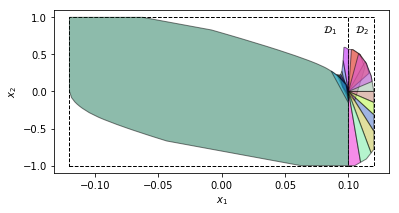

In [13]:
fig = plt.figure(figsize=(6,3))
X_1.plot(facecolor='w', linestyle='--')
plt.text(.08,.8,r'$\mathcal{D}_1$')
X_2.plot(facecolor='w', linestyle='--')
plt.text(.105,.8,r'$\mathcal{D}_2$')
library.plot_partition()
fig.savefig("sample_pendulum.pdf", bbox_inches='tight')
plt.show()

In [18]:
i = 0
for fs in library.library.values():
    if not fs['feasible_set'].halfspaces.empty:
        i += 1
print i

18


Sample for the highest nu|mber of overlapping regions

In [19]:
n_samples = 100
x_min = np.array([[.07],[-.4]])
x_max = np.array([[.12],[.5]])
p_list = []
for ss in library.library.values():
    if not ss['feasible_set'].empty:
        p = Polytope(ss['feasible_set'].hull.A, ss['feasible_set'].hull.b)
        p.assemble()
        p_list.append(p)
def max_overlapping_regions(p_list, n_samples, x_min, x_max):
    max_overlappings = 0
    for i in range(n_samples):
        print 'Max overlappings after ' + str(i+1) + ' samples: ' + str(max_overlappings) + '\r',
        x = np.random.rand(2, 1)
        x = np.multiply(x, (x_max - x_min)) + x_min
        overlappings = 0
        for p in p_list:
            if p.applies_to(x):
                overlappings += 1
        max_overlappings = max(max_overlappings, overlappings)
max_overlapping_regions(p_list, n_samples, x_min, x_max)

AttributeError: InnerApproximationOfPolytopeProjection instance has no attribute 'empty'

Simulate closed loop system

In [20]:
u = []
x = [x_0]
ss = []
ss_feasible = None
for k in range(N_sim):
    print('Time step ' + str(k) + '.\r'),
    u_k, ss_k = library.feedback(x[k], ss_feasible)
    u.append(u_k)
    x.append(pwa_sys.simulate(x[k], [u_k])[0][1])
    ss.append(ss_k)
    ss_feasible = ss_k[1:] + (terminal_mode,)

AttributeError: EmptyFeasibleSet instance has no attribute 'applies_to'

In [ ]:
mpc_plt.input_sequence(u, t_s, (u_min, u_max))
plt.show()
mpc_plt.state_trajectory(x, t_s, (x_min_1, x_min_2, x_max_2))
plt.show()

# Enumeration of feasible mode sequences

Construct all the possible 2^N modes

In [ ]:
from itertools import product
modes = [[0,1]]*controller.N
ms_list = product(*modes)
ms_list = [ma for ma in ms_list]

Derive the feasible set for each mode sequence

In [ ]:
n_feasible = 2**controller.N
errors = 0
n = 0
p_list = []
for i, ms in enumerate(ms_list):
    print i, ms
    prog = controller.condense_program(ms)
    try:
        if prog.feasible_set is None:
            n_feasible -= 1
        else:
            p_list.append(prog.feasible_set)
            n += 1
    except:
        errors += 1

Plot the partition

In [ ]:
fig = plt.figure(figsize=(6,3))
X_1.plot(facecolor='w', linestyle='--')
plt.text(.08,.8,r'$\mathcal{D}_1$')
X_2.plot(facecolor='w', linestyle='--')
plt.text(.105,.8,r'$\mathcal{D}_2$')
for i,p in enumerate(p_list):
    color = np.random.rand(3,1)
    p.plot(facecolor=color, alpha=.5)
#fig.savefig("all_feasible_mode_sequences.pdf", bbox_inches='tight')
plt.show()

Sample for the highest number of overlapping regions

In [ ]:
n_samples = 10000
x_min = np.array([[.07],[-.4]])
x_max = np.array([[.12],[.5]])
max_overlapping_regions(p_list, n_samples, x_min, x_max)

# Fancy plot for the paper

In [ ]:
N_sim = 200
fig = plt.figure(figsize=(6,3))

# fake plots for the legend
plt.scatter(0,0, color='w', edgecolor='k', label='Initial conditions')
plt.scatter(0,0, color='r', edgecolor='k', label='Equilibrium point')
plt.plot([0,0],[0,0], color=np.array([.3,.3,1.]), linestyle='--', label='Approximate hybrid MPC')
plt.plot([0,0],[0,0], color=np.array([.3,1.,.3]), label='Exact hybrid MPC')

# plots of the domains
plt.plot([.1,.1],[-.6,.4], color='k', linestyle='--')
plt.text(.09,.35,r'$\mathcal{D}_1$')
plt.text(.105,.35,r'$\mathcal{D}_2$')

# plot of the trajectories
x1 = .095
for j, x2 in enumerate(np.linspace(-.5,.5,21)):
    print j
    x_0 = np.array([[x1],[x2]])
    # plot exact mpc
    u = []
    x = [x_0]
    feasible = True
    for k in range(N_sim):
        u.append(controller.feedback(x[k]))
        if np.isnan(np.linalg.norm(u[k])):
            feasible = False
            break
        x_next = pwa_sys.simulate(x[k], [u[k]])[0][1]
        x.append(x_next)
    if feasible:
        mpc_plt.state_space_trajectory(x, color=np.array([.3,1.,.3]))
    # plot approximate mpc   
    u = []
    x = [x_0]
    ss = []
    ss_feasible = None
    feasible = True
    for k in range(N_sim):
        u_k, ss_k = library.feedback(x[k], ss_feasible)
        if np.isnan(np.linalg.norm(u_k)):
            feasible = False
            break
        u.append(u_k)
        x.append(pwa_sys.simulate(x[k], [u_k])[0][1])
        ss.append(ss_k)
        ss_feasible = ss_k[1:] + (terminal_mode,)
    if feasible:
        mpc_plt.state_space_trajectory(x, color=np.array([.3,.3,1.]), linestyle=':')
plt.legend(loc=9)
#fig.savefig("trajectories_pendulum.pdf", bbox_inches='tight')
plt.show()